In [8]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
import OldDecodingTools as odt
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, iqr
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import pingouin as pg

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'

NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)

 
act_directory = 'C:\\\\Users\\insan\\Documents\\Analysis_Cache\\Analysis_Cache'
ops_directory = 'C:\\\\Users\\insan\\Documents\\Opsin_Cache\\Opsin_Cache' # use when on pc
beh_directory = 'C:\\\\Users\\Insan\\Documents\\Behavioor'
#ops_directory = '/Users/mikeymalina/Data/Insanally/Opsin_Cache' # use when on mac


didnotlearnopsinanimals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
dualrecanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108'] # ,'DS_15','DS_19'

In [9]:
firstExpert = SimpleNamespace()
firstExpert.pre = dict()
firstExpert.post = dict()

#Tuning Animals
firstExpert.pre['BS_173'] = 14
firstExpert.pre['BS_175'] = 10
firstExpert.pre['BS_187'] = 6
firstExpert.pre['BS_188'] = 5
firstExpert.pre['BS_213'] = 6
firstExpert.pre['BS_214'] = np.Inf
firstExpert.pre['TH_217'] = 18

firstExpert.post['BS_173'] = 28
firstExpert.post['BS_175'] = 27
firstExpert.post['BS_187'] = 15
firstExpert.post['BS_188'] = 18
firstExpert.post['BS_213'] = np.Inf
firstExpert.post['BS_214'] = np.Inf
firstExpert.post['TH_217'] = np.Inf ### Pending

#Dual recording animals
firstExpert.pre['BS_40'] = 16 # Maybe 17
firstExpert.pre['BS_41'] = 4
firstExpert.pre['BS_42'] = 5
firstExpert.pre['BS_49'] = 12
firstExpert.pre['BS_50'] = 10
firstExpert.pre['BS_51'] = 6
firstExpert.pre['BS_56'] = 6
firstExpert.pre['BS_59'] = 4
firstExpert.pre['BS_67'] = 4 #Maybe 5. 68% and 1.6
firstExpert.pre['BS_70'] = 6
firstExpert.pre['BS_72'] = 4
firstExpert.pre['BS_87'] = 4
firstExpert.pre['BS_108'] = 5
firstExpert.pre['DS_15'] = 9
firstExpert.pre['DS_19'] = 10

firstExpert.post['BS_40'] = 30
firstExpert.post['BS_41'] = 16
firstExpert.post['BS_42'] = 15
firstExpert.post['BS_49'] = 18
firstExpert.post['BS_50'] = np.Inf
firstExpert.post['BS_51'] = 17
firstExpert.post['BS_56'] = 14
firstExpert.post['BS_59'] = 13
firstExpert.post['BS_67'] = 13
firstExpert.post['BS_70'] = 18
firstExpert.post['BS_72'] = 19
firstExpert.post['BS_87'] = 13
firstExpert.post['BS_108'] = 15
firstExpert.post['DS_15'] = 25 #Double-check this
firstExpert.post['DS_19'] = 23

#Naive behavior animals
firstExpert.pre['BS_52'] = 12
firstExpert.pre['BS_61'] = 7

firstExpert.post['BS_52'] = 28
firstExpert.post['BS_61'] = 18

In [10]:
def find_active_trials(outcomes,window_length = 75, active_thresholds = [0.2,0.8], verification_threshold = 0.8):
    hits = np.equal(outcomes,1)
    misses = np.equal(outcomes,2)
    falarms = np.equal(outcomes,3)
    crejects = np.equal(outcomes,4)
    
    gos = np.logical_or(hits,falarms)
    participation = np.array([np.mean(gos[i:(i+window_length)]) for i in range(len(gos)-window_length)])
    
        
    #Calculate where active conditions are fulfilled
    activehighthresh = np.less(participation,1) # changed this and below to include ALL TRIALS
    activelowthresh = np.greater(participation,0)
    

    #active = np.logical_and(activehighthresh,activelowthresh)
    active = np.broadcast_to(True, np.shape(participation)) # this will define all trials as active

    #Get trial numbers
    activetrials = np.where(active)[0]
    if len(activetrials) > 0: #changed this to include all files
        activestart = np.min(activetrials)
        activeend = np.max(activetrials)
    else:
        activestart = np.nan
        activeend = np.nan
    
    ############################################ If there's no active period then skip everything
    if not np.isfinite(activestart) or not np.isfinite(activeend):
        valid_trials = np.zeros_like(outcomes,dtype='bool')
        return valid_trials
    
    ############################################ Verify that an appropriate amount of this span is active
    activespan = np.array(range(len(active)))
    tempspan = np.greater_equal(activespan,activestart)
    tempspan2 = np.less_equal(activespan,activeend)
    activespan = np.logical_and(tempspan,tempspan2)
    verification_frac = np.sum(active) / np.sum(activespan)
    #Check against verification_threshold and abort if insufficient
    if np.isfinite(verification_frac) and verification_frac < verification_threshold:
        valid_trials = np.zeros_like(outcomes,dtype='bool')
        return valid_trials
    
    ############################################ Now return a proper valid_trials object
    activeend += window_length
    valid_trials = np.zeros_like(outcomes,dtype='bool')
    valid_trials[activestart:activeend] = True
    return valid_trials

In [11]:
def getSessionByTraining(directory,animal,region,day_of_training):
    for session in os.listdir(directory):
        sessionfile = ilep.loadSessionCached(directory,session)
        
        if sessionfile.meta.animal == animal and sessionfile.meta.region == region and sessionfile.meta.day_of_training == day_of_training:
            return sessionfile
        
    return None

In [12]:
def getOutcomesFromSession(sessionfile):
    outcomes = np.full_like(sessionfile.trials.starts,np.nan)
    hits = np.logical_and(sessionfile.trials.go,sessionfile.trials.target)
    misses = np.logical_and(np.logical_not(sessionfile.trials.go),sessionfile.trials.target)
    falarms = np.logical_and(sessionfile.trials.go,np.logical_not(sessionfile.trials.target))
    crejects = np.logical_and(np.logical_not(sessionfile.trials.go),np.logical_not(sessionfile.trials.target))
    outcomes[hits] = 1*np.ones(np.sum(hits))
    outcomes[misses] = 2*np.ones(np.sum(misses))
    outcomes[falarms] = 3*np.ones(np.sum(falarms))
    outcomes[crejects] = 4*np.ones(np.sum(crejects))
    return outcomes

In [13]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

In [14]:
def getAnimalBehaviorResults(animal,directory):
    hit_pct_ON = []
    miss_pct_ON = []
    falarm_pct_ON = []
    creject_pct_ON = []
    hit_pct_OFF = []
    miss_pct_OFF = []
    falarm_pct_OFF = []
    creject_pct_OFF = []
    sessionnum_list = np.sort([k for k in animalBehaviors[animal].sessions])

    for sessionnum in sessionnum_list:

        
        try:
            sessionfile = getSessionByTraining(directory,animal,'AC',sessionnum)
            outcomes_OFF = []
            outcomes_ON = []
            hasON = False
            if sessionfile is None:
                outcomes = animalBehaviors[animal].sessions[sessionnum].outcomes
                if hasattr(animalBehaviors[animal].sessions[sessionnum],'laser'):
                    laser = animalBehaviors[animal].sessions[sessionnum].laser
                else:
                    laser = np.zeros_like(outcomes,dtype='bool')
                
                ##############################################################################################
                valid_trials = find_active_trials(outcomes,window_length=75,verification_threshold=0.6)
                laser_ON = np.logical_and(laser,valid_trials)
                laser_OFF = np.logical_and(np.logical_not(laser),valid_trials)
                ##############################################################################################
                outcomes_ON = outcomes[laser_ON]
                outcomes_OFF = outcomes[laser_OFF]
            else:
                outcomes = getOutcomesFromSession(sessionfile)
                if hasattr(sessionfile.trials,'laser_stimulation'):
                    laser = sessionfile.trials.laser_stimulation
                else:
                    laser = np.zeros_like(outcomes,dtype='bool')
                    
                
                ##############################################################################################
                valid_trials = find_active_trials(outcomes,window_length=75,verification_threshold=0.6)
                laser_ON = np.logical_and(laser,valid_trials)
                laser_OFF = np.logical_and(np.logical_not(laser),valid_trials)
                ##############################################################################################
                outcomes_ON = outcomes[laser_ON]
                outcomes_OFF = outcomes[laser_OFF]


            hit_pct_ON.append(np.sum(np.equal(outcomes_ON,1))/len(outcomes_ON))
            miss_pct_ON.append(np.sum(np.equal(outcomes_ON,2))/len(outcomes_ON))
            falarm_pct_ON.append(np.sum(np.equal(outcomes_ON,3))/len(outcomes_ON))
            creject_pct_ON.append(np.sum(np.equal(outcomes_ON,4))/len(outcomes_ON))
            hit_pct_OFF.append(np.sum(np.equal(outcomes_OFF,1))/len(outcomes_OFF))
            miss_pct_OFF.append(np.sum(np.equal(outcomes_OFF,2))/len(outcomes_OFF))
            falarm_pct_OFF.append(np.sum(np.equal(outcomes_OFF,3))/len(outcomes_OFF))
            creject_pct_OFF.append(np.sum(np.equal(outcomes_OFF,4))/len(outcomes_OFF))
        except Exception as e:
            print(e)
            raise e
    corr_pct_ON = [h + c for (h,c) in zip(hit_pct_ON,creject_pct_ON)]
    corr_pct_OFF = [h + c for (h,c) in zip(hit_pct_OFF,creject_pct_OFF)]

    results = SimpleNamespace()
    results.sessionnum_list = np.array(sessionnum_list)
    results.corr_pct_ON = np.array(corr_pct_ON)
    results.hit_pct_ON = np.array(hit_pct_ON)
    results.miss_pct_ON = np.array(miss_pct_ON)
    results.falarm_pct_ON = np.array(falarm_pct_ON)
    results.creject_pct_ON = np.array(creject_pct_ON)
    results.corr_pct_OFF = np.array(corr_pct_OFF)
    results.hit_pct_OFF = np.array(hit_pct_OFF)
    results.miss_pct_OFF = np.array(miss_pct_OFF)
    results.falarm_pct_OFF = np.array(falarm_pct_OFF)
    results.creject_pct_OFF = np.array(creject_pct_OFF)
    return results

In [8]:
# turning these all into arrays that numpy can read from
opsin_pct_hit_ON = np.array(opsin_pct_hit_ON)
opsin_pct_hit_OFF = np.array(opsin_pct_hit_OFF)
dual_pct_hit = np.array(dual_pct_hit)

opsin_pct_miss_ON = np.array(opsin_pct_miss_ON)
opsin_pct_miss_OFF = np.array(opsin_pct_miss_OFF)
dual_pct_miss = np.array(dual_pct_miss)

opsin_pct_falarm_ON = np.array(opsin_pct_falarm_ON)
opsin_pct_falarm_OFF = np.array(opsin_pct_falarm_OFF)
dual_pct_falarm = np.array(dual_pct_falarm)

opsin_pct_creject_ON = np.array(opsin_pct_creject_ON)
opsin_pct_creject_OFF = np.array(opsin_pct_creject_OFF)
dual_pct_creject = np.array(dual_pct_creject)

opsin_pct_corr_ON = np.array(opsin_pct_corr_ON)
opsin_pct_corr_OFF = np.array(opsin_pct_corr_OFF)
dual_pct_corr = np.array(dual_pct_corr)

# removing Nans
opsin_pct_hit_ON = opsin_pct_hit_ON[np.isfinite(opsin_pct_hit_ON)]
opsin_pct_hit_OFF = opsin_pct_hit_OFF[np.isfinite(opsin_pct_hit_OFF)]
dual_pct_hit = np.array(dual_pct_hit[np.isfinite(dual_pct_hit)])
opsin_pct_miss_ON = np.array(opsin_pct_miss_ON[np.isfinite(opsin_pct_miss_ON)])
opsin_pct_miss_OFF = np.array(opsin_pct_miss_OFF[np.isfinite(opsin_pct_miss_OFF)])
dual_pct_miss = np.array(dual_pct_miss[np.isfinite(dual_pct_miss)])
opsin_pct_falarm_ON = np.array(opsin_pct_falarm_ON[np.isfinite(opsin_pct_falarm_ON)])
opsin_pct_falarm_OFF = np.array(opsin_pct_falarm_OFF[np.isfinite(opsin_pct_falarm_OFF)])
dual_pct_falarm = np.array(dual_pct_falarm[np.isfinite(dual_pct_falarm)])
opsin_pct_creject_ON = np.array(opsin_pct_creject_ON[np.isfinite(opsin_pct_creject_ON)])
opsin_pct_creject_OFF = np.array(opsin_pct_creject_OFF[np.isfinite(opsin_pct_creject_OFF)])
dual_pct_creject = np.array(dual_pct_creject[np.isfinite(dual_pct_creject)])
opsin_pct_corr_ON = np.array(opsin_pct_corr_ON[np.isfinite(opsin_pct_corr_ON)])
opsin_pct_corr_OFF = np.array(opsin_pct_corr_OFF[np.isfinite(opsin_pct_corr_OFF)])
dual_pct_corr = np.array(dual_pct_corr[np.isfinite(dual_pct_corr)])

NameError: name 'opsin_pct_hit_ON' is not defined


## Now making a function to iterate through first 12 days postreversal to see how differences in learning emerge between opsin and control
## (updated to include day before reversal and  trials prior to switch)

In [127]:
########################################################################
# COMPUTE OPSIN VALUES    
# 12x8 to account for 8 opsin animals across 12 days post-reversal
opsin_pct_corr_ON = np.zeros((12,8))
opsin_pct_hit_ON = np.zeros((12,8))
opsin_pct_miss_ON = np.zeros((12,8))
opsin_pct_falarm_ON = np.zeros((12,8))
opsin_pct_creject_ON = np.zeros((12,8))

opsin_pct_corr_OFF = np.zeros((12,8))
opsin_pct_hit_OFF = np.zeros((12,8))
opsin_pct_miss_OFF = np.zeros((12,8))
opsin_pct_falarm_OFF = np.zeros((12,8))
opsin_pct_creject_OFF = np.zeros((12,8))
opsin_animals_missing_data = ()

# 5 rows for corr, hit, miss, falarm, creject
# 8 columns for 8 animals
opsin_dayBefore_OFF = np.zeros((5,8))
opsin_day0_preR_OFF = np.zeros((5,8))
opsin_day0_postR_OFF = np.zeros((5,8))
opsin_day0_postR_ON = np.zeros((5,8))

for idx,animal in enumerate(didnotlearnopsinanimals):
     
    results = getAnimalBehaviorResults(animal,ops_directory)
    
    # grabbing performance the day before reversal
    # all this will be used for later plot
    reversal = animalBehaviors[animal].reversal
    day_before_reversal = reversal - 1   
    
    # all trials day of reversal after the reversal, laser OFF
    # these trials are not effected by cloudy days
    opsin_hit_day0_postR_OFF = animalBehaviors[animal].sessions[reversal].offPostBehavior.hits
    opsin_miss_day0_postR_OFF = animalBehaviors[animal].sessions[reversal].offPostBehavior.misses
    opsin_creject_day0_postR_OFF = animalBehaviors[animal].sessions[reversal].offPostBehavior.crejects
    opsin_falarm_day0_postR_OFF = animalBehaviors[animal].sessions[reversal].offPostBehavior.falarms
    opsin_trialNum_day0_postR_OFF = opsin_hit_day0_postR_OFF + opsin_miss_day0_postR_OFF + opsin_creject_day0_postR_OFF + opsin_falarm_day0_postR_OFF
    
    opsin_hit_day0_postR_OFF_pct = opsin_hit_day0_postR_OFF / (opsin_hit_day0_postR_OFF + opsin_miss_day0_postR_OFF)
    opsin_miss_day0_postR_OFF_pct = opsin_miss_day0_postR_OFF / (opsin_hit_day0_postR_OFF + opsin_miss_day0_postR_OFF)
    opsin_creject_day0_postR_OFF_pct = opsin_creject_day0_postR_OFF / (opsin_creject_day0_postR_OFF + opsin_falarm_day0_postR_OFF)
    opsin_falarm_day0_postR_OFF_pct = opsin_falarm_day0_postR_OFF / (opsin_creject_day0_postR_OFF + opsin_falarm_day0_postR_OFF)
    opsin_corr_day0_postR_OFF_pct = (opsin_hit_day0_postR_OFF + opsin_creject_day0_postR_OFF) / opsin_trialNum_day0_postR_OFF
    
    opsin_day0_postR_OFF[0][idx] = opsin_corr_day0_postR_OFF_pct
    opsin_day0_postR_OFF[1][idx] = opsin_hit_day0_postR_OFF_pct
    opsin_day0_postR_OFF[2][idx] = opsin_miss_day0_postR_OFF_pct
    opsin_day0_postR_OFF[3][idx] = opsin_creject_day0_postR_OFF_pct
    opsin_day0_postR_OFF[4][idx] = opsin_falarm_day0_postR_OFF_pct
    
    # all trials day of reversal after the reversal, laser ON
    # these trials are not effected by cloudy days
    opsin_hit_day0_postR_ON = animalBehaviors[animal].sessions[reversal].onPostBehavior.hits
    opsin_miss_day0_postR_ON = animalBehaviors[animal].sessions[reversal].onPostBehavior.misses
    opsin_creject_day0_postR_ON = animalBehaviors[animal].sessions[reversal].onPostBehavior.crejects

    opsin_falarm_day0_postR_ON = animalBehaviors[animal].sessions[reversal].onPostBehavior.falarms
    opsin_trialNum_day0_postR_ON = opsin_hit_day0_postR_ON + opsin_miss_day0_postR_ON + opsin_creject_day0_postR_ON + opsin_falarm_day0_postR_ON
    
    opsin_hit_day0_postR_ON_pct = opsin_hit_day0_postR_ON / (opsin_hit_day0_postR_ON + opsin_miss_day0_postR_ON)
    opsin_miss_day0_postR_ON_pct = opsin_miss_day0_postR_ON / (opsin_hit_day0_postR_ON + opsin_miss_day0_postR_ON)
    opsin_creject_day0_postR_ON_pct = opsin_creject_day0_postR_ON / (opsin_creject_day0_postR_ON + opsin_falarm_day0_postR_ON)
    opsin_falarm_day0_postR_ON_pct = opsin_falarm_day0_postR_ON / (opsin_creject_day0_postR_ON + opsin_falarm_day0_postR_ON)
    opsin_corr_day0_postR_ON_pct = (opsin_hit_day0_postR_ON + opsin_miss_day0_postR_ON) / opsin_trialNum_day0_postR_ON
    
    opsin_day0_postR_ON[0][idx] = opsin_corr_day0_postR_ON_pct
    opsin_day0_postR_ON[1][idx] = opsin_hit_day0_postR_ON_pct
    opsin_day0_postR_ON[2][idx] = opsin_miss_day0_postR_ON_pct
    opsin_day0_postR_ON[3][idx] = opsin_creject_day0_postR_ON_pct
    opsin_day0_postR_ON[4][idx] = opsin_falarm_day0_postR_ON_pct
   

    # days to exclude from analysis for given animal
    BS_86_exclude = [20,21,22,23,24] - animalBehaviors['BS_86'].reversal
    BS_92_exclude = [17,19,22] - animalBehaviors['BS_92'].reversal
    BS_103_exclude = [12,13,14,15,16] - animalBehaviors['BS_103'].reversal
    BS_128_exclude = [14] - animalBehaviors['BS_128'].reversal
    BS_165_exclude = [13] # no reversal for BS_165

    # iterating through the 12 days post-reversal for each animal
    for i in range(12):  
        
        cutoffday = animalBehaviors[animal].reversal + (i+1)
        not_cut_off_days = np.where(np.less_equal(results.sessionnum_list,cutoffday))[0]
        day_to_use = np.max(not_cut_off_days)
        postreversal_days = day_to_use + 1
        
        if postreversal_days < np.max(results.sessionnum_list):
            
            # removing cloudy days from analysis
            if animal == 'BS_86' and i in BS_86_exclude or animal == 'BS_92' and i in BS_92_exclude or animal == 'BS_103' and i in BS_103_exclude or animal == 'BS_128' and i in BS_128_exclude or animal == 'BS_165' and i in BS_165_exclude:
                
                opsin_pct_hit_ON[i][idx] = np.nan
                opsin_pct_miss_ON[i][idx] = np.nan
                opsin_pct_falarm_ON[i][idx] = np.nan
                opsin_pct_creject_ON[i][idx] = np.nan
                opsin_pct_corr_ON[i][idx] = np.nan
                opsin_pct_hit_OFF[i][idx] = np.nan
                opsin_pct_miss_OFF[i][idx] = np.nan
                opsin_pct_falarm_OFF[i][idx] = np.nan
                opsin_pct_creject_OFF[i][idx] = np.nan 
                opsin_pct_corr_OFF[i][idx] = np.nan
                
            else: 
                                        
                opsin_pct_hit_ON[i][idx] = results.hit_pct_ON[postreversal_days] / (results.hit_pct_ON[postreversal_days] + results.miss_pct_ON[postreversal_days])
                opsin_pct_miss_ON[i][idx] = results.miss_pct_ON[postreversal_days] / (results.hit_pct_ON[postreversal_days] + results.miss_pct_ON[postreversal_days])
                opsin_pct_falarm_ON[i][idx] = results.falarm_pct_ON[postreversal_days] / (results.falarm_pct_ON[postreversal_days] + results.creject_pct_ON[postreversal_days])
                opsin_pct_creject_ON[i][idx] = results.creject_pct_ON[postreversal_days] / (results.falarm_pct_ON[postreversal_days] + results.creject_pct_ON[postreversal_days])
                opsin_pct_corr_ON[i][idx] = results.corr_pct_ON[postreversal_days]
                opsin_pct_hit_OFF[i][idx] = results.hit_pct_OFF[postreversal_days]  / (results.hit_pct_OFF[postreversal_days] + results.miss_pct_OFF[postreversal_days])
                opsin_pct_miss_OFF[i][idx] = results.miss_pct_OFF[postreversal_days] / (results.hit_pct_OFF[postreversal_days] + results.miss_pct_OFF[postreversal_days])
                opsin_pct_falarm_OFF[i][idx] = results.falarm_pct_OFF[postreversal_days] / (results.falarm_pct_OFF[postreversal_days] + results.creject_pct_OFF[postreversal_days])
                opsin_pct_creject_OFF[i][idx] = results.creject_pct_OFF[postreversal_days]  / (results.falarm_pct_OFF[postreversal_days] + results.creject_pct_OFF[postreversal_days])
                opsin_pct_corr_OFF[i][idx] = results.corr_pct_OFF[postreversal_days]

        else:
            postreversal_days = np.nan
            opsin_pct_hit_ON[i][idx] = np.nan
            opsin_pct_miss_ON[i][idx] = np.nan
            opsin_pct_falarm_ON[i][idx] = np.nan
            opsin_pct_creject_ON[i][idx] = np.nan
            opsin_pct_corr_ON[i][idx] = np.nan
            opsin_pct_hit_OFF[i][idx] = np.nan
            opsin_pct_miss_OFF[i][idx] = np.nan
            opsin_pct_falarm_OFF[i][idx] = np.nan
            opsin_pct_creject_OFF[i][idx] = np.nan
            opsin_pct_corr_OFF[i][idx] = np.nan        

    print('Opsin', animal, 'done')
#######################################################################

########################################################################
### COMPUTE DUALREC VALUES
# 12 x 14 to account for 14 dualRec animals across 12 post revevrsal days
dual_pct_corr = np.zeros((12,14))
dual_pct_hit = np.zeros((12,14))
dual_pct_miss = np.zeros((12,14))
dual_pct_falarm = np.zeros((12,14))
dual_pct_creject = np.zeros((12,14))

# 5 rows for corr, hit, miss, falarm, creject
# 14 columns for 14 animals
dual_dayBefore_OFF = np.zeros((5,14))
dual_day0_preR_OFF = np.zeros((5,14))
dual_day0_postR_OFF = np.zeros((5,14))
    
for idx,animal in enumerate(dualrecanimalnames):    
    
    results = getAnimalBehaviorResults(animal,act_directory)
    
    # grabbing performance the day before reversal
    # all this will be used for later plot
    reversal = animalBehaviors[animal].reversal
    
    # all trials day of reversal after the reversal
    # these days are not effected by issues
    dual_hit_day0_postR = animalBehaviors[animal].sessions[reversal].offPostBehavior.hits
    dual_miss_day0_postR = animalBehaviors[animal].sessions[reversal].offPostBehavior.misses
    dual_creject_day0_postR = animalBehaviors[animal].sessions[reversal].offPostBehavior.crejects
    dual_falarm_day0_postR = animalBehaviors[animal].sessions[reversal].offPostBehavior.falarms
    dual_trialNum_day0_postR = dual_hit_day0_postR + dual_miss_day0_postR + dual_creject_day0_postR + dual_falarm_day0_postR
    
    dual_hit_day0_postR_pct = dual_hit_day0_postR / (dual_hit_day0_postR + dual_miss_day0_postR)
    dual_miss_day0_postR_pct = dual_miss_day0_postR / (dual_hit_day0_postR + dual_miss_day0_postR)
    dual_creject_day0_postR_pct = dual_creject_day0_postR / (dual_creject_day0_postR + dual_falarm_day0_postR)
    dual_falarm_day0_postR_pct = dual_falarm_day0_postR / (dual_creject_day0_postR + dual_falarm_day0_postR)
    dual_corr_day0_postR_pct = (dual_hit_day0_postR + dual_creject_day0_postR) / dual_trialNum_day0_postR 
    
    dual_day0_postR_OFF[0][idx] = dual_corr_day0_postR_pct
    dual_day0_postR_OFF[1][idx] = dual_hit_day0_postR_pct
    dual_day0_postR_OFF[2][idx] = dual_miss_day0_postR_pct
    dual_day0_postR_OFF[3][idx] = dual_creject_day0_postR_pct
    dual_day0_postR_OFF[4][idx] = dual_falarm_day0_postR_pct
    
    for i in range(12):
        
        # iterating through the 12 days post-reversal for each animal
        cutoffday = animalBehaviors[animal].reversal + (i+1)
        not_cut_off_days = np.where(np.less_equal(results.sessionnum_list,cutoffday))[0]
        day_to_use = np.max(not_cut_off_days)
        postreversal_days = day_to_use + 1
        
        # days to exclude from analysis for given animal
        BS_49_exclude = [19,20] - animalBehaviors['BS_49'].reversal
        BS_50_exclude = [13] - animalBehaviors['BS_50'].reversal
        BS_51_exclude = [22,23,24] - animalBehaviors['BS_51'].reversal
        BS_56_exclude = [22] - animalBehaviors['BS_56'].reversal
        BS_67_exclude = [15,16,17,18,19,20,21,22] - animalBehaviors['BS_67'].reversal
 
        if postreversal_days < np.max(results.sessionnum_list):
        
            if animal == 'BS_49' and i in BS_49_exclude or animal == 'BS_50' and i in BS_50_exclude or animal == 'BS_51' and i in BS_51_exclude or animal == 'BS_56' and i in BS_56_exclude or animal == 'BS_67' and i in BS_67_exclude:
            
                dual_pct_hit[i][idx] = np.nan
                dual_pct_miss[i][idx] = np.nan
                dual_pct_creject[i][idx] = np.nan
                dual_pct_falarm[i][idx] = np.nan
                dual_pct_corr[i][idx] = np.nan
                
            else:

                dual_pct_hit[i][idx] = results.hit_pct_OFF[postreversal_days] / (results.hit_pct_OFF[postreversal_days] + results.miss_pct_OFF[postreversal_days])
                dual_pct_miss[i][idx] = results.miss_pct_OFF[postreversal_days] / (results.hit_pct_OFF[postreversal_days] + results.miss_pct_OFF[postreversal_days])
                dual_pct_falarm[i][idx] = results.falarm_pct_OFF[postreversal_days] / (results.falarm_pct_OFF[postreversal_days] + results.creject_pct_OFF[postreversal_days])
                dual_pct_creject[i][idx] = results.creject_pct_OFF[postreversal_days] /  (results.falarm_pct_OFF[postreversal_days] + results.creject_pct_OFF[postreversal_days])
                dual_pct_corr[i][idx] = results.corr_pct_OFF[postreversal_days]
            
        else:
            postreversal_days = np.nan
            dual_pct_hit[i][idx] = np.nan
            dual_pct_miss[i][idx] = np.nan
            dual_pct_falarm[i][idx] = np.nan 
            dual_pct_creject[i][idx] = np.nan
            dual_pct_corr[i][idx] = np.nan
#######################################################################
    print('Dualrec', animal, 'done')


Opsin BS_86 done
Opsin BS_100 done
Opsin BS_119 done
Opsin BS_123 done
Opsin BS_128 done
Opsin BS_131 done
Opsin BS_163 done
Opsin BS_174 done
Dualrec BS_40 done
Dualrec BS_41 done
Dualrec BS_42 done
Dualrec BS_49 done
Dualrec BS_50 done
Dualrec BS_51 done
Dualrec BS_56 done
Dualrec BS_59 done
Dualrec BS_61 done
Dualrec BS_67 done
Dualrec BS_70 done
Dualrec BS_72 done
Dualrec BS_87 done
Dualrec BS_108 done


In [145]:
#### removing NaNs (below is normal procedure to keep all data)
opsin_pct_hit_OFF_noNan = [row[~np.isnan(row)] for row in opsin_pct_hit_OFF]
opsin_pct_hit_ON_noNan = [row[~np.isnan(row)] for row in opsin_pct_hit_ON]
opsin_pct_miss_OFF_noNan = [row[~np.isnan(row)] for row in opsin_pct_miss_OFF]
opsin_pct_miss_ON_noNan = [row[~np.isnan(row)] for row in opsin_pct_miss_ON]
opsin_pct_creject_OFF_noNan = [row[~np.isnan(row)] for row in opsin_pct_creject_OFF]
opsin_pct_creject_ON_noNan = [row[~np.isnan(row)] for row in opsin_pct_creject_ON]
opsin_pct_falarm_OFF_noNan = [row[~np.isnan(row)] for row in opsin_pct_falarm_OFF]
opsin_pct_falarm_ON_noNan = [row[~np.isnan(row)] for row in opsin_pct_falarm_ON]
opsin_pct_corr_OFF_noNan = [row[~np.isnan(row)] for row in opsin_pct_corr_OFF]
opsin_pct_corr_ON_noNan = [row[~np.isnan(row)] for row in opsin_pct_corr_ON  ]

dual_pct_hit_noNan = [row[~np.isnan(row)] for row in dual_pct_hit]
dual_pct_miss_noNan = [row[~np.isnan(row)] for row in dual_pct_miss]
dual_pct_creject_noNan = [row[~np.isnan(row)] for row in dual_pct_creject]
dual_pct_falarm_noNan = [row[~np.isnan(row)] for row in dual_pct_falarm]
dual_pct_corr_noNan = [row[~np.isnan(row)] for row in dual_pct_corr]

In [147]:
print(np.shape(opsin_pct_hit_OFF))

(12, 8)


In [134]:
print((opsin_pct_corr_ON_noNan[1][1]))

0.46632124352331605


sig before: [True, False, False, False, False, False, True, True, False, True, False, True]
sig after: (array([ 0,  6,  7,  9, 11], dtype=int64),)


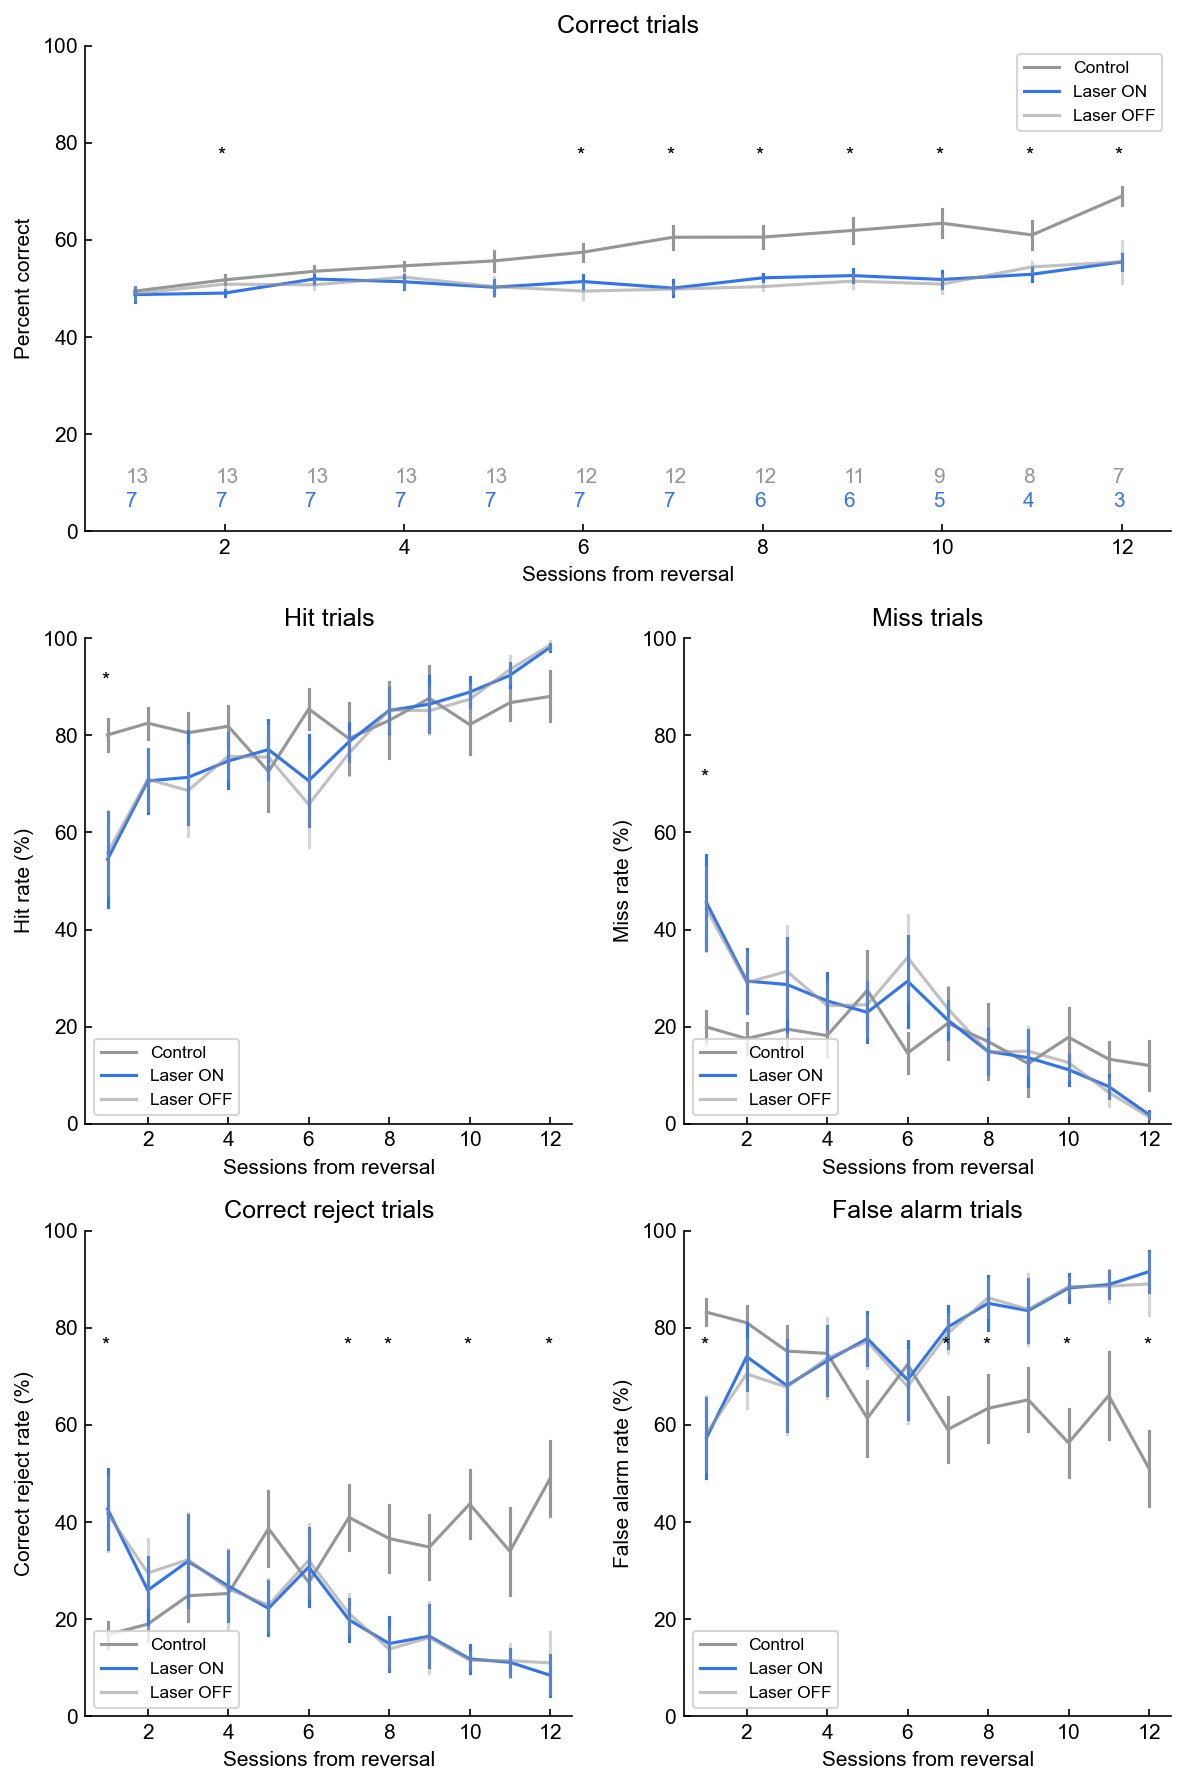

In [55]:
# defining our data to plot
# 3/29/23 changing to 11 for remove BS_86 BS_119 test
corrData_plot = np.zeros((3,12))
corrSEM_plot = np.zeros((6,12))

hitData_plot = np.zeros((3,12))
hitSEM_plot = np.zeros((6,12))

missData_plot = np.zeros((3,12))
missSEM_plot = np.zeros((6,12))

crejectData_plot = np.zeros((3,12))
crejectSEM_plot = np.zeros((6,12))

falarmData_plot = np.zeros((3,12))
falarmSEM_plot = np.zeros((6,12))

days = np.arange(1,13)

# computing values for plotting
#####################################################################
for i in range(12):
    
    # correct data mean and SEM
    corrData_plot[0][i] = np.multiply(np.mean(dual_pct_corr_noNan[i][:]), 100)
    corrData_plot[1][i] = np.multiply(np.mean(opsin_pct_corr_ON_noNan[i][:]),100)
    corrData_plot[2][i] = np.multiply(np.mean(opsin_pct_corr_OFF_noNan[i][:]),100)
    corrSEM_plot[0][i] = corrData_plot[0][i] - np.multiply(sem(dual_pct_corr_noNan[i][:]), 100)
    corrSEM_plot[1][i] = corrData_plot[0][i] + np.multiply(sem(dual_pct_corr_noNan[i][:]), 100)
    corrSEM_plot[2][i] = corrData_plot[1][i] - np.multiply(sem(opsin_pct_corr_ON_noNan[i][:]), 100)
    corrSEM_plot[3][i] = corrData_plot[1][i] + np.multiply(sem(opsin_pct_corr_ON_noNan[i][:]), 100)  
    corrSEM_plot[4][i] = corrData_plot[2][i] - np.multiply(sem(opsin_pct_corr_OFF_noNan[i][:]), 100)
    corrSEM_plot[5][i] = corrData_plot[2][i] + np.multiply(sem(opsin_pct_corr_OFF_noNan[i][:]), 100)
    
    # hit data mean and SEM
    hitData_plot[0][i] = np.multiply(np.mean(dual_pct_hit_noNan[i][:]), 100)
    hitData_plot[1][i] = np.multiply(np.mean(opsin_pct_hit_ON_noNan[i][:]),100)
    hitData_plot[2][i] = np.multiply(np.mean(opsin_pct_hit_OFF_noNan[i][:]),100)
    hitSEM_plot[0][i] = hitData_plot[0][i] - np.multiply(sem(dual_pct_hit_noNan[i][:]), 100)
    hitSEM_plot[1][i] = hitData_plot[0][i] + np.multiply(sem(dual_pct_hit_noNan[i][:]), 100)
    hitSEM_plot[2][i] = hitData_plot[1][i] - np.multiply(sem(opsin_pct_hit_ON_noNan[i][:]), 100)
    hitSEM_plot[3][i] = hitData_plot[1][i] + np.multiply(sem(opsin_pct_hit_ON_noNan[i][:]), 100)
    hitSEM_plot[4][i] = hitData_plot[2][i] - np.multiply(sem(opsin_pct_hit_OFF_noNan[i][:]), 100)
    hitSEM_plot[5][i] = hitData_plot[2][i] + np.multiply(sem(opsin_pct_hit_OFF_noNan[i][:]), 100)
    
    # miss data mean and SEM
    missData_plot[0][i] = np.multiply(np.mean(dual_pct_miss_noNan[i][:]), 100)
    missData_plot[1][i] = np.multiply(np.mean(opsin_pct_miss_ON_noNan[i][:]),100)
    missData_plot[2][i] = np.multiply(np.mean(opsin_pct_miss_OFF_noNan[i][:]),100)
    missSEM_plot[0][i] = missData_plot[0][i] - np.multiply(sem(dual_pct_miss_noNan[i][:]), 100)
    missSEM_plot[1][i] = missData_plot[0][i] + np.multiply(sem(dual_pct_miss_noNan[i][:]), 100)
    missSEM_plot[2][i] = missData_plot[1][i] - np.multiply(sem(opsin_pct_miss_ON_noNan[i][:]), 100)
    missSEM_plot[3][i] = missData_plot[1][i] + np.multiply(sem(opsin_pct_miss_ON_noNan[i][:]), 100)
    missSEM_plot[4][i] = missData_plot[2][i] - np.multiply(sem(opsin_pct_miss_OFF_noNan[i][:]), 100)
    missSEM_plot[5][i] = missData_plot[2][i] + np.multiply(sem(opsin_pct_miss_OFF_noNan[i][:]), 100)
    
    # creject data mean and SEM
    crejectData_plot[0][i] = np.multiply(np.mean(dual_pct_creject_noNan[i][:]), 100)
    crejectData_plot[1][i] = np.multiply(np.mean(opsin_pct_creject_ON_noNan[i][:]),100)
    crejectData_plot[2][i] = np.multiply(np.mean(opsin_pct_creject_OFF_noNan[i][:]),100)
    crejectSEM_plot[0][i] = crejectData_plot[0][i] - np.multiply(sem(dual_pct_creject_noNan[i][:]), 100)
    crejectSEM_plot[1][i] = crejectData_plot[0][i] + np.multiply(sem(dual_pct_creject_noNan[i][:]), 100)
    crejectSEM_plot[2][i] = crejectData_plot[1][i] - np.multiply(sem(opsin_pct_creject_ON_noNan[i][:]), 100)
    crejectSEM_plot[3][i] = crejectData_plot[1][i] + np.multiply(sem(opsin_pct_creject_ON_noNan[i][:]), 100)
    crejectSEM_plot[4][i] = crejectData_plot[2][i] - np.multiply(sem(opsin_pct_creject_OFF_noNan[i][:]), 100)
    crejectSEM_plot[5][i] = crejectData_plot[2][i] + np.multiply(sem(opsin_pct_creject_OFF_noNan[i][:]), 100)
    
    # falarm data mean and mean
    falarmData_plot[0][i] = np.multiply(np.mean(dual_pct_falarm_noNan[i][:]), 100)
    falarmData_plot[1][i] = np.multiply(np.mean(opsin_pct_falarm_ON_noNan[i][:]),100)
    falarmData_plot[2][i] = np.multiply(np.mean(opsin_pct_falarm_OFF_noNan[i][:]),100)
    falarmSEM_plot[0][i] = falarmData_plot[0][i] - np.multiply(sem(dual_pct_falarm_noNan[i][:]), 100)
    falarmSEM_plot[1][i] = falarmData_plot[0][i] + np.multiply(sem(dual_pct_falarm_noNan[i][:]), 100)
    falarmSEM_plot[2][i] = falarmData_plot[1][i] - np.multiply(sem(opsin_pct_falarm_ON_noNan[i][:]), 100)
    falarmSEM_plot[3][i] = falarmData_plot[1][i] + np.multiply(sem(opsin_pct_falarm_ON_noNan[i][:]), 100)
    falarmSEM_plot[4][i] = falarmData_plot[2][i] - np.multiply(sem(opsin_pct_falarm_OFF_noNan[i][:]), 100)
    falarmSEM_plot[5][i] = falarmData_plot[2][i] + np.multiply(sem(opsin_pct_falarm_OFF_noNan[i][:]), 100)
    
#####################################################################
# computing # of animals per day
#####################################################################
# opsin:
num_nan = []
for i in range(12):
    
    val = np.where(np.isnan(opsin_pct_hit_OFF[i,:]))
    val = np.shape(val[0])[0]
    num_nan.append(val)

# 8 for 8 opsin animals
num_nan_opsin = [7 - num_nan for num_nan in num_nan]

# control
num_nan = []
for i in range(12):
    
    val = np.where(np.isnan(dual_pct_hit[i,:]))
    val = np.shape(val[0])[0]
    num_nan.append(val)

# 14 for 14 dualRec animals
num_nan_dual = [14 - num_nan for num_nan in num_nan]



#####################################################################
fig,ax = plt.subplots(6,1)
fig.set_figheight(12)
fig.set_figwidth(12)

ax[0] = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=2)
ax[1] = plt.subplot2grid(shape=(3, 3), loc=(1, 0), colspan=1)
ax[2] = plt.subplot2grid(shape=(3, 3), loc=(1, 1), rowspan=1)
ax[3] = plt.subplot2grid((3, 3), (2, 0))
ax[4] = plt.subplot2grid((3, 3), (2, 1), colspan=1)

#####################################################################
# plot CORRECT and
# statistical testing
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_corr_noNan[i][:],opsin_pct_corr_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
#     print('correct:')
#     print('sig: '+str(sig[i]))
#     print('pval: '+str(pval[i]))

   
ax[0].set_ylim(0,100)
ax[0].plot(days, corrData_plot[0], color = GOOD_GREY, label = 'Control')
ax[0].plot(days, corrData_plot[1], color = LASER_COLOR, label = 'Laser ON')
ax[0].plot(days, corrData_plot[2], color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF')


ax[0].plot([days,days], [corrSEM_plot[0], corrSEM_plot[1]], color = GOOD_GREY)
ax[0].plot([days,days], [corrSEM_plot[2], corrSEM_plot[3]], color = LASER_COLOR)
ax[0].plot([days,days], [corrSEM_plot[4], corrSEM_plot[5]], color = GOOD_GREY, alpha = 0.4)


# determining significant days
sig = np.where(sig)
#pval = np.where(pval)
sigDays = np.array([items for items in sig[0]])
#pvalDays = np.array([items for items in pval[0]])

sigYs = np.array(np.repeat(76, np.size(sigDays)))
for i in range(len(sigDays)):
    ax[0].text(sigDays[i]+0.92,sigYs[i], str('*'))
#    plt.text(sigDays[i]-.07,sigYs[i]-5, str(pvalDays[i]))

ax[0].set_xlabel('Sessions from reversal')
ax[0].set_ylabel('Percent correct')
ax[0].set_title('Correct trials')
ax[0].legend()

# ax.text(3, 4, 'GeeksforGeeks', style ='italic',
#         fontsize = 30, color ="green")

# plotting # of days
for i in range(12):
    ax[0].text(days[i]-.1,5, num_nan_opsin[i], color = LASER_COLOR)
    ax[0].text(days[i]-.1,10, num_nan_dual[i], color = GOOD_GREY)

#####################################################################

#####################################################################
# plot HIT and
# statistical testing
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_hit_noNan[i][:],opsin_pct_hit_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
#    print('hit:')
#    print('sig: '+str(sig[i]))
#    print('pval: '+str(pval[i]))

   
ax[1].set_ylim(0,100)
ax[1].plot(days, hitData_plot[0], color = GOOD_GREY, label = 'Control')
ax[1].plot(days, hitData_plot[1], color = LASER_COLOR, label = 'Laser ON')
ax[1].plot(days, hitData_plot[2], color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF')


ax[1].plot([days,days], [hitSEM_plot[0], hitSEM_plot[1]], color = GOOD_GREY)
ax[1].plot([days,days], [hitSEM_plot[2], hitSEM_plot[3]], color = LASER_COLOR)
ax[1].plot([days,days], [hitSEM_plot[4], hitSEM_plot[5]], color = GOOD_GREY, alpha = 0.4)


# determining significant days
sig = np.where(sig)
#pval = np.where(pval)
sigDays = np.array([items for items in sig[0]])
#pvalDays = np.array([items for items in pval[0]])

sigYs = np.array(np.repeat(90, np.size(sigDays)))
for i in range(len(sigDays)):
    ax[1].text(sigDays[i]+0.85,sigYs[i], str('*'))
#    plt.text(sigDays[i]-.07,sigYs[i]-5, str(pvalDays[i]))

ax[1].set_xlabel('Sessions from reversal')
ax[1].set_ylabel('Hit rate (%)')
ax[1].set_title('Hit trials')
ax[1].legend(loc = 'lower left')
#####################################################################

#####################################################################
# plot MISS and
# statistical testing
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_miss_noNan[i][:],opsin_pct_miss_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
#    print('miss:')
#    print('sig: '+str(sig[i]))
#    print('pval: '+str(pval[i]))

   
ax[2].set_ylim(0,100)
ax[2].plot(days, missData_plot[0], color = GOOD_GREY, label = 'Control')
ax[2].plot(days, missData_plot[1], color = LASER_COLOR, label = 'Laser ON')
ax[2].plot(days, missData_plot[2], color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF')


ax[2].plot([days,days], [missSEM_plot[0], missSEM_plot[1]], color = GOOD_GREY)
ax[2].plot([days,days], [missSEM_plot[2], missSEM_plot[3]], color = LASER_COLOR)
ax[2].plot([days,days], [missSEM_plot[4], missSEM_plot[5]], color = GOOD_GREY, alpha = 0.4)


# determining significant days
sig = np.where(sig)
#pval = np.where(pval)
sigDays = np.array([items for items in sig[0]])
#pvalDays = np.array([items for items in pval[0]])

sigYs = np.array(np.repeat(70, np.size(sigDays)))
for i in range(len(sigDays)):
    ax[2].text(sigDays[i]+0.85,sigYs[i], str('*'))
#    plt.text(sigDays[i]-.07,sigYs[i]-5, str(pvalDays[i]))

ax[2].set_xlabel('Sessions from reversal')
ax[2].set_ylabel('Miss rate (%)')
ax[2].set_title('Miss trials')
ax[2].legend(loc = 'lower left')
#####################################################################

#####################################################################
# plot CREJECT and
# statistical testing
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
   test = mannwhitneyu(dual_pct_creject_noNan[i][:],opsin_pct_creject_ON_noNan[i][:])
   pval[i] = test.pvalue
   sig[i] = np.abs(pval[i]) < 0.05
#    print('correct reject:')
#    print('sig: '+str(sig[i]))
#    print('pval: '+str(pval[i]))

   
ax[3].set_ylim(0,100)
ax[3].plot(days, crejectData_plot[0], color = GOOD_GREY, label = 'Control')
ax[3].plot(days, crejectData_plot[1], color = LASER_COLOR, label = 'Laser ON')
ax[3].plot(days, crejectData_plot[2], color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF')


ax[3].plot([days,days], [crejectSEM_plot[0], crejectSEM_plot[1]], color = GOOD_GREY)
ax[3].plot([days,days], [crejectSEM_plot[2], crejectSEM_plot[3]], color = LASER_COLOR)
ax[3].plot([days,days], [crejectSEM_plot[4], crejectSEM_plot[5]], color = GOOD_GREY, alpha = 0.4)


# determining significant days
sig = np.where(sig)
#pval = np.where(pval)
sigDays = np.array([items for items in sig[0]])
#pvalDays = np.array([items for items in pval[0]])

sigYs = np.array(np.repeat(75, np.size(sigDays)))
for i in range(len(sigDays)):
    ax[3].text(sigDays[i]+0.85,sigYs[i], str('*'))
#    plt.text(sigDays[i]-.07,sigYs[i]-5, str(pvalDays[i]))

ax[3].set_xlabel('Sessions from reversal')
ax[3].set_ylabel('Correct reject rate (%)')
ax[3].set_title('Correct reject trials')
ax[3].legend(loc = 'lower left')
#####################################################################

#####################################################################
# plot FALARM and
# statistical testing
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_falarm_noNan[i][:],opsin_pct_falarm_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
#     print('false alarm:')
#     print('sig: '+str(sig[i]))
#     print('pval: '+str(pval[i]))

   
ax[4].set_ylim(0,100)
ax[4].plot(days, falarmData_plot[0], color = GOOD_GREY, label = 'Control')
ax[4].plot(days, falarmData_plot[1], color = LASER_COLOR, label = 'Laser ON')
ax[4].plot(days, falarmData_plot[2], color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF')


ax[4].plot([days,days], [falarmSEM_plot[0], falarmSEM_plot[1]], color = GOOD_GREY)
ax[4].plot([days,days], [falarmSEM_plot[2], falarmSEM_plot[3]], color = LASER_COLOR)
ax[4].plot([days,days], [falarmSEM_plot[4], falarmSEM_plot[5]], color = GOOD_GREY, alpha = 0.4)


# determining significant days
print('sig before:', sig)
sig = np.where(sig) 
print('sig after:', sig)

#pval = np.where(pval)

sigDays = np.array([items for items in sig[0]])
#pvalDays = np.array([items for items in pval[0]])

sigYs = np.array(np.repeat(75, np.size(sigDays)))
for i in range(len(sigDays)):
    ax[4].text(sigDays[i]+0.85,sigYs[i], str('*'))
#    plt.text(sigDays[i]-.07,sigYs[i]-5, str(pvalDays[i]))

ax[4].set_xlabel('Sessions from reversal')
ax[4].set_ylabel('False alarm rate (%)')
ax[4].set_title('False alarm trials')
ax[4].legend(loc = 'lower left')
#####################################################################

plt.tight_layout()
plt.savefig('Opsin Effects Across Sessions, Post-Reversal.pdf')
plt.show()


## Same plot as above, but including data preceding the reversal 

In [129]:
# clean up arrays to turn 0 values into nans, taking means
# 5 x 8
opsin_dayBefore_OFF_mean = np.multiply(np.mean(opsin_dayBefore_OFF, axis=1),100); 
opsin_dayBefore_OFF_SEMhi = opsin_dayBefore_OFF_mean - (np.multiply(sem(opsin_dayBefore_OFF, axis=1),100))
opsin_dayBefore_OFF_SEMlo = opsin_dayBefore_OFF_mean + (np.multiply(sem(opsin_dayBefore_OFF, axis=1),100))  

opsin_day0_preR_OFF_mean = np.multiply(np.mean(opsin_day0_preR_OFF, axis=1),100); 
opsin_day0_preR_OFF_SEMhi = opsin_day0_preR_OFF_mean - (np.multiply(sem(opsin_day0_preR_OFF, axis=1),100))
opsin_day0_preR_OFF_SEMlo = opsin_day0_preR_OFF_mean + (np.multiply(sem(opsin_day0_preR_OFF, axis=1),100))

opsin_day0_postR_OFF_mean = np.multiply(np.mean(opsin_day0_postR_OFF, axis=1),100); 
opsin_day0_postR_OFF_SEMhi = opsin_day0_postR_OFF_mean - (np.multiply(sem(opsin_day0_postR_OFF, axis=1),100))
opsin_day0_postR_OFF_SEMlo = opsin_day0_postR_OFF_mean + (np.multiply(sem(opsin_day0_postR_OFF, axis=1),100))

opsin_day0_postR_ON_mean = np.multiply(np.mean(opsin_day0_postR_ON, axis=1),100); 
opsin_day0_postR_ON_SEMhi = opsin_day0_postR_ON_mean - (np.multiply(sem(opsin_day0_postR_ON, axis=1),100))
opsin_day0_postR_ON_SEMlo = opsin_day0_postR_ON_mean + (np.multiply(sem(opsin_day0_postR_ON, axis=1),100))

# 5 x 14
dual_dayBefore_OFF_mean = np.multiply(np.mean(dual_dayBefore_OFF, axis=1),100); 
dual_dayBefore_OFF_SEMhi =  dual_dayBefore_OFF_mean - (np.multiply(sem(dual_dayBefore_OFF, axis=1),100))
dual_dayBefore_OFF_SEMlo =  dual_dayBefore_OFF_mean + (np.multiply(sem(dual_dayBefore_OFF, axis=1),100))  

dual_day0_preR_OFF_mean =  np.multiply(np.mean(dual_day0_preR_OFF, axis=1),100); 
dual_day0_preR_OFF_SEMhi =  dual_day0_preR_OFF_mean - (np.multiply(sem(dual_day0_preR_OFF, axis=1),100))
dual_day0_preR_OFF_SEMlo =  dual_day0_preR_OFF_mean + (np.multiply(sem(dual_day0_preR_OFF, axis=1),100))

dual_day0_postR_OFF_mean =  np.multiply(np.mean(dual_day0_postR_OFF, axis=1),100); 
dual_day0_postR_OFF_SEMhi =  dual_day0_postR_OFF_mean - (np.multiply(sem(dual_day0_postR_OFF, axis=1),100))
dual_day0_postR_OFF_SEMlo =  dual_day0_postR_OFF_mean + (np.multiply(sem(dual_day0_postR_OFF, axis=1),100))

In [135]:
# defining our data to plot
corrData_plot = np.zeros((3,12))
corrSEM_plot = np.zeros((6,12))

corrData_plot_preR = np.zeros((3,3))
corrSEM_plot_preR = np.zeros((6,3))

hitData_plot = np.zeros((3,12))
hitSEM_plot = np.zeros((6,12))

hitData_plot_preR = np.zeros((3,3))
hitSEM_plot_preR = np.zeros((6,3))

missData_plot = np.zeros((3,12))
missSEM_plot = np.zeros((6,12))

missData_plot_preR = np.zeros((3,3))
missSEM_plot_preR = np.zeros((6,3))

crejectData_plot = np.zeros((3,12))
crejectSEM_plot = np.zeros((6,12))
crejectData_plot_preR = np.zeros((3,3))
crejectSEM_plot_preR = np.zeros((6,3))

falarmData_plot = np.zeros((3,12))
falarmSEM_plot = np.zeros((6,12))

falarmData_plot_preR = np.zeros((3,3))
falarmSEM_plot_preR = np.zeros((6,3))

days = np.arange(1,13)

# computing values for plotting
#####################################################################
for i in range(12):
    
    # correct data mean and SEM
    corrData_plot[0][i] = np.multiply(np.mean(dual_pct_corr_noNan[i][:]), 100)
    corrData_plot[1][i] = np.multiply(np.mean(opsin_pct_corr_ON_noNan[i][:]),100)
    corrData_plot[2][i] = np.multiply(np.mean(opsin_pct_corr_OFF_noNan[i][:]),100)
    corrSEM_plot[0][i] = corrData_plot[0][i] - (np.multiply(sem(dual_pct_corr_noNan[i][:]), 100))
    corrSEM_plot[1][i] = corrData_plot[0][i] + (np.multiply(sem(dual_pct_corr_noNan[i][:]), 100))
    corrSEM_plot[2][i] = corrData_plot[1][i] - (np.multiply(sem(opsin_pct_corr_ON_noNan[i][:]), 100))
    corrSEM_plot[3][i] = corrData_plot[1][i] + (np.multiply(sem(opsin_pct_corr_ON_noNan[i][:]), 100))  
    corrSEM_plot[4][i] = corrData_plot[2][i] - (np.multiply(sem(opsin_pct_corr_OFF_noNan[i][:]), 100))
    corrSEM_plot[5][i] = corrData_plot[2][i] + (np.multiply(sem(opsin_pct_corr_OFF_noNan[i][:]), 100))
    
    # hit data mean and SEM
    hitData_plot[0][i] = np.multiply(np.mean(dual_pct_hit_noNan[i][:]), 100)
    hitData_plot[1][i] = np.multiply(np.mean(opsin_pct_hit_ON_noNan[i][:]),100)
    hitData_plot[2][i] = np.multiply(np.mean(opsin_pct_hit_OFF_noNan[i][:]),100)
    hitSEM_plot[0][i] = hitData_plot[0][i] - (np.multiply(sem(dual_pct_hit_noNan[i][:]), 100))
    hitSEM_plot[1][i] = hitData_plot[0][i] + (np.multiply(sem(dual_pct_hit_noNan[i][:]), 100))
    hitSEM_plot[2][i] = hitData_plot[1][i] - (np.multiply(sem(opsin_pct_hit_ON_noNan[i][:]), 100))
    hitSEM_plot[3][i] = hitData_plot[1][i] + (np.multiply(sem(opsin_pct_hit_ON_noNan[i][:]), 100))
    hitSEM_plot[4][i] = hitData_plot[2][i] - (np.multiply(sem(opsin_pct_hit_OFF_noNan[i][:]), 100))
    hitSEM_plot[5][i] = hitData_plot[2][i] + (np.multiply(sem(opsin_pct_hit_OFF_noNan[i][:]), 100))
    
    # miss data mean and SEM
    missData_plot[0][i] = np.multiply(np.mean(dual_pct_miss_noNan[i][:]), 100)
    missData_plot[1][i] = np.multiply(np.mean(opsin_pct_miss_ON_noNan[i][:]),100)
    missData_plot[2][i] = np.multiply(np.mean(opsin_pct_miss_OFF_noNan[i][:]),100)
    missSEM_plot[0][i] = missData_plot[0][i] - (np.multiply(sem(dual_pct_miss_noNan[i][:]), 100))
    missSEM_plot[1][i] = missData_plot[0][i] + (np.multiply(sem(dual_pct_miss_noNan[i][:]), 100))
    missSEM_plot[2][i] = missData_plot[1][i] - (np.multiply(sem(opsin_pct_miss_ON_noNan[i][:]), 100))
    missSEM_plot[3][i] = missData_plot[1][i] + (np.multiply(sem(opsin_pct_miss_ON_noNan[i][:]), 100))
    missSEM_plot[4][i] = missData_plot[2][i] - (np.multiply(sem(opsin_pct_miss_OFF_noNan[i][:]), 100))
    missSEM_plot[5][i] = missData_plot[2][i] + (np.multiply(sem(opsin_pct_miss_OFF_noNan[i][:]), 100))
    
    # creject data mean and SEM
    crejectData_plot[0][i] = np.multiply(np.mean(dual_pct_creject_noNan[i][:]), 100)
    crejectData_plot[1][i] = np.multiply(np.mean(opsin_pct_creject_ON_noNan[i][:]),100)
    crejectData_plot[2][i] = np.multiply(np.mean(opsin_pct_creject_OFF_noNan[i][:]),100)
    crejectSEM_plot[0][i] = crejectData_plot[0][i] - (np.multiply(sem(dual_pct_creject_noNan[i][:]), 100))
    crejectSEM_plot[1][i] = crejectData_plot[0][i] + (np.multiply(sem(dual_pct_creject_noNan[i][:]), 100))
    crejectSEM_plot[2][i] = crejectData_plot[1][i] - (np.multiply(sem(opsin_pct_creject_ON_noNan[i][:]), 100))
    crejectSEM_plot[3][i] = crejectData_plot[1][i] + (np.multiply(sem(opsin_pct_creject_ON_noNan[i][:]), 100))
    crejectSEM_plot[4][i] = crejectData_plot[2][i] - (np.multiply(sem(opsin_pct_creject_OFF_noNan[i][:]), 100))
    crejectSEM_plot[5][i] = crejectData_plot[2][i] + (np.multiply(sem(opsin_pct_creject_OFF_noNan[i][:]), 100))
    
    # falarm data mean and mean
    falarmData_plot[0][i] = np.multiply(np.mean(dual_pct_falarm_noNan[i][:]), 100)
    falarmData_plot[1][i] = np.multiply(np.mean(opsin_pct_falarm_ON_noNan[i][:]),100)
    falarmData_plot[2][i] = np.multiply(np.mean(opsin_pct_falarm_OFF_noNan[i][:]),100)
    falarmSEM_plot[0][i] = falarmData_plot[0][i] - (np.multiply(sem(dual_pct_falarm_noNan[i][:]), 100))
    falarmSEM_plot[1][i] = falarmData_plot[0][i] + (np.multiply(sem(dual_pct_falarm_noNan[i][:]), 100))
    falarmSEM_plot[2][i] = falarmData_plot[1][i] - (np.multiply(sem(opsin_pct_falarm_ON_noNan[i][:]), 100))
    falarmSEM_plot[3][i] = falarmData_plot[1][i] + (np.multiply(sem(opsin_pct_falarm_ON_noNan[i][:]), 100))
    falarmSEM_plot[4][i] = falarmData_plot[2][i] - (np.multiply(sem(opsin_pct_falarm_OFF_noNan[i][:]), 100))
    falarmSEM_plot[5][i] = falarmData_plot[2][i] + (np.multiply(sem(opsin_pct_falarm_OFF_noNan[i][:]), 100))
    
#####################################################################
# making arrays for SEMs for prereversal stuff
opsin_beforeDay1_OFF_corr = ([opsin_dayBefore_OFF_SEMhi[0], opsin_day0_preR_OFF_SEMhi[0], opsin_day0_postR_OFF_SEMhi[0]], [opsin_dayBefore_OFF_SEMlo[0], opsin_day0_preR_OFF_SEMlo[0], opsin_day0_postR_OFF_SEMlo[0]])
opsin_beforeDay1_OFF_hit = ([opsin_dayBefore_OFF_SEMhi[1], opsin_day0_preR_OFF_SEMhi[1], opsin_day0_postR_OFF_SEMhi[1]], [opsin_dayBefore_OFF_SEMlo[1], opsin_day0_preR_OFF_SEMlo[1], opsin_day0_postR_OFF_SEMlo[1]])
opsin_beforeDay1_OFF_miss = ([opsin_dayBefore_OFF_SEMhi[2], opsin_day0_preR_OFF_SEMhi[2], opsin_day0_postR_OFF_SEMhi[2]], [opsin_dayBefore_OFF_SEMlo[2], opsin_day0_preR_OFF_SEMlo[2], opsin_day0_postR_OFF_SEMlo[2]])
opsin_beforeDay1_OFF_creject = ([opsin_dayBefore_OFF_SEMhi[3], opsin_day0_preR_OFF_SEMhi[3], opsin_day0_postR_OFF_SEMhi[3]], [opsin_dayBefore_OFF_SEMlo[3], opsin_day0_preR_OFF_SEMlo[3], opsin_day0_postR_OFF_SEMlo[3]])
opsin_beforeDay1_OFF_falarm = ([opsin_dayBefore_OFF_SEMhi[4], opsin_day0_preR_OFF_SEMhi[4], opsin_day0_postR_OFF_SEMhi[4]], [opsin_dayBefore_OFF_SEMlo[4], opsin_day0_preR_OFF_SEMlo[4], opsin_day0_postR_OFF_SEMlo[4]])

opsin_beforeDay1_ON_corr = ([opsin_day0_postR_ON_SEMhi[0], opsin_day0_postR_ON_SEMlo[0]])
opsin_beforeDay1_ON_hit = ([opsin_day0_postR_ON_SEMhi[1], opsin_day0_postR_ON_SEMlo[1]])
opsin_beforeDay1_ON_miss = ([opsin_day0_postR_ON_SEMhi[2], opsin_day0_postR_ON_SEMlo[2]])
opsin_beforeDay1_ON_creject = ([opsin_day0_postR_ON_SEMhi[3], opsin_day0_postR_ON_SEMlo[3]])
opsin_beforeDay1_ON_falarm = ([opsin_day0_postR_ON_SEMhi[4], opsin_day0_postR_ON_SEMlo[4]])

dual_beforeDay1_corr = ([dual_dayBefore_OFF_SEMhi[0], dual_day0_preR_OFF_SEMhi[0], dual_day0_postR_OFF_SEMhi[0]], [dual_dayBefore_OFF_SEMlo[0], dual_day0_preR_OFF_SEMlo[0], dual_day0_postR_OFF_SEMlo[0]])
dual_beforeDay1_hit = ([dual_dayBefore_OFF_SEMhi[1], dual_day0_preR_OFF_SEMhi[1], dual_day0_postR_OFF_SEMhi[1]], [dual_dayBefore_OFF_SEMlo[1], dual_day0_preR_OFF_SEMlo[1], dual_day0_postR_OFF_SEMlo[1]])
dual_beforeDay1_miss = ([dual_dayBefore_OFF_SEMhi[2], dual_day0_preR_OFF_SEMhi[2],dual_day0_postR_OFF_SEMhi[2]], [dual_dayBefore_OFF_SEMlo[2], dual_day0_preR_OFF_SEMlo[2], dual_day0_postR_OFF_SEMlo[2]])
dual_beforeDay1_creject = ([dual_dayBefore_OFF_SEMhi[3], dual_day0_preR_OFF_SEMhi[3], dual_day0_postR_OFF_SEMhi[3]], [dual_dayBefore_OFF_SEMlo[3], dual_day0_preR_OFF_SEMlo[3], dual_day0_postR_OFF_SEMlo[3]])
dual_beforeDay1_falarm = ([dual_dayBefore_OFF_SEMhi[4], dual_day0_preR_OFF_SEMhi[4], dual_day0_postR_OFF_SEMhi[4]], [dual_dayBefore_OFF_SEMlo[4],dual_day0_preR_OFF_SEMlo[4], dual_day0_postR_OFF_SEMlo[4]])


# computing # of animals per day
#####################################################################
# opsin:
num_nan = []
for i in range(12):
    
    val = np.where(np.isnan(opsin_pct_hit_OFF[i,:]))
    val = np.shape(val[0])[0]
    num_nan.append(val)
    print(num_nan)
    
# 8 for 8 opsin animals
num_nan_opsin = [8 - num_nan for num_nan in num_nan]

# control
num_nan = []
for i in range(12):
    
    val = np.where(np.isnan(dual_pct_hit[i,:]))
    val = np.shape(val[0])[0]
    num_nan.append(val)

# 14 for 14 dualRec animals
num_nan_dual = [14 - num_nan for num_nan in num_nan]


[0]
[0, 0]
[0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 1, 2]
[0, 0, 0, 0, 0, 0, 1, 2, 3]
[0, 0, 0, 0, 0, 0, 1, 2, 3, 3]
[0, 0, 0, 0, 0, 0, 1, 2, 3, 3, 4]
[0, 0, 0, 0, 0, 0, 1, 2, 3, 3, 4, 4]


In [142]:
opsin_pct_corr_OFF[:,0]
val = np.where(np.isnan(opsin_pct_corr_OFF[0,:]))
print(val)

print(np.where(np.isnan(opsin_pct_corr_OFF[:,0])))

(array([], dtype=int64),)
(array([ 6,  7,  8,  9, 10], dtype=int64),)


[ 1  2  3  4  5  6  7  8  9 10 11 12]


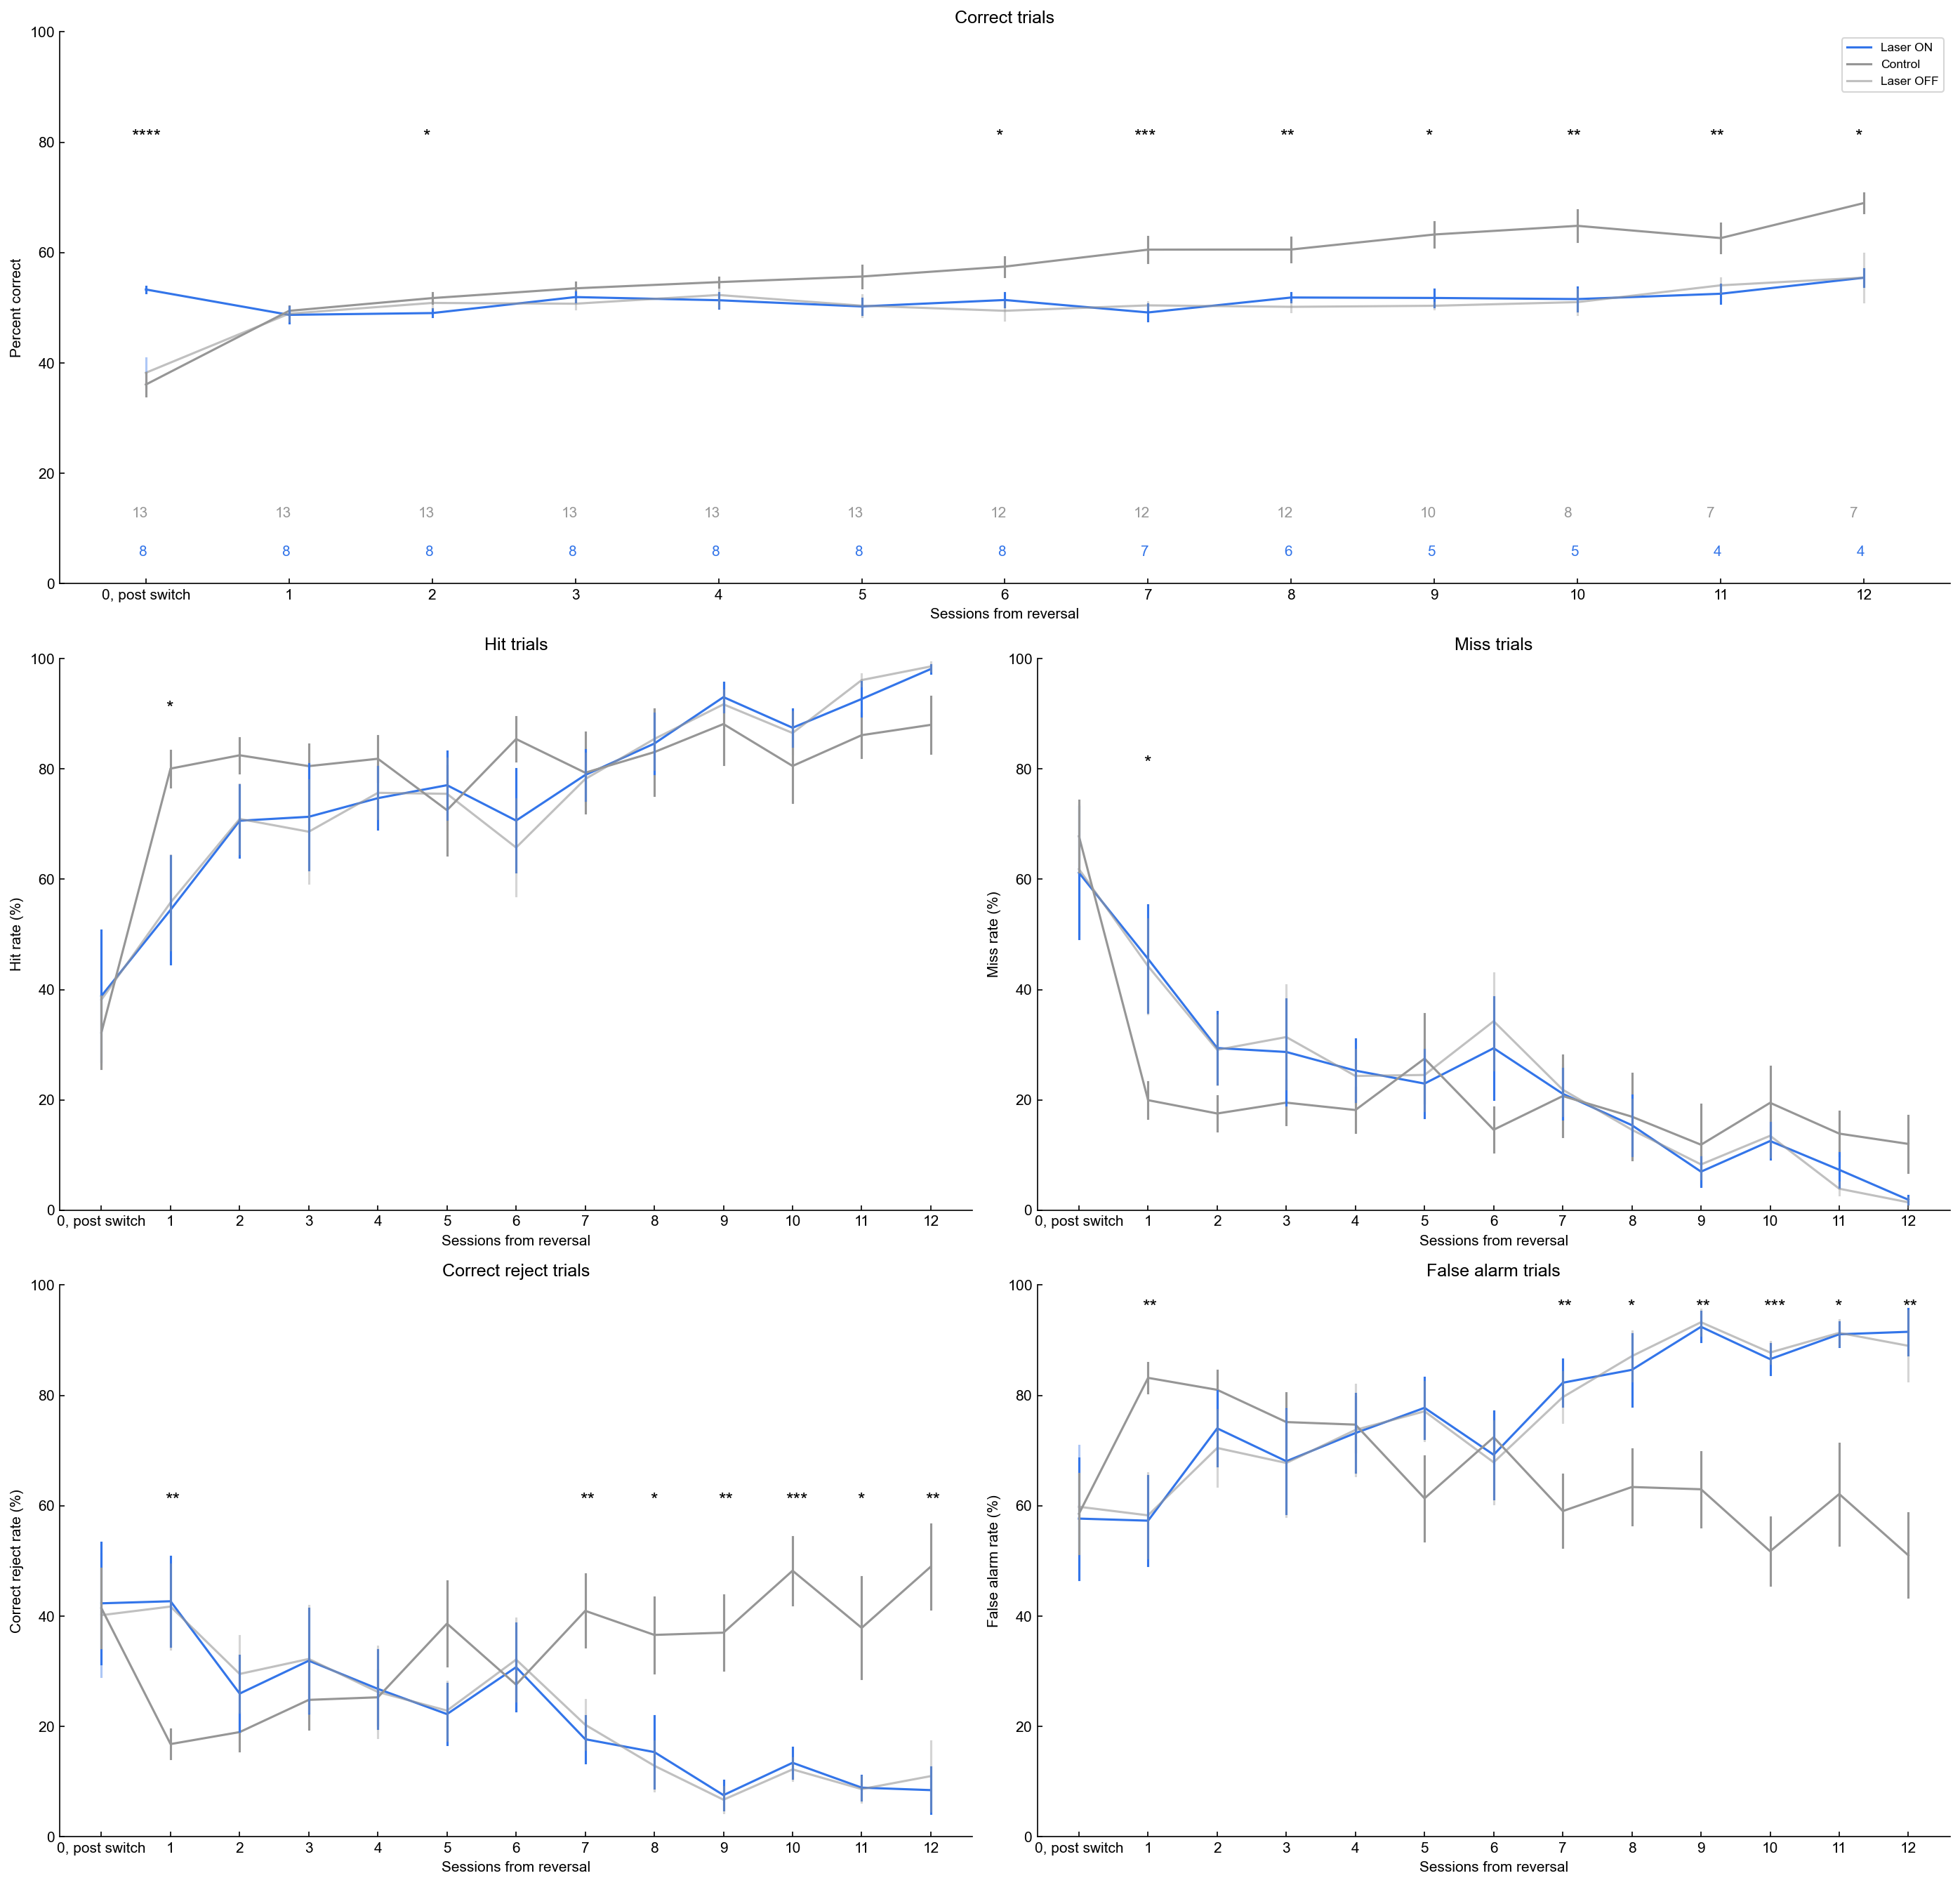

In [144]:
#fs = 18  # fontsize
#fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(16, 12))
#fig.tight_layout(pad=5)

fig,ax = plt.subplots(6,1)
fig.set_figheight(18)
fig.set_figwidth(28)

ax[0] = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=2)
ax[1] = plt.subplot2grid(shape=(3, 3), loc=(1, 0), colspan=1)
ax[2] = plt.subplot2grid(shape=(3, 3), loc=(1, 1), rowspan=1)
ax[3] = plt.subplot2grid((3, 3), (2, 0))
ax[4] = plt.subplot2grid((3, 3), (2, 1), colspan=1)
fig.tight_layout(pad=5)

#####################################################################
# CORRECT
#####################################################################
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_corr_noNan[i][:],opsin_pct_corr_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05

# computing and plotting significance for day0_postR
sig_day0_postR = 0
pval_day0_postR = 0
test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][0],opsin_day0_postR_ON[:][0])

pval_day0_postR = test_day0_postR.pvalue
sig_day0_postR = np.abs(pval_day0_postR) < 0.05
sig_where_day0_postR = np.where(sig_day0_postR) 
sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
sigYs_day0_postR = 80
if 0.01 < pval_day0_postR < 0.05:
    ax[0].text(0,sigYs_day0_postR, str('*'), size = 13)
if 0.005 < pval_day0_postR < 0.01:
    ax[0].text(0,sigYs_day0_postR, str('**'), size = 13)
if 0.001 < pval_day0_postR < 0.005:
    ax[0].text(0,sigYs_day0_postR, str('***'), size = 13)
if pval_day0_postR < 0.001:
    ax[0].text(-0.1,sigYs_day0_postR, str('****'), size = 13) 

# changing labels, accounting for 'days' before reversal
ax[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[0].set_xticklabels(['0, post switch', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)

# plotting opsin on/off and dual for days following reversal, MEAN AND SEM
ax[0].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_ON_mean[0], corrData_plot[1]), axis = None), color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
ax[0].plot(np.arange(0,13), np.concatenate((dual_day0_postR_OFF_mean[0], corrData_plot[0]), axis = None), color = GOOD_GREY, label = 'Control') # dualRec
ax[0].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_OFF_mean[0], corrData_plot[2]), axis = None), color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
ax[0].plot([days,days], [corrSEM_plot[0], corrSEM_plot[1]], color = GOOD_GREY) # opsin ON
ax[0].plot([days,days], [corrSEM_plot[2], corrSEM_plot[3]], color = LASER_COLOR) # control
ax[0].plot([days,days], [corrSEM_plot[4], corrSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF

ax[0].plot([0,0], [opsin_day0_postR_ON_SEMhi[0], opsin_day0_postR_ON_SEMlo[0]], color = LASER_COLOR ) # opsin ON
ax[0].plot([0,0], [opsin_day0_postR_OFF_SEMhi[0], opsin_day0_postR_OFF_SEMlo[0]], color = LASER_COLOR, alpha = 0.4 ) # opsin OFF
ax[0].plot([0,0], [dual_day0_postR_OFF_SEMhi[0], dual_day0_postR_OFF_SEMlo[0]], color = GOOD_GREY) # control


# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 80
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[0].text(i+0.935,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[0].text(i+0.92,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[0].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[0].text(i+0.86,sigYs, str('****'), size = 13)

ax[0].set_xlabel('Sessions from reversal')
ax[0].set_ylabel('Percent correct')
ax[0].set_title('Correct trials')
ax[0].legend()
ax[0].set_ylim(0,100)

# plotting # of days
ax[0].text(0-.05,5, num_nan_opsin[0], color = LASER_COLOR)
ax[0].text(0-.1,12, num_nan_dual[0], color = GOOD_GREY)
for i in range(12):
    ax[0].text(days[i]-.05,5, num_nan_opsin[i], color = LASER_COLOR)
    ax[0].text(days[i]-.1,12, num_nan_dual[i], color = GOOD_GREY)
print(days)

#####################################################################
# HIT
#####################################################################
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_hit_noNan[i][:],opsin_pct_hit_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05

# computing and plotting significance for day0_postR
sig_day0_postR = 0
pval_day0_postR = 0
test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][1],opsin_day0_postR_ON[:][1])

pval_day0_postR = test_day0_postR.pvalue
sig_day0_postR = np.abs(pval_day0_postR) < 0.05
sig_where_day0_postR = np.where(sig_day0_postR) 
sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
sigYs_day0_postR = 90
if 0.01 < pval_day0_postR < 0.05:
    ax[1].text(0,sigYs_day0_postR, str('*'), size = 13)
if 0.005 < pval_day0_postR < 0.01:
    ax[1].text(0,sigYs_day0_postR, str('**'), size = 13)
if 0.001 < pval_day0_postR < 0.005:
    ax[1].text(0,sigYs_day0_postR, str('***'), size = 13)
if pval_day0_postR < 0.001:
    ax[1].text(0,sigYs_day0_postR, str('****'), size = 13)    
    
# changing labels, accounting for 'days' before reversal
ax[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[1].set_xticklabels(['0, post switch', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)

# plotting opsin on/off and dual for days following reversal, MEAN AND SEM
ax[1].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_ON_mean[1], hitData_plot[1]), axis = None), color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
ax[1].plot(np.arange(0,13), np.concatenate((dual_day0_postR_OFF_mean[1], hitData_plot[0]), axis = None), color = GOOD_GREY, label = 'Control') # dualRec
ax[1].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_OFF_mean[1], hitData_plot[2]), axis = None), color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
ax[1].plot([days,days], [hitSEM_plot[0], hitSEM_plot[1]], color = GOOD_GREY) # opsin ON
ax[1].plot([days,days], [hitSEM_plot[2], hitSEM_plot[3]], color = LASER_COLOR) # control
ax[1].plot([days,days], [hitSEM_plot[4], hitSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF


ax[1].plot([0,0], [opsin_day0_postR_ON_SEMhi[1], opsin_day0_postR_ON_SEMlo[1]], color = LASER_COLOR ) # opsin ON
ax[1].plot([0,0], [opsin_day0_postR_OFF_SEMhi[1], opsin_day0_postR_OFF_SEMlo[1]], color = LASER_COLOR, alpha = 0.4 ) # opsin OFF
ax[1].plot([0,0], [dual_day0_postR_OFF_SEMhi[1], dual_day0_postR_OFF_SEMlo[1]], color = GOOD_GREY) # control

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 90
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[1].text(i+0.935,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[1].text(i+0.92,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[1].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[1].text(i+0.86,sigYs, str('****'), size = 13)

ax[1].set_xlabel('Sessions from reversal')
ax[1].set_ylabel('Hit rate (%)')
ax[1].set_title('Hit trials')
ax[1].set_ylim(0,100)

#####################################################################
# MISS
#####################################################################
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_miss_noNan[i][:],opsin_pct_miss_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
   
# computing and plotting significance for day0_postR
sig_day0_postR = 0
pval_day0_postR = 0
test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][2],opsin_day0_postR_ON[:][2])

pval_day0_postR = test_day0_postR.pvalue
sig_day0_postR = np.abs(pval_day0_postR) < 0.05
sig_where_day0_postR = np.where(sig_day0_postR) 
sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
sigYs_day0_postR = 80
if 0.01 < pval_day0_postR < 0.05:
    ax[2].text(0,sigYs_day0_postR, str('*'), size = 13)
if 0.005 < pval_day0_postR < 0.01:
    ax[2].text(0,sigYs_day0_postR, str('**'), size = 13)
if 0.001 < pval_day0_postR < 0.005:
    ax[2].text(0,sigYs_day0_postR, str('***'), size = 13)
if pval_day0_postR < 0.001:
    ax[2].text(0,sigYs_day0_postR, str('****'), size = 13)      

# changing labels, accounting for 'days' before reversal
ax[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[2].set_xticklabels(['0, post switch', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)

# plotting opsin on/off and dual for days following reversal, MEAN AND SEM
ax[2].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_ON_mean[2], missData_plot[1]), axis = None), color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
ax[2].plot(np.arange(0,13), np.concatenate((dual_day0_postR_OFF_mean[2], missData_plot[0]), axis = None), color = GOOD_GREY, label = 'Control') # dualRec
ax[2].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_OFF_mean[2], missData_plot[2]), axis = None), color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
ax[2].plot([days,days], [missSEM_plot[0], missSEM_plot[1]], color = GOOD_GREY) # opsin ON
ax[2].plot([days,days], [missSEM_plot[2], missSEM_plot[3]], color = LASER_COLOR) # control
ax[2].plot([days,days], [missSEM_plot[4], missSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF


ax[2].plot([0,0], [opsin_day0_postR_ON_SEMhi[2], opsin_day0_postR_ON_SEMlo[2]], color = LASER_COLOR ) # opsin ON
ax[2].plot([0,0], [opsin_day0_postR_OFF_SEMhi[2], opsin_day0_postR_OFF_SEMlo[2]], color = LASER_COLOR, alpha = 0.4 ) # opsin OFF
ax[2].plot([0,0], [dual_day0_postR_OFF_SEMhi[2], dual_day0_postR_OFF_SEMlo[2]], color = GOOD_GREY) # control

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 80
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[2].text(i+0.935,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[2].text(i+0.92,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[2].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[2].text(i+0.86,sigYs, str('****'), size = 13)

ax[2].set_xlabel('Sessions from reversal')
ax[2].set_ylabel('Miss rate (%)')
ax[2].set_title('Miss trials')
ax[2].set_ylim(0,100)

#####################################################################
# CORRECT REJECT
#####################################################################
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_creject_noNan[i][:],opsin_pct_creject_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
    
# computing and plotting significance for day0_postR
sig_day0_postR = 0
pval_day0_postR = 0
test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][3],opsin_day0_postR_ON[:][3])

pval_day0_postR = test_day0_postR.pvalue
sig_day0_postR = np.abs(pval_day0_postR) < 0.05
sig_where_day0_postR = np.where(sig_day0_postR) 
sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
sigYs_day0_postR = 60
if 0.01 < pval_day0_postR < 0.05:
    ax[3].text(0,sigYs_day0_postR, str('*'))
if 0.005 < pval_day0_postR < 0.01:
    ax[3].text(0,sigYs_day0_postR, str('**'))
if 0.001 < pval_day0_postR < 0.005:
    ax[3].text(0,sigYs_day0_postR, str('***'))
if pval_day0_postR < 0.001:
    ax[3].text(0,sigYs_day0_postR, str('****'))
  
# changing labels, accounting for 'days' before reversal
ax[3].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[3].set_xticklabels(['0, post switch', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)
#ax[3].axvline(-0.5, color = 'k', linestyle = 'dashed', label = 'Reversal')

# plotting opsin on/off and dual for days following reversal, MEAN AND SEM
ax[3].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_ON_mean[3], crejectData_plot[1]), axis = None), color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
ax[3].plot(np.arange(0,13), np.concatenate((dual_day0_postR_OFF_mean[3], crejectData_plot[0]), axis = None), color = GOOD_GREY, label = 'Control') # dualRec
ax[3].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_OFF_mean[3], crejectData_plot[2]), axis = None), color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
ax[3].plot([days,days], [crejectSEM_plot[0], crejectSEM_plot[1]], color = GOOD_GREY) # opsin ON
ax[3].plot([days,days], [crejectSEM_plot[2], crejectSEM_plot[3]], color = LASER_COLOR) # control
ax[3].plot([days,days], [crejectSEM_plot[4], crejectSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF


ax[3].plot([0,0], [opsin_day0_postR_ON_SEMhi[3], opsin_day0_postR_ON_SEMlo[3]], color = LASER_COLOR ) # opsin ON
ax[3].plot([0,0], [opsin_day0_postR_OFF_SEMhi[3], opsin_day0_postR_OFF_SEMlo[3]], color = LASER_COLOR, alpha = 0.4 ) # opsin OFF
ax[3].plot([0,0], [dual_day0_postR_OFF_SEMhi[3], dual_day0_postR_OFF_SEMlo[3]], color = GOOD_GREY) # control

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 60
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[3].text(i+0.935,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[3].text(i+0.92,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[3].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[3].text(i+0.86,sigYs, str('****'), size = 13)

ax[3].set_xlabel('Sessions from reversal')
ax[3].set_ylabel('Correct reject rate (%)')
ax[3].set_title('Correct reject trials')
ax[3].set_ylim(0,100)

#####################################################################
# FALSE ALARM
#####################################################################
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_falarm_noNan[i][:],opsin_pct_falarm_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05 

# computing and plotting significance for day0_postR
sig_day0_postR = 0
pval_day0_postR = 0
test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][4],opsin_day0_postR_ON[:][4])

pval_day0_postR = test_day0_postR.pvalue
sig_day0_postR = np.abs(pval_day0_postR) < 0.05
sig_where_day0_postR = np.where(sig_day0_postR) 
sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
sigYs_day0_postR = 95
if 0.01 < pval_day0_postR < 0.05:
    ax[4].text(0,sigYs_day0_postR, str('*'), size = 13)
if 0.005 < pval_day0_postR < 0.01:
    ax[4].text(0,sigYs_day0_postR, str('**'), size = 13)
if 0.001 < pval_day0_postR < 0.005:
    ax[4].text(0,sigYs_day0_postR, str('***'), size = 13)
if pval_day0_postR < 0.001:
    ax[4].text(0,sigYs, str('****'), size = 13)

# changing labels, accounting for 'days' before reversal
ax[4].set_xticks([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[4].set_xticklabels(['0, post switch', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)

# plotting opsin on/off and dual for days following reversal, MEAN AND SEM
ax[4].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_ON_mean[4], falarmData_plot[1]), axis = None), color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
ax[4].plot(np.arange(0,13), np.concatenate((dual_day0_postR_OFF_mean[4], falarmData_plot[0]), axis = None), color = GOOD_GREY, label = 'Control') # dualRec
ax[4].plot(np.arange(0,13), np.concatenate((opsin_day0_postR_OFF_mean[4], falarmData_plot[2]), axis = None), color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
ax[4].plot([days,days], [falarmSEM_plot[0], falarmSEM_plot[1]], color = GOOD_GREY) # opsin ON
ax[4].plot([days,days], [falarmSEM_plot[2], falarmSEM_plot[3]], color = LASER_COLOR) # control
ax[4].plot([days,days], [falarmSEM_plot[4], falarmSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF


ax[4].plot([0,0], [opsin_day0_postR_ON_SEMhi[4], opsin_day0_postR_ON_SEMlo[4]], color = LASER_COLOR ) # opsin ON
ax[4].plot([0,0], [opsin_day0_postR_OFF_SEMhi[4], opsin_day0_postR_OFF_SEMlo[4]], color = LASER_COLOR, alpha = 0.4 ) # opsin OFF
ax[4].plot([0,0], [dual_day0_postR_OFF_SEMhi[4], dual_day0_postR_OFF_SEMlo[4]], color = GOOD_GREY) # control

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 95
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[4].text(i+0.935,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[4].text(i+0.92,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[4].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[4].text(i+0.86,sigYs, str('****'), size = 13)

ax[4].set_xlabel('Sessions from reversal')
ax[4].set_ylabel('False alarm rate (%)')
ax[4].set_title('False alarm trials')
ax[4].set_ylim(0,100)
#####################################################################

plt.tight_layout()
plt.savefig('Opsin Effects Across Sessions, all of post reversal.pdf')
plt.show()

In [49]:
dual_beforeDay1_falarm[0]

[52.78189256497171, 71.25521563520181, 51.35481347260997]

In [45]:
dual_beforeDay1_falarm[1][0]

63.99681247556747

In [46]:
opsin_beforeDay1_OFF_falarm

([56.653280138238166, 70.31043782324039, 48.70242235801078],
 [73.04299985208803, 84.2347120391832, 70.94589466537782])

In [149]:
sessionfile

NameError: name 'sessionfile' is not defined

## Now, take above results, break up for each animal and then print out

In [15]:
didnotlearnopsinanimals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
dualrecanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108'] # ,'DS_15','DS_19'
print(np.shape(dual_pct_corr_noNan))

(12,)


Control Animal: BS_40


<Figure size 900x600 with 0 Axes>

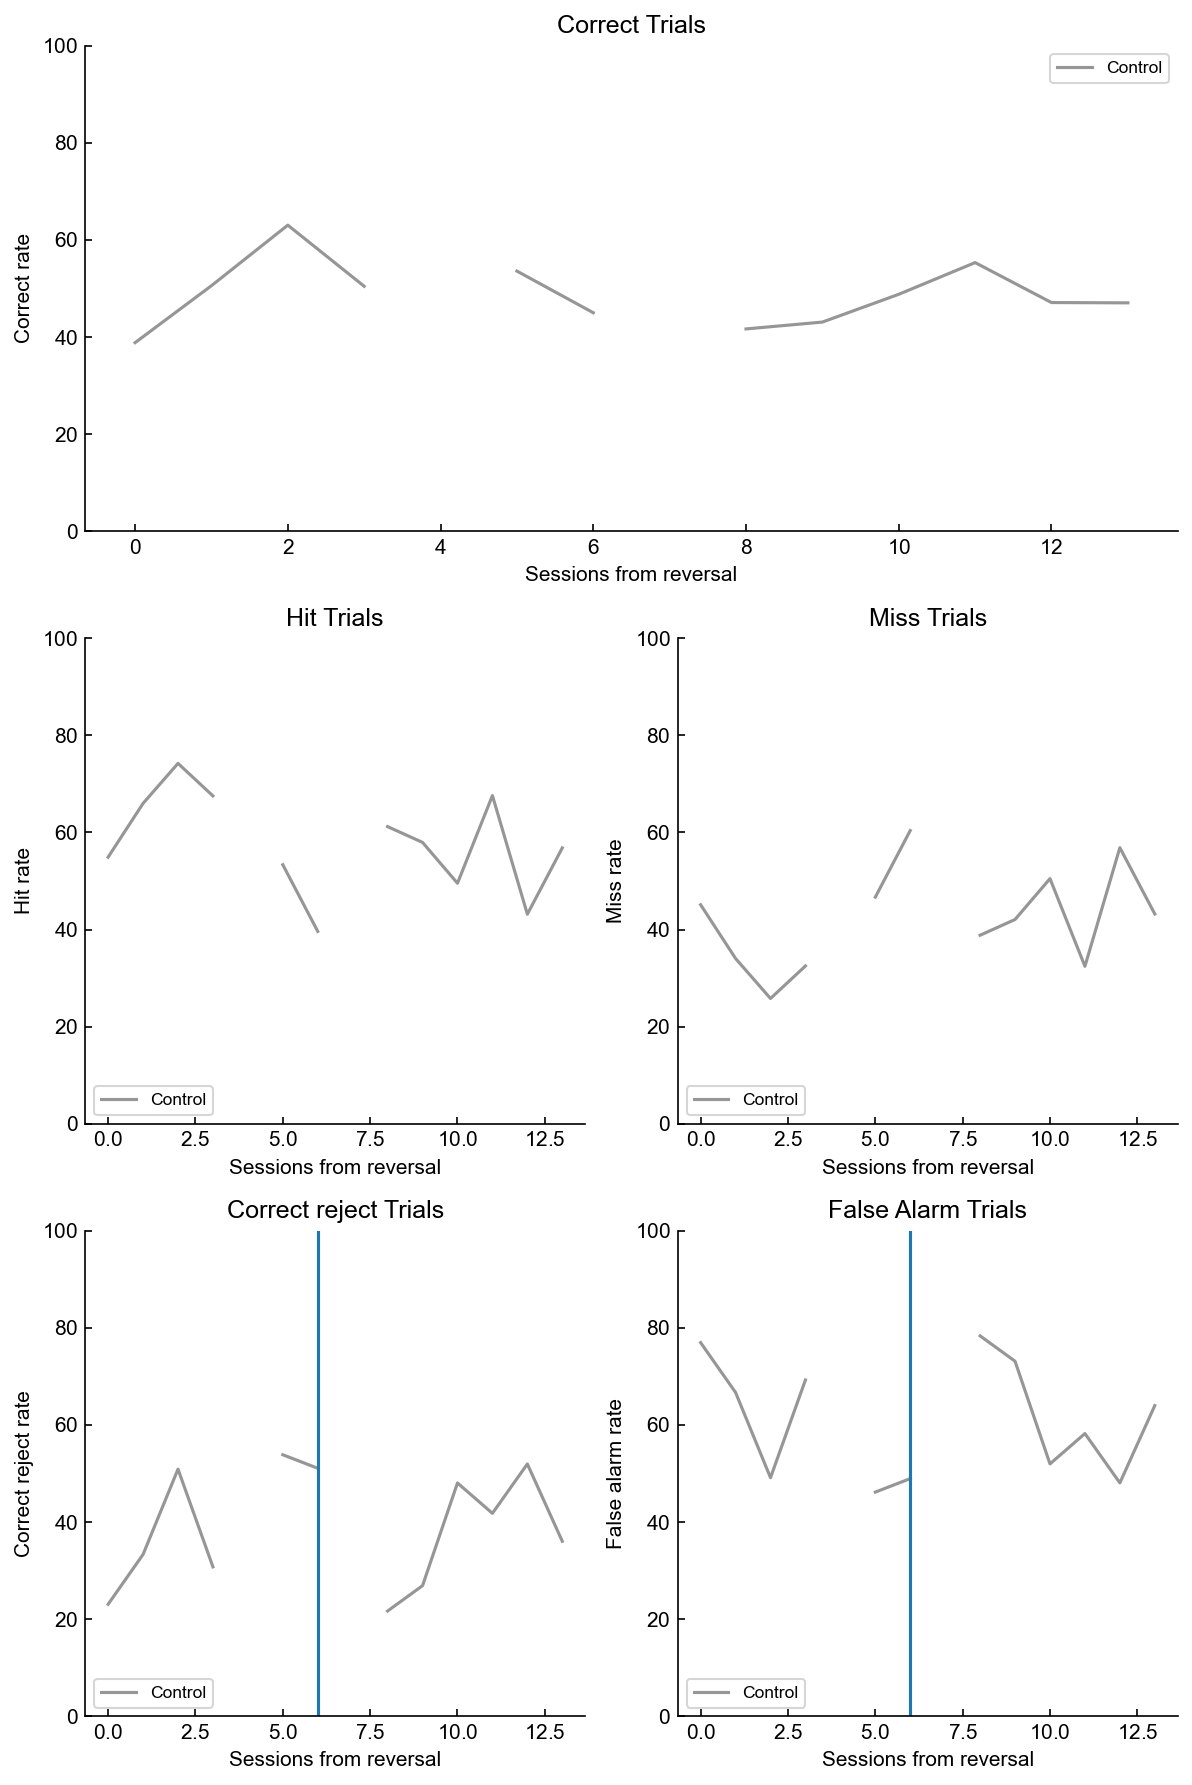

Control Animal: BS_41


<Figure size 900x600 with 0 Axes>

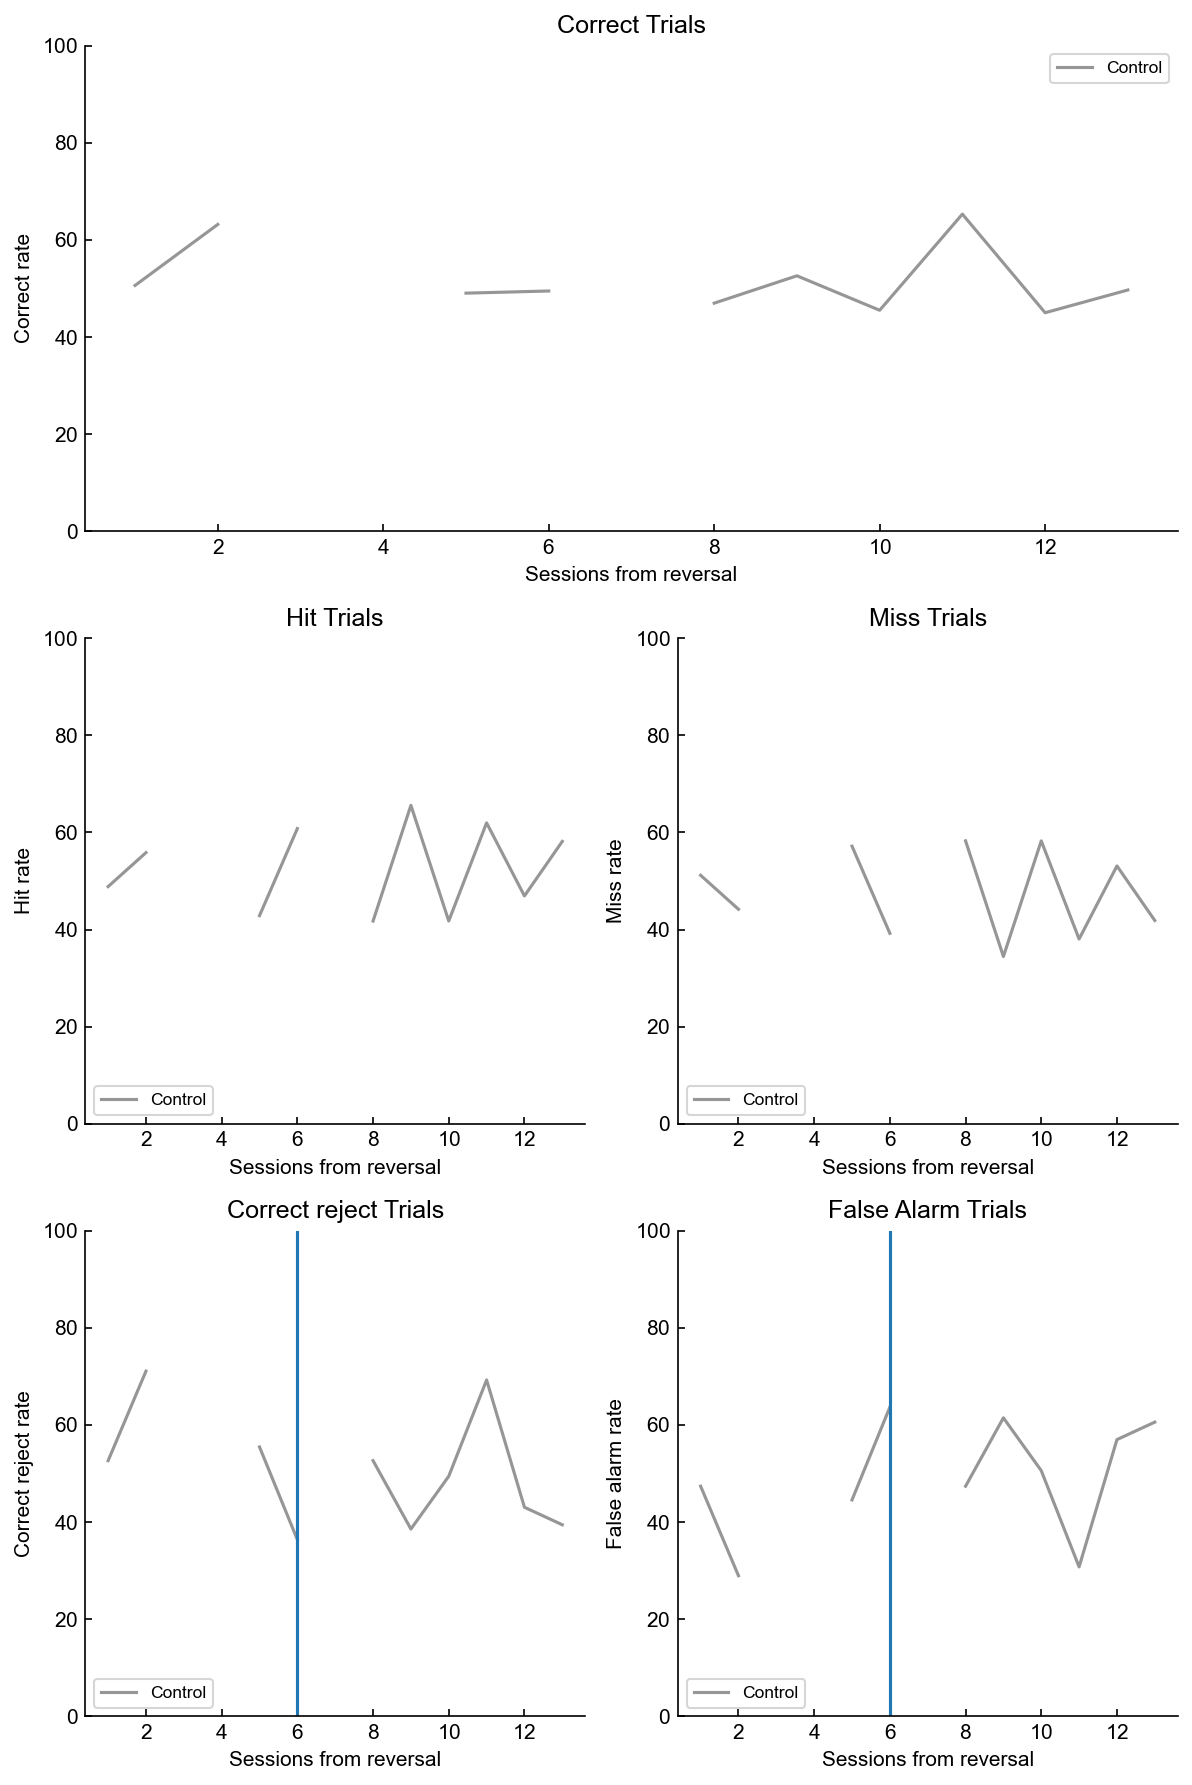

Control Animal: BS_42


<Figure size 900x600 with 0 Axes>

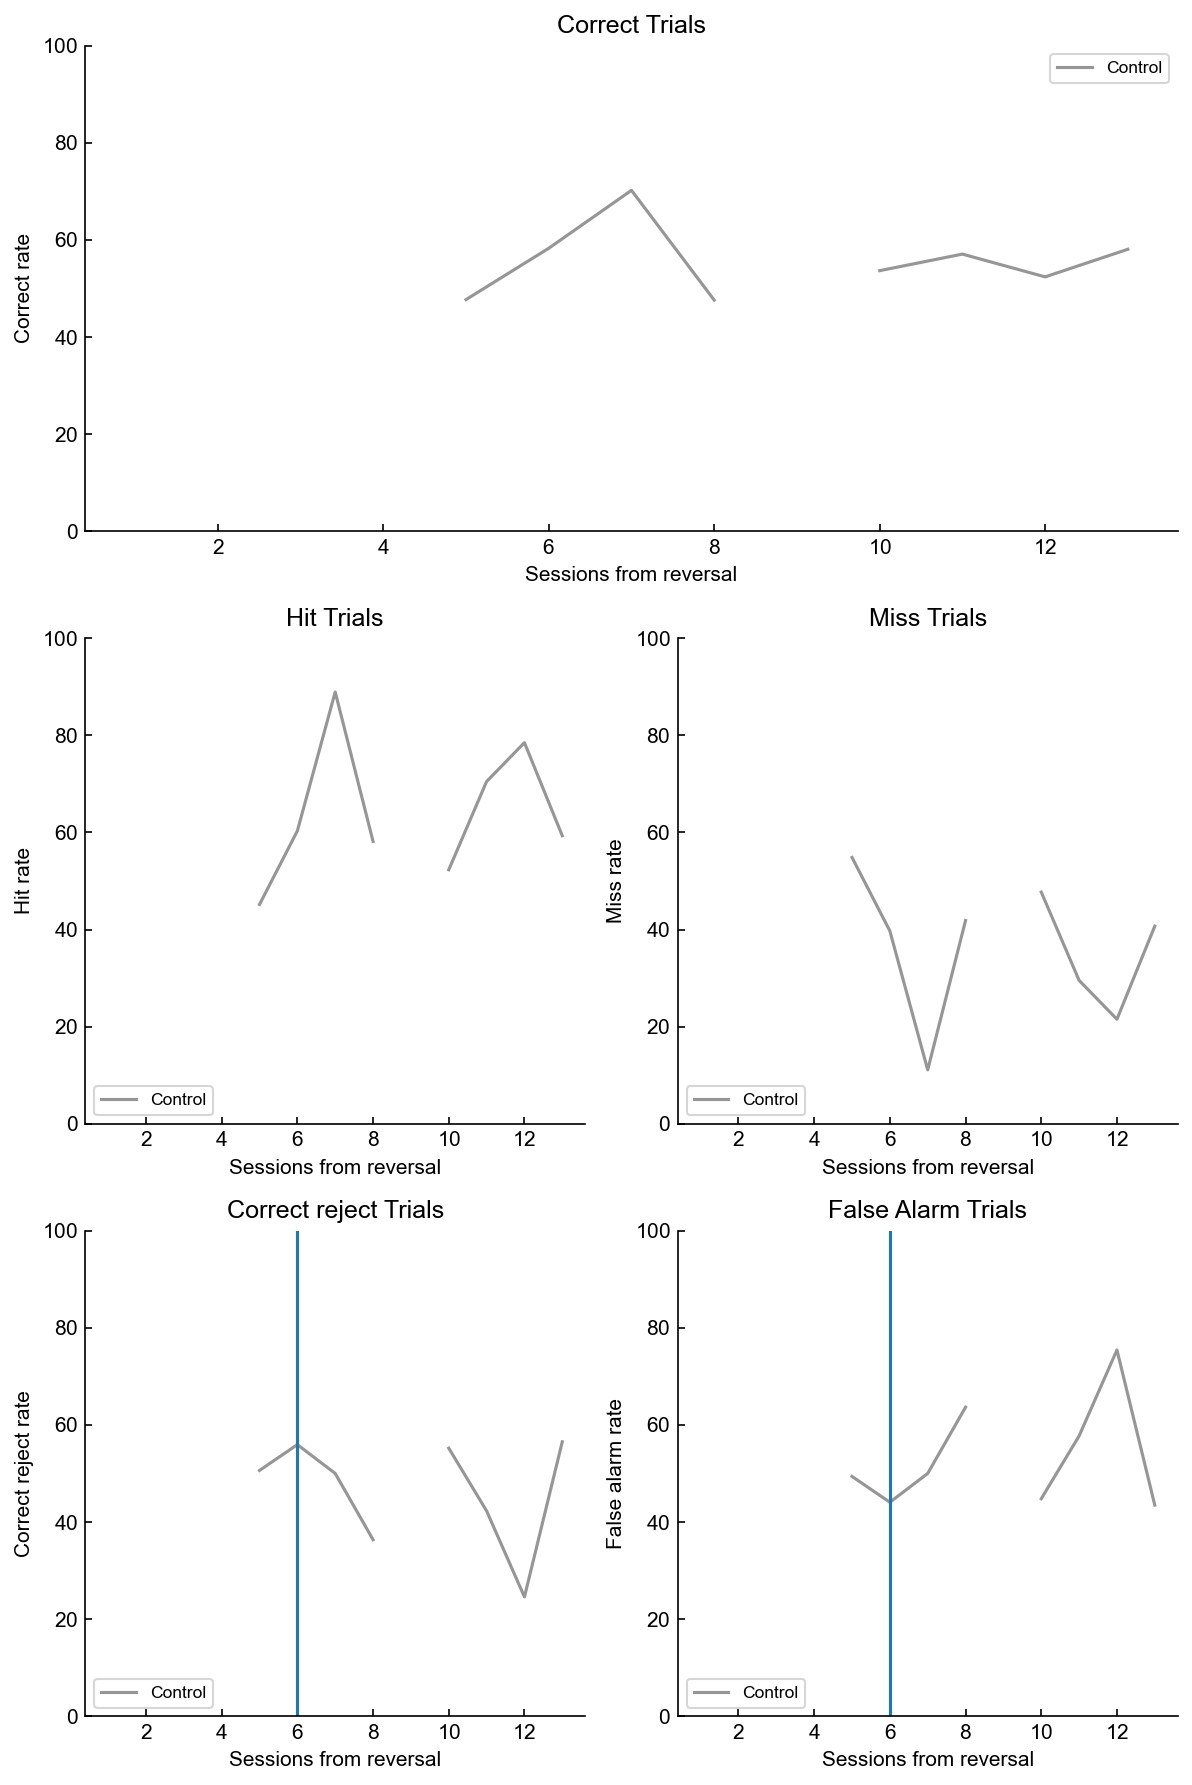

Control Animal: BS_49


<Figure size 900x600 with 0 Axes>

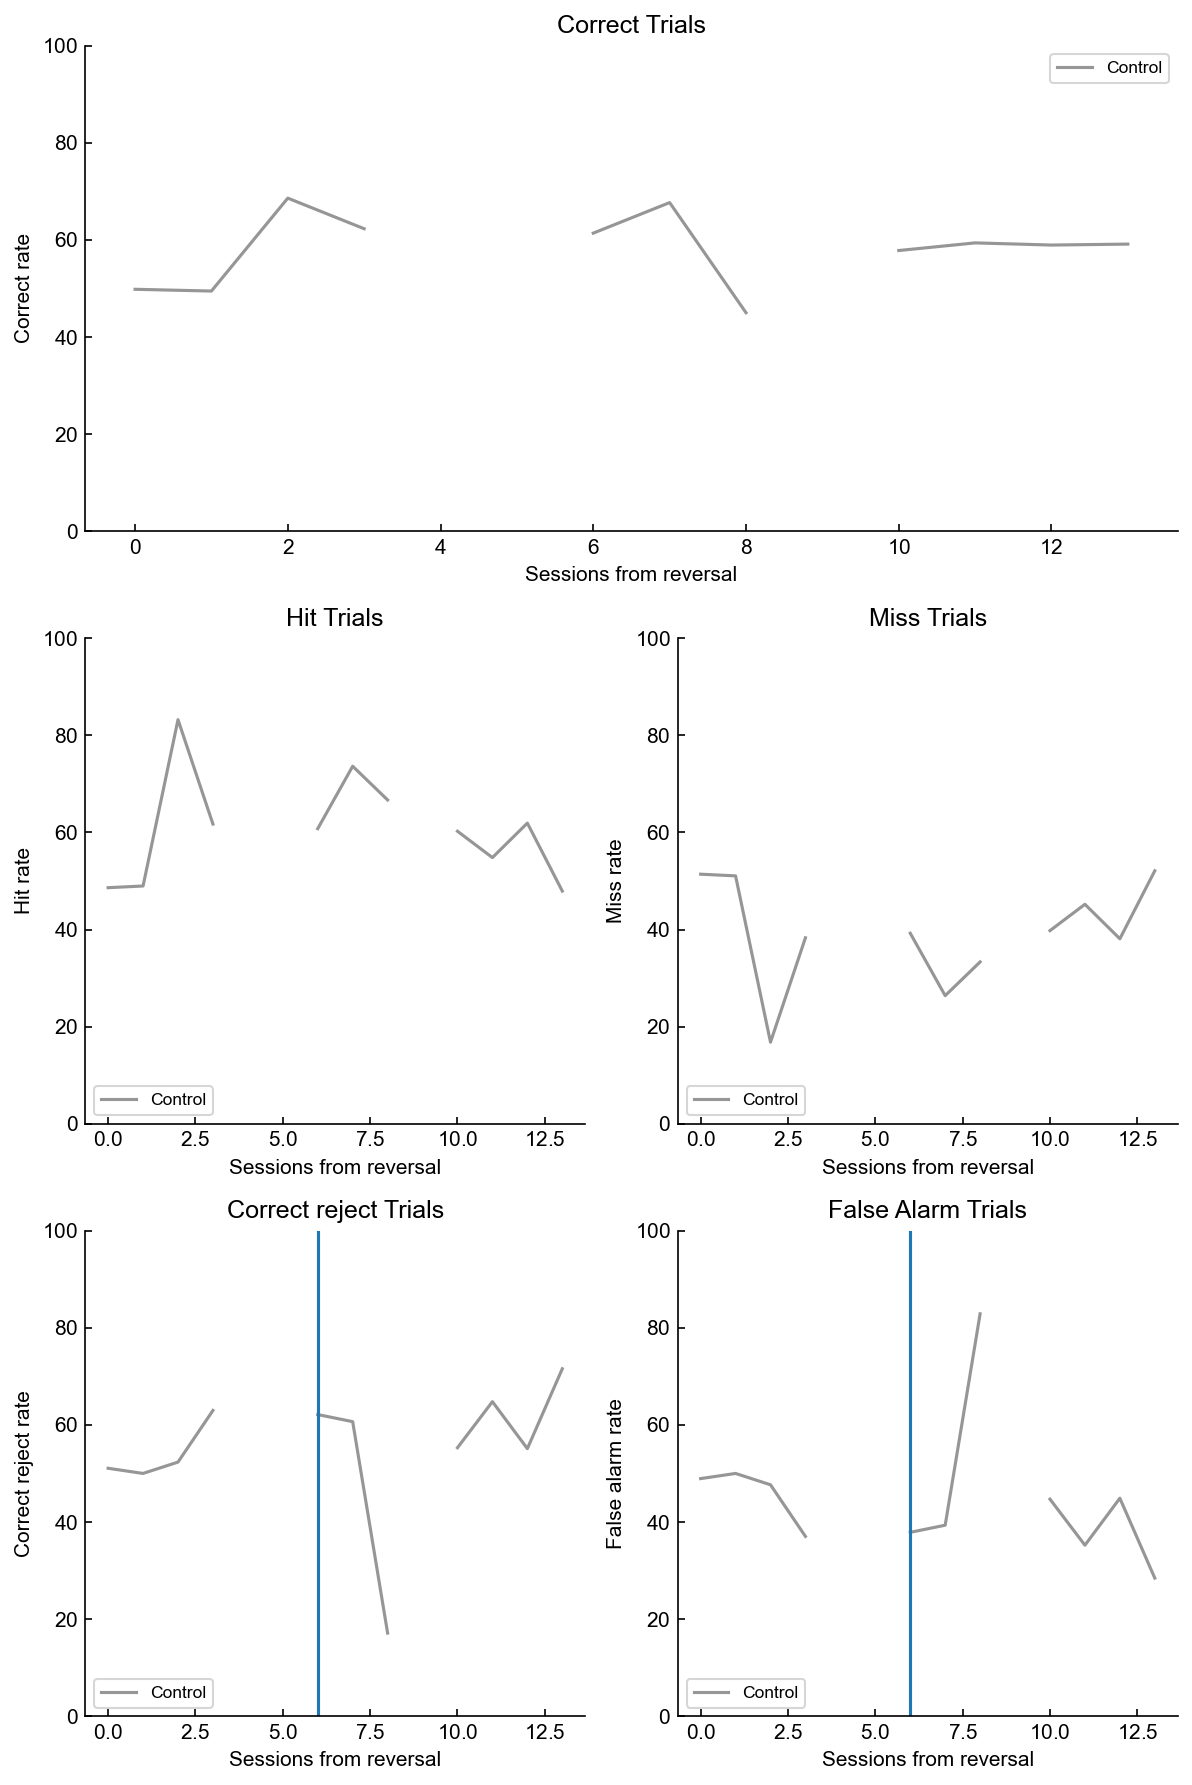

Control Animal: BS_50


<Figure size 900x600 with 0 Axes>

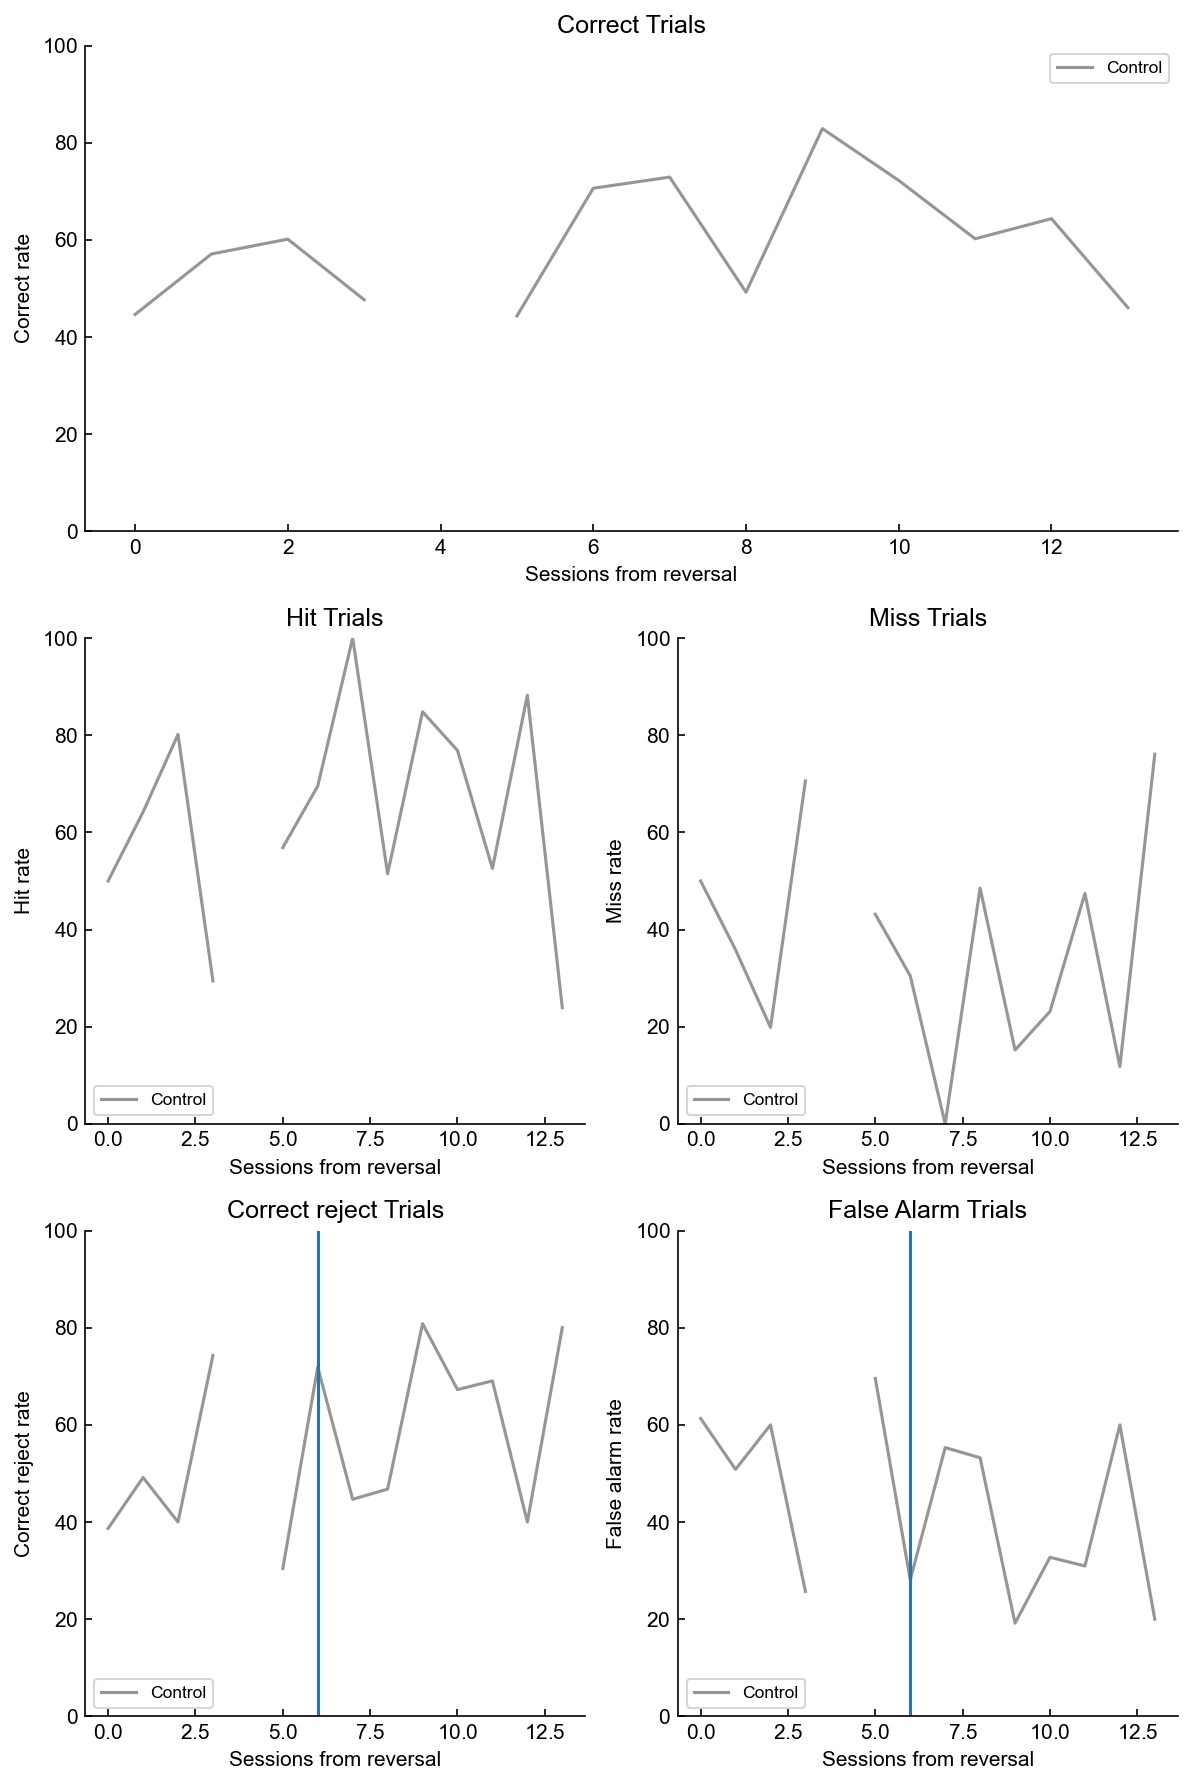

Control Animal: BS_51


<Figure size 900x600 with 0 Axes>

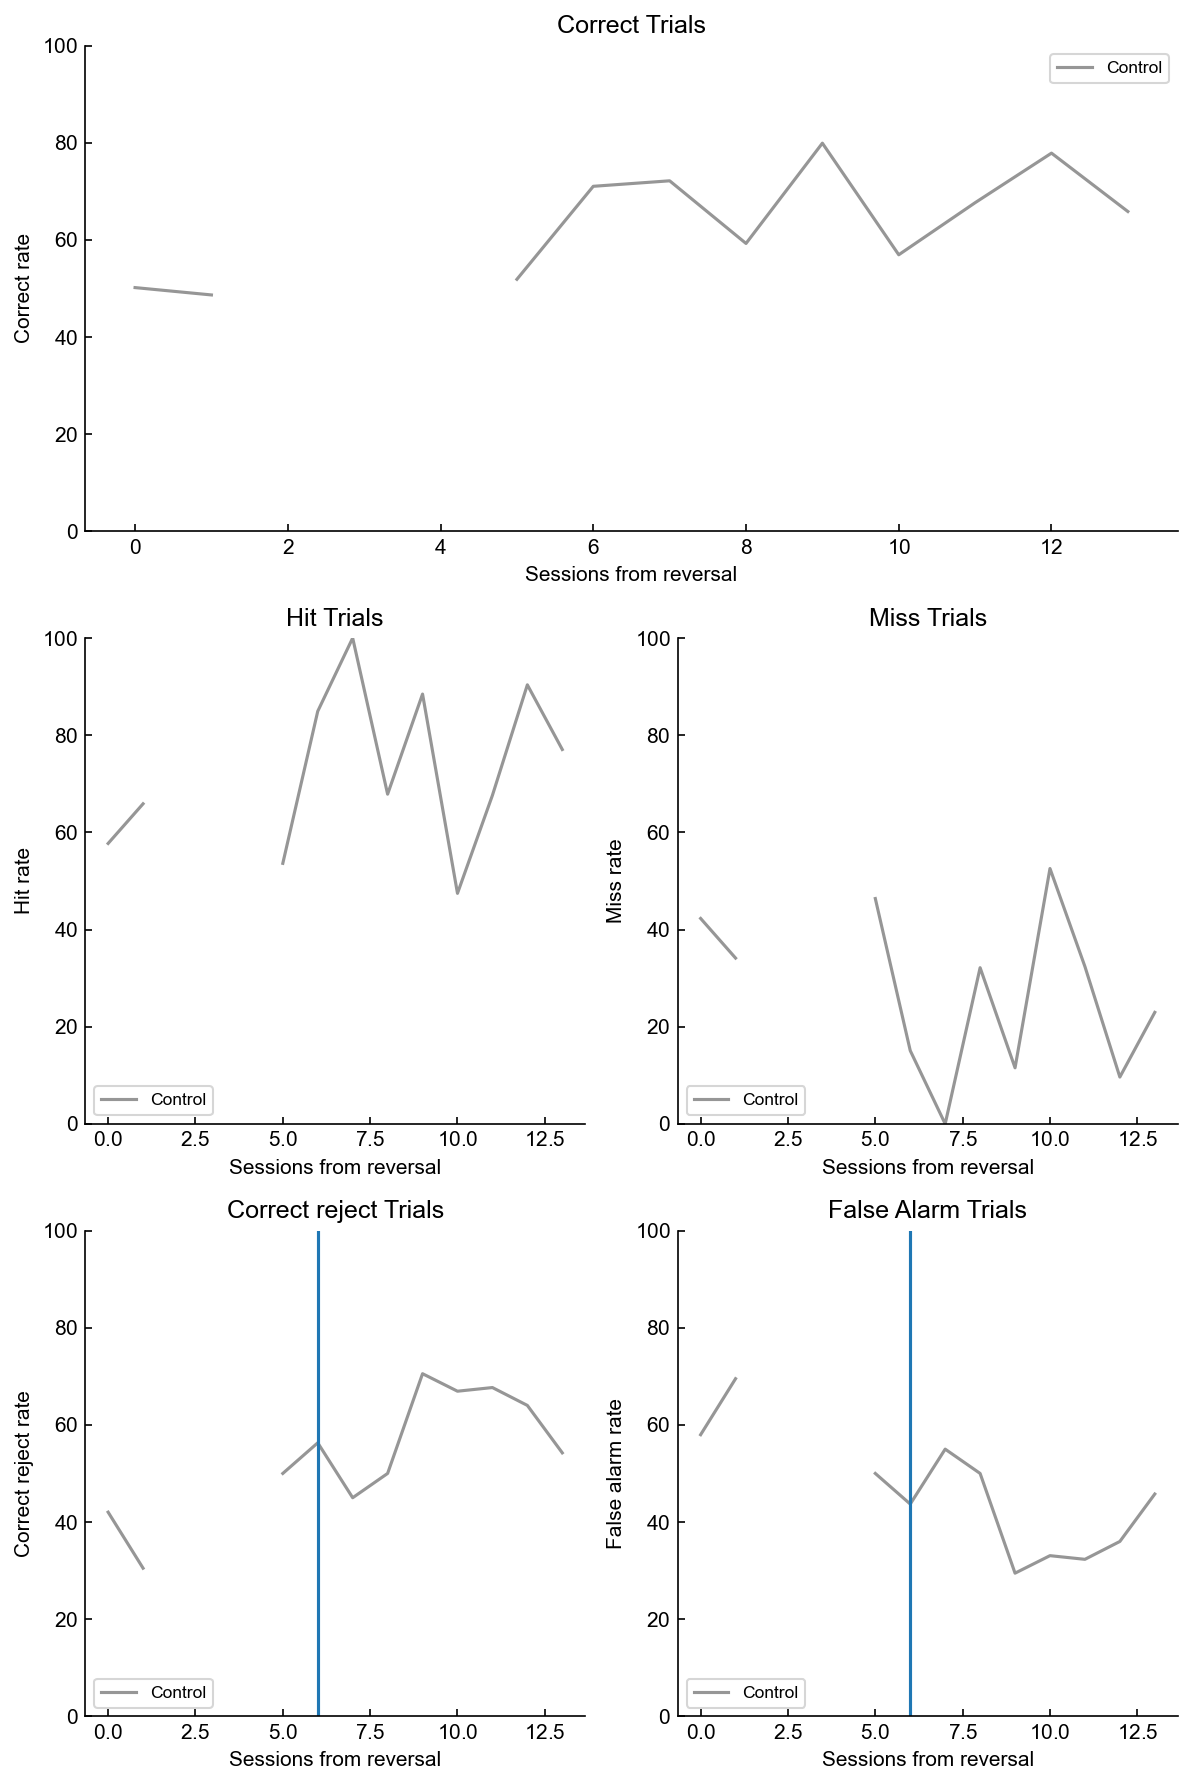

Control Animal: BS_56


<Figure size 900x600 with 0 Axes>

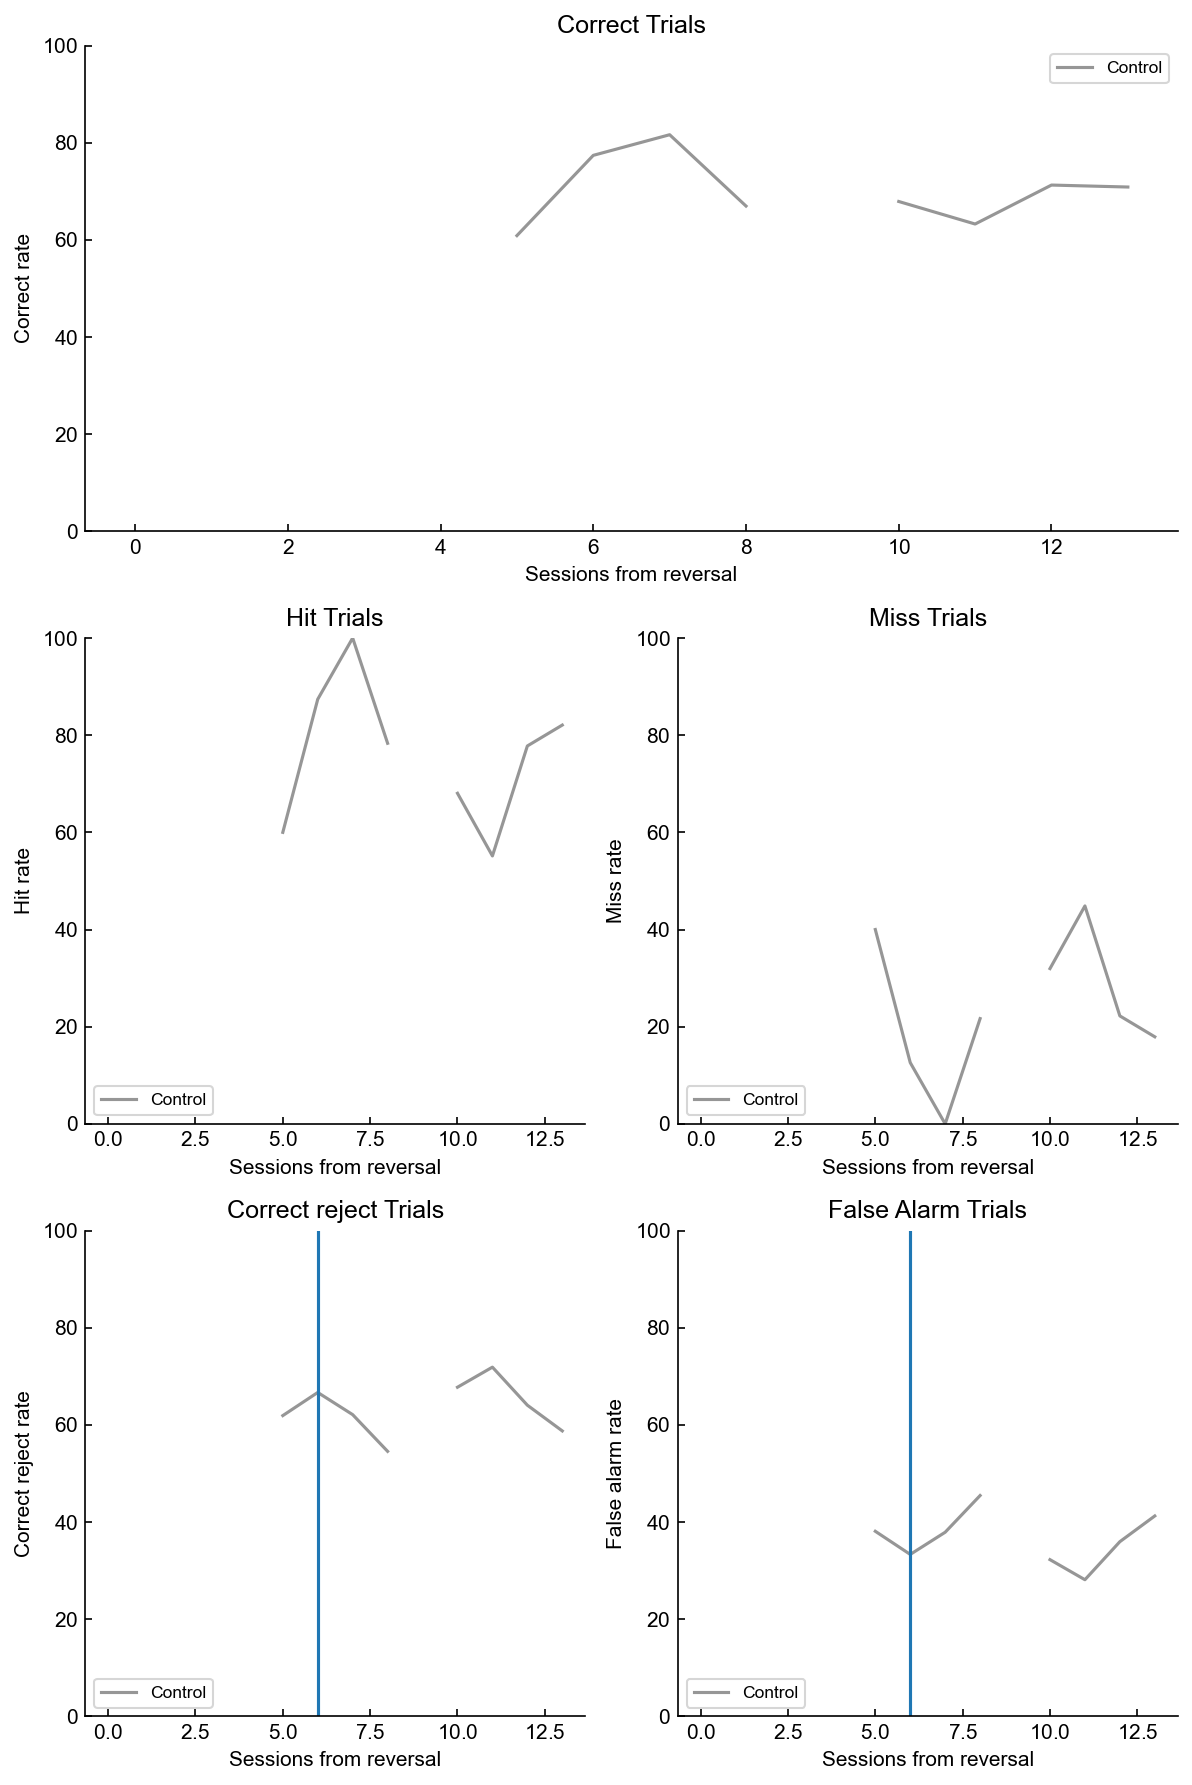

Control Animal: BS_59


<Figure size 900x600 with 0 Axes>

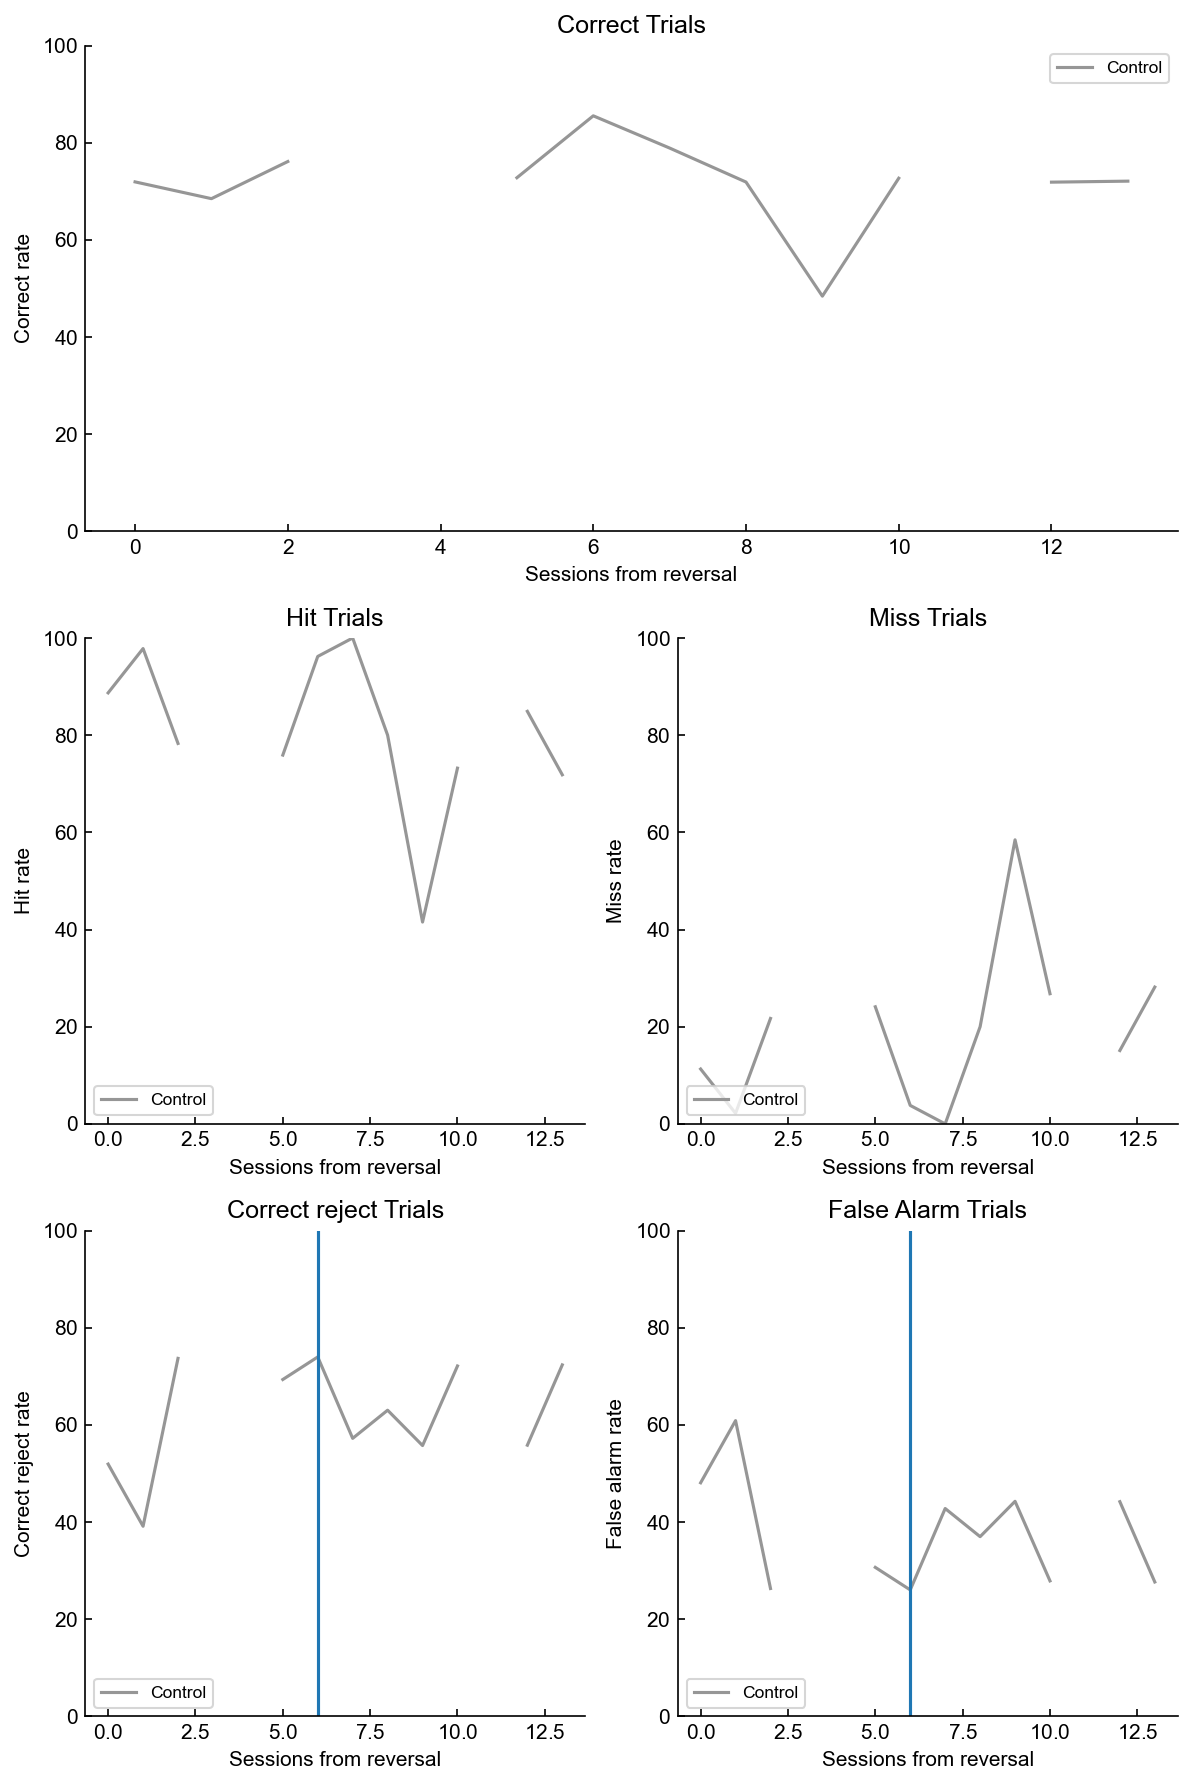

Control Animal: BS_61


<Figure size 900x600 with 0 Axes>

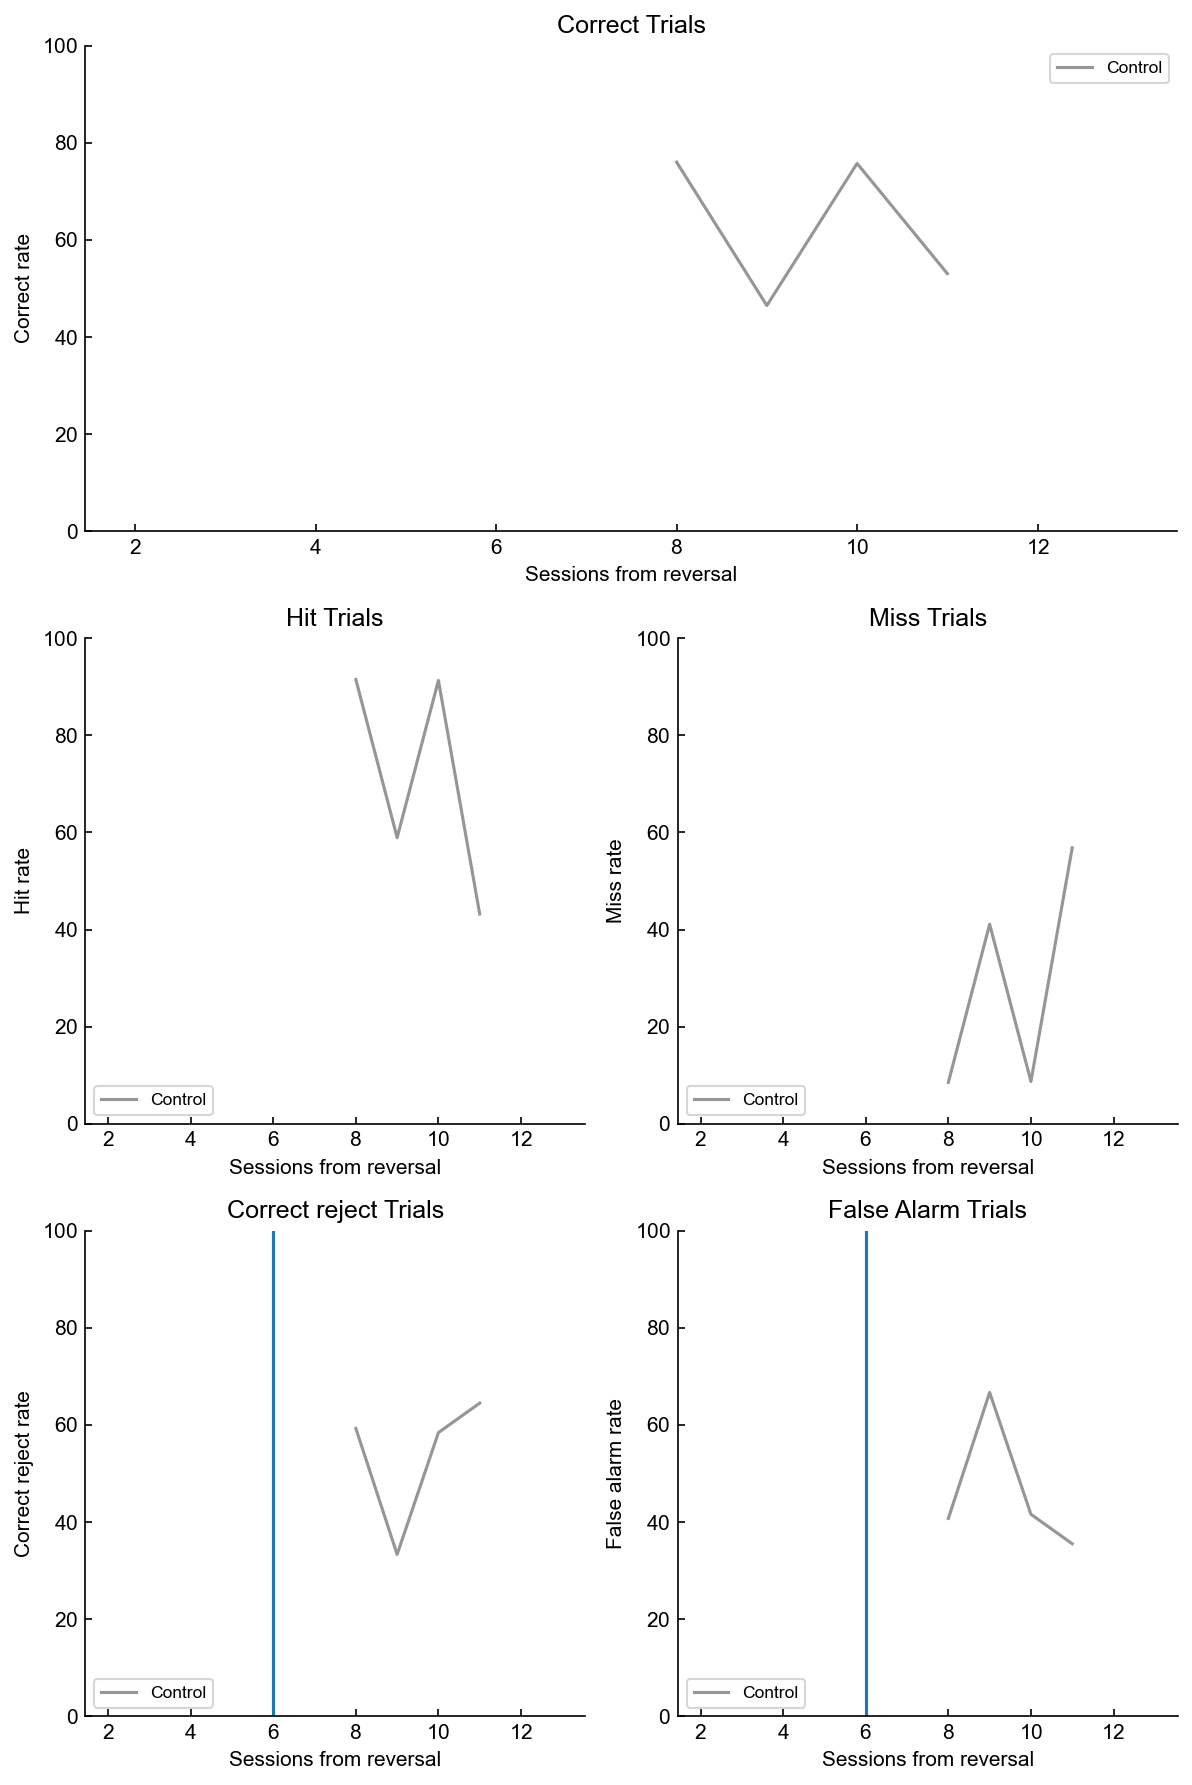

Control Animal: BS_67


<Figure size 900x600 with 0 Axes>

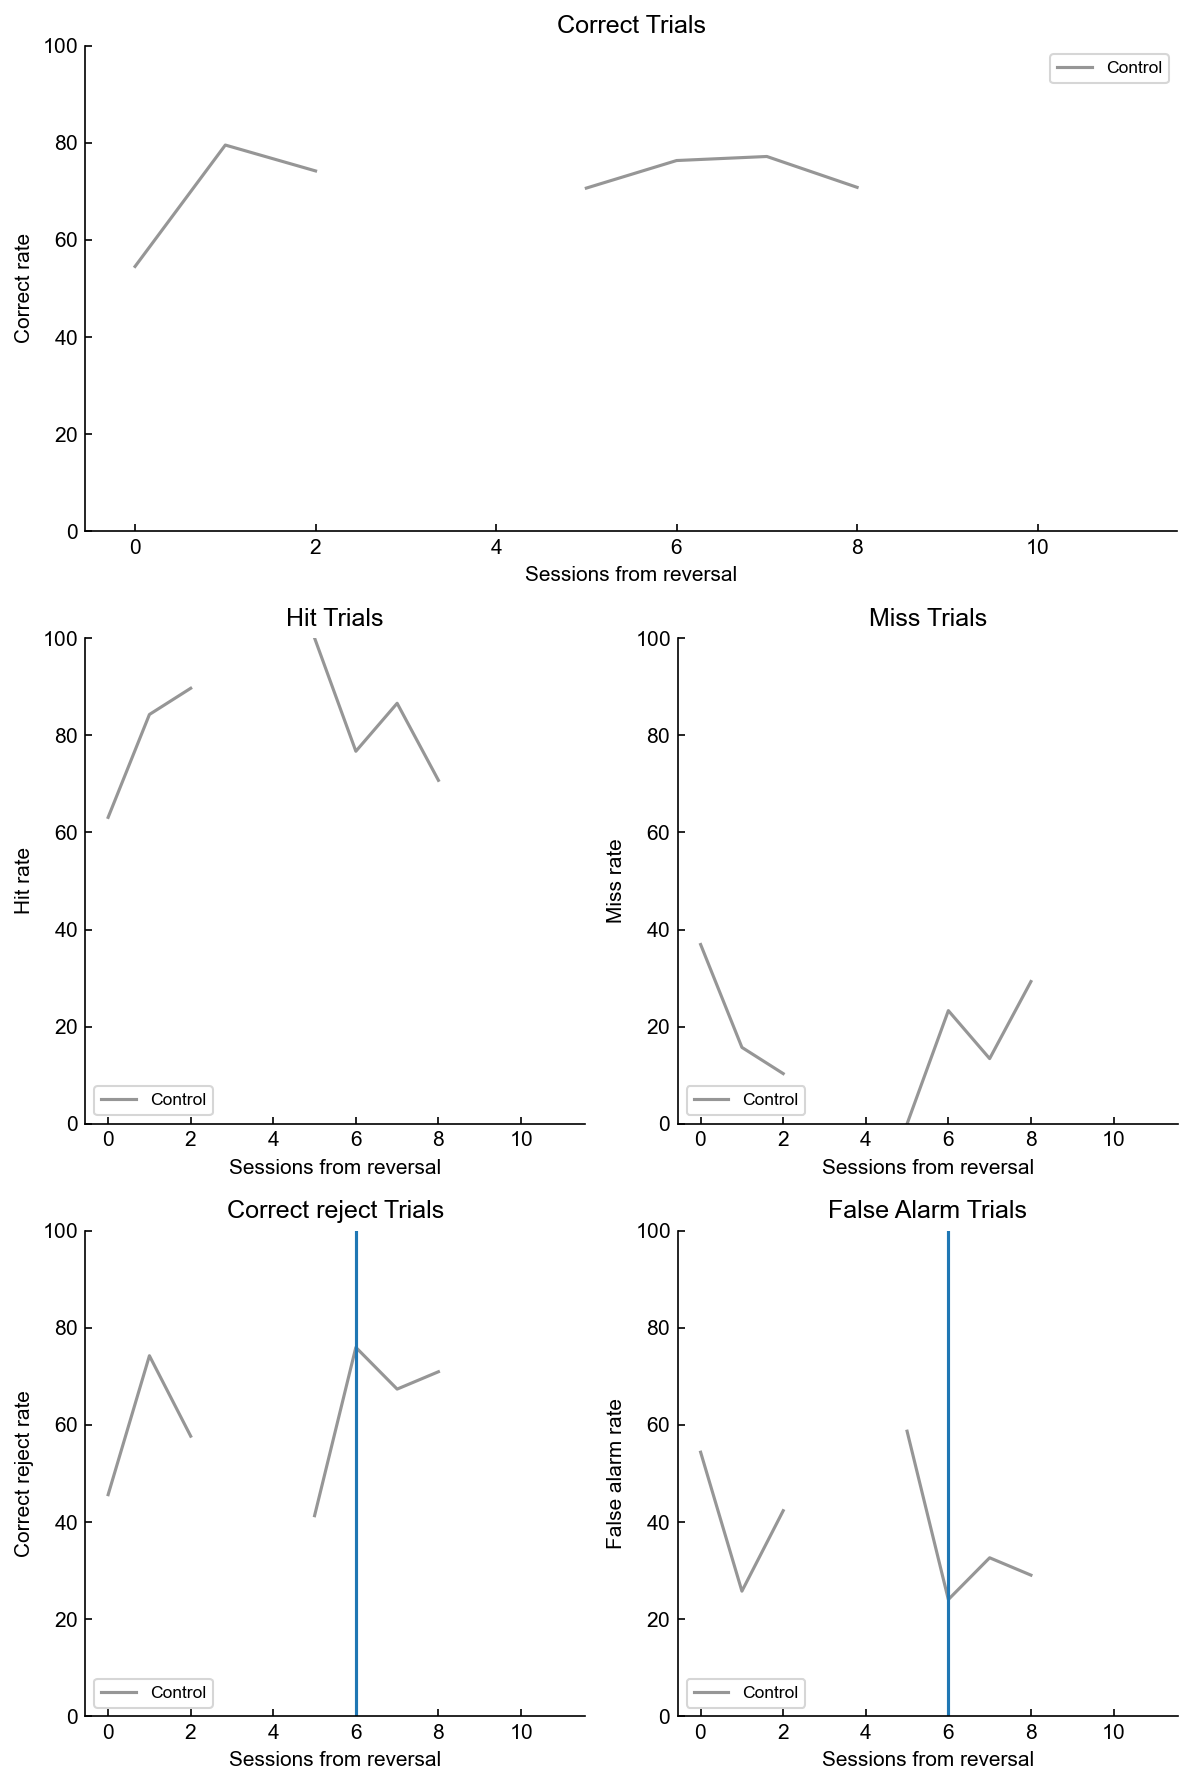

Control Animal: BS_70


<Figure size 900x600 with 0 Axes>

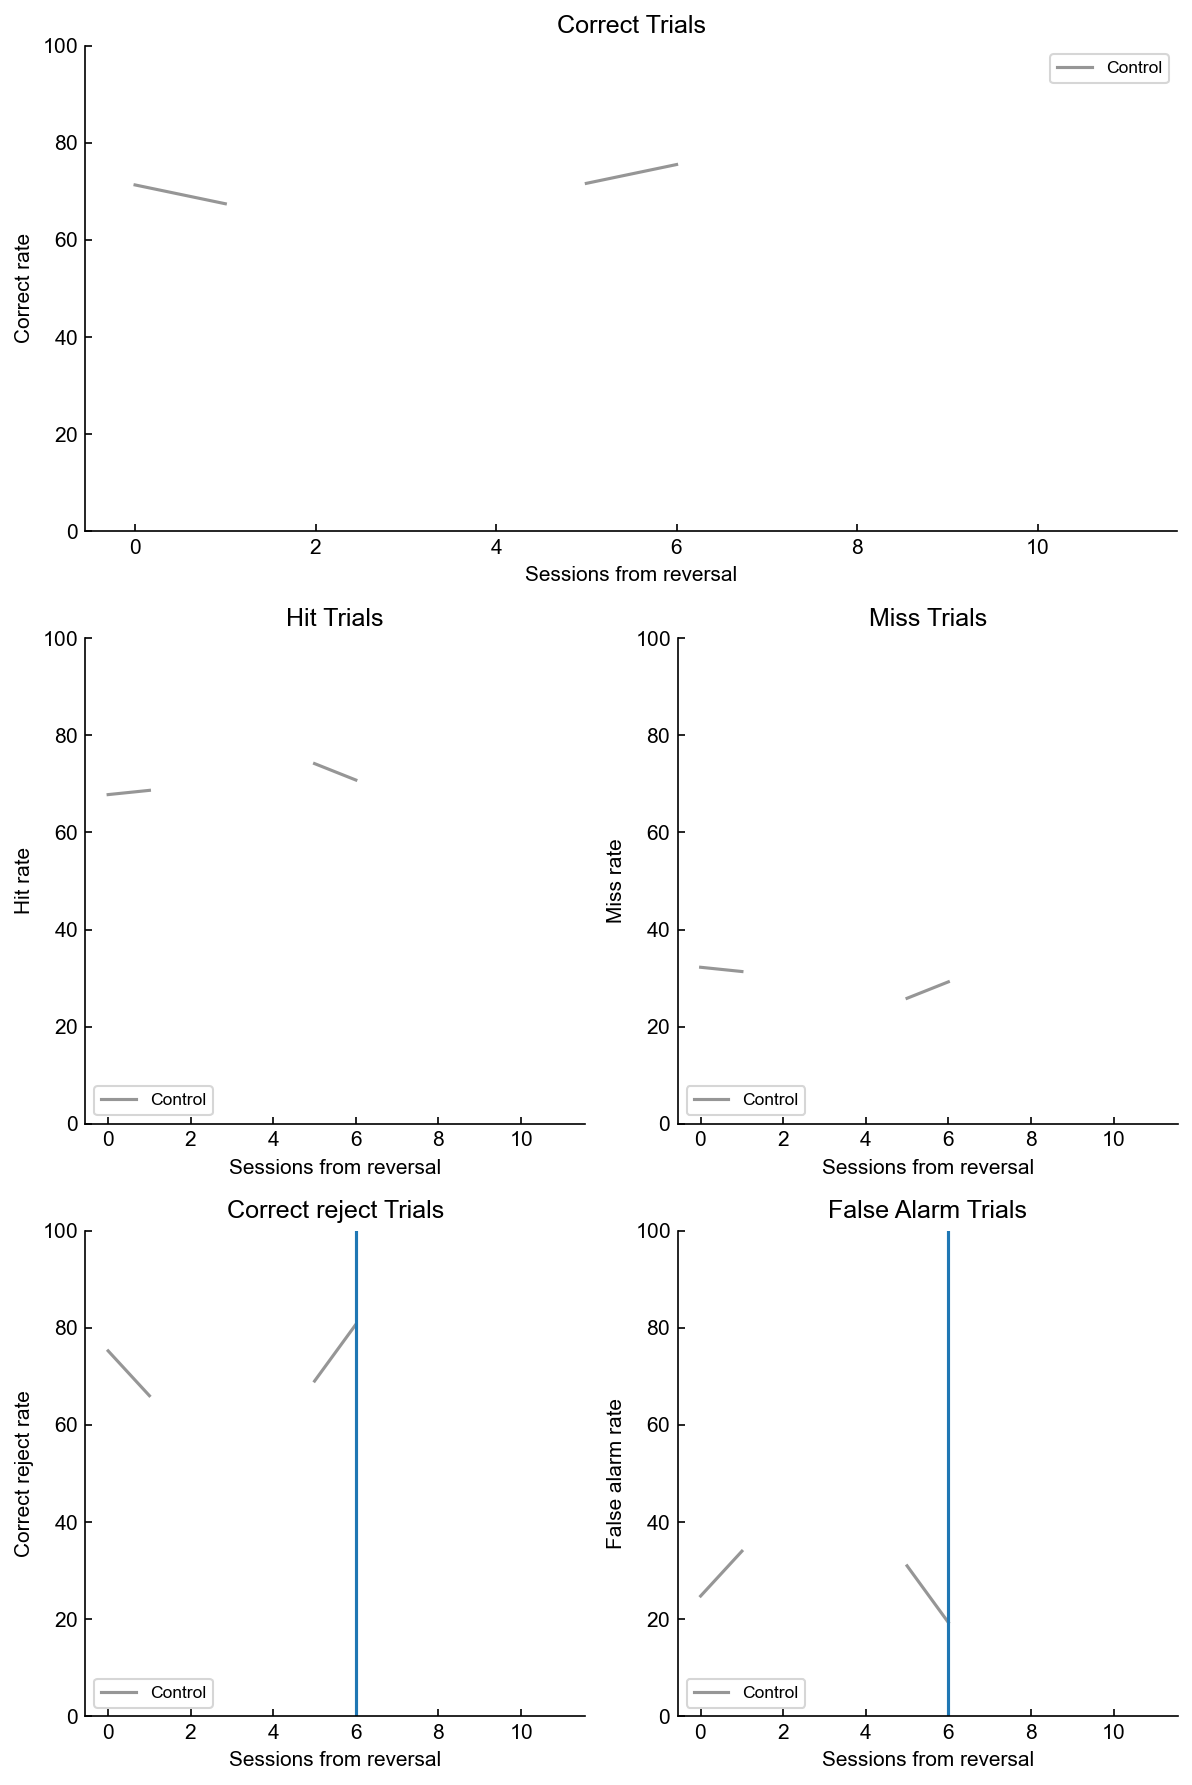

Control Animal: BS_72


<Figure size 900x600 with 0 Axes>

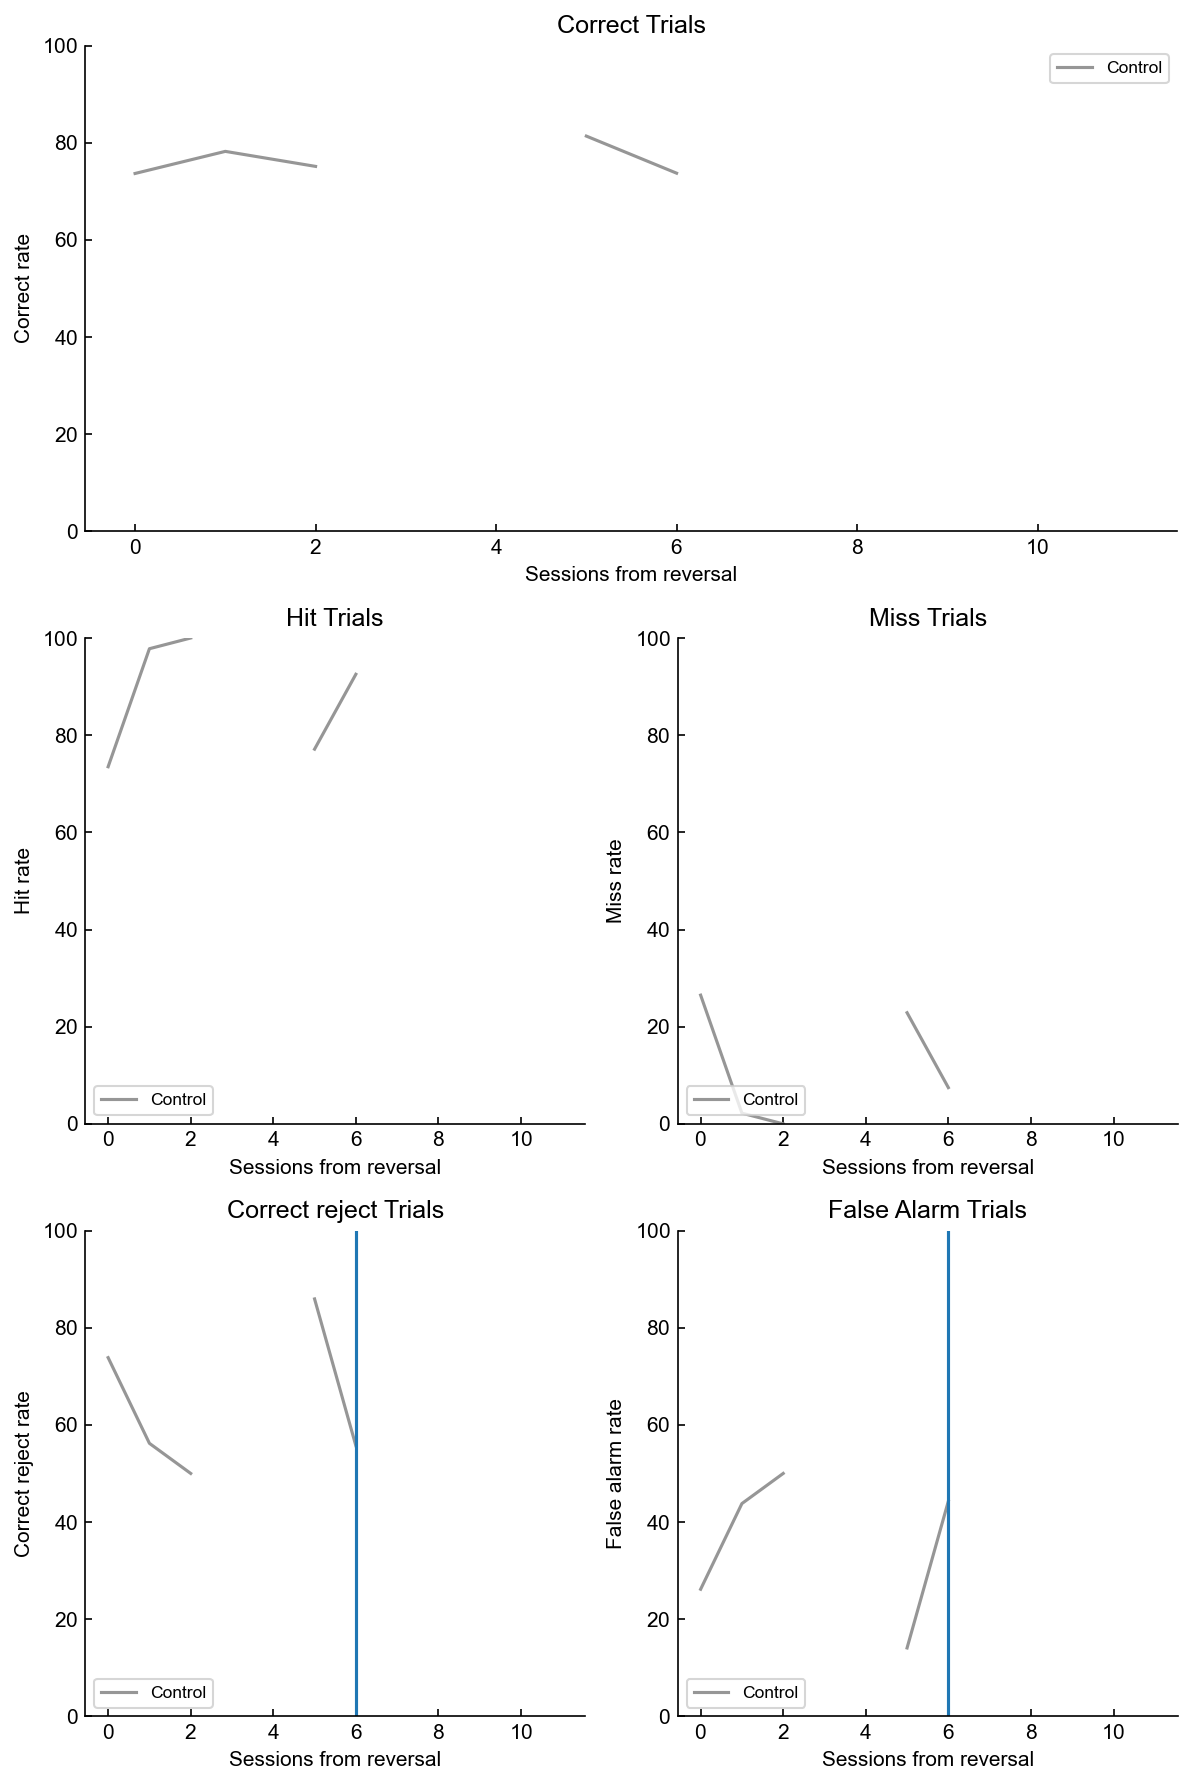

IndexError: index 12 is out of bounds for axis 0 with size 12

In [329]:
# plot each control animal individually
for animalidx, animal in enumerate(dualrecanimalnames):
     
    days = np.arange(0, np.shape(dual_pct_corr[:][animalidx])[0])
    title = str('Control Animal: ' + animal)
    print(title)
    
    #####################################################################
    fig = plt.figure()
    plt.suptitle(title)
    fig,ax = plt.subplots(6,1)
    fig.set_figheight(12)
    fig.set_figwidth(12)

    ax[0] = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=2)
    ax[1] = plt.subplot2grid(shape=(3, 3), loc=(1, 0), colspan=1)
    ax[2] = plt.subplot2grid(shape=(3, 3), loc=(1, 1), rowspan=1)
    ax[3] = plt.subplot2grid((3, 3), (2, 0))
    ax[4] = plt.subplot2grid((3, 3), (2, 1), colspan=1)

    #####################################################################
    # plot CORRECT and
    ax[0].set_ylim(0,100)
    ax[0].plot(days, (dual_pct_corr[:][animalidx]*100), color = GOOD_GREY, label = 'Control')
    #ax[0].plot(days, corrData_plot[1], color = LASER_COLOR, label = 'Laser ON')
    #ax[0].plot(days, corrData_plot[2], color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF')

    ax[0].set_xlabel('Sessions from reversal')
    ax[0].set_ylabel('Correct rate')
    ax[0].set_title('Correct Trials')
    ax[0].legend()
    #####################################################################

    #####################################################################
    # plot HIT and
    ax[1].set_ylim(0,100)
    ax[1].plot(days, (dual_pct_hit[:][animalidx]*100), color = GOOD_GREY, label = 'Control')
    #ax[1].plot(days, hitData_plot[1], color = LASER_COLOR, label = 'Laser ON')
    #ax[1].plot(days, hitData_plot[2], color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF')


    ax[1].set_xlabel('Sessions from reversal')
    ax[1].set_ylabel('Hit rate')
    ax[1].set_title('Hit Trials')
    ax[1].legend(loc = 'lower left')
    #####################################################################

    #####################################################################
    # plot MISS and
    ax[2].set_ylim(0,100)
    ax[2].plot(days, (dual_pct_miss[:][animalidx]*100), color = GOOD_GREY, label = 'Control')
    #ax[2].plot(days, missData_plot[1], color = LASER_COLOR, label = 'Laser ON')
    #ax[2].plot(days, missData_plot[2], color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF')

    ax[2].set_xlabel('Sessions from reversal')
    ax[2].set_ylabel('Miss rate')
    ax[2].set_title('Miss Trials')
    ax[2].legend(loc = 'lower left')
    #####################################################################

    #####################################################################
    # plot CREJECT and
    ax[3].set_ylim(0,100)
    ax[3].plot(days, (dual_pct_creject[:][animalidx]*100), color = GOOD_GREY, label = 'Control')
    #ax[3].plot(days, crejectData_plot[1], color = LASER_COLOR, label = 'Laser ON')
    #ax[3].plot(days, crejectData_plot[2], color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF')
    ax[3].axvline(6)

    ax[3].set_xlabel('Sessions from reversal')
    ax[3].set_ylabel('Correct reject rate')
    ax[3].set_title('Correct reject Trials')
    ax[3].legend(loc = 'lower left')
    #####################################################################

    #####################################################################
    # plot FALARM and
    ax[4].set_ylim(0,100)
    ax[4].plot(days, (dual_pct_falarm[:][animalidx]*100), color = GOOD_GREY, label = 'Control')
    #ax[4].plot(days, falarmData_plot[1], color = LASER_COLOR, label = 'Laser ON')
    #ax[4].plot(days, falarmData_plot[2], color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF')
    ax[4].axvline(6)

    ax[4].set_xlabel('Sessions from reversal')
    ax[4].set_ylabel('False alarm rate')
    ax[4].set_title('False Alarm Trials')
    ax[4].legend(loc = 'lower left')
    #####################################################################

    plt.tight_layout()
    #plt.savefig('Opsin Effects Across Sessions.pdf')
    plt.show()

    

Opsin (did not learn) Animal: BS_86


<Figure size 900x600 with 0 Axes>

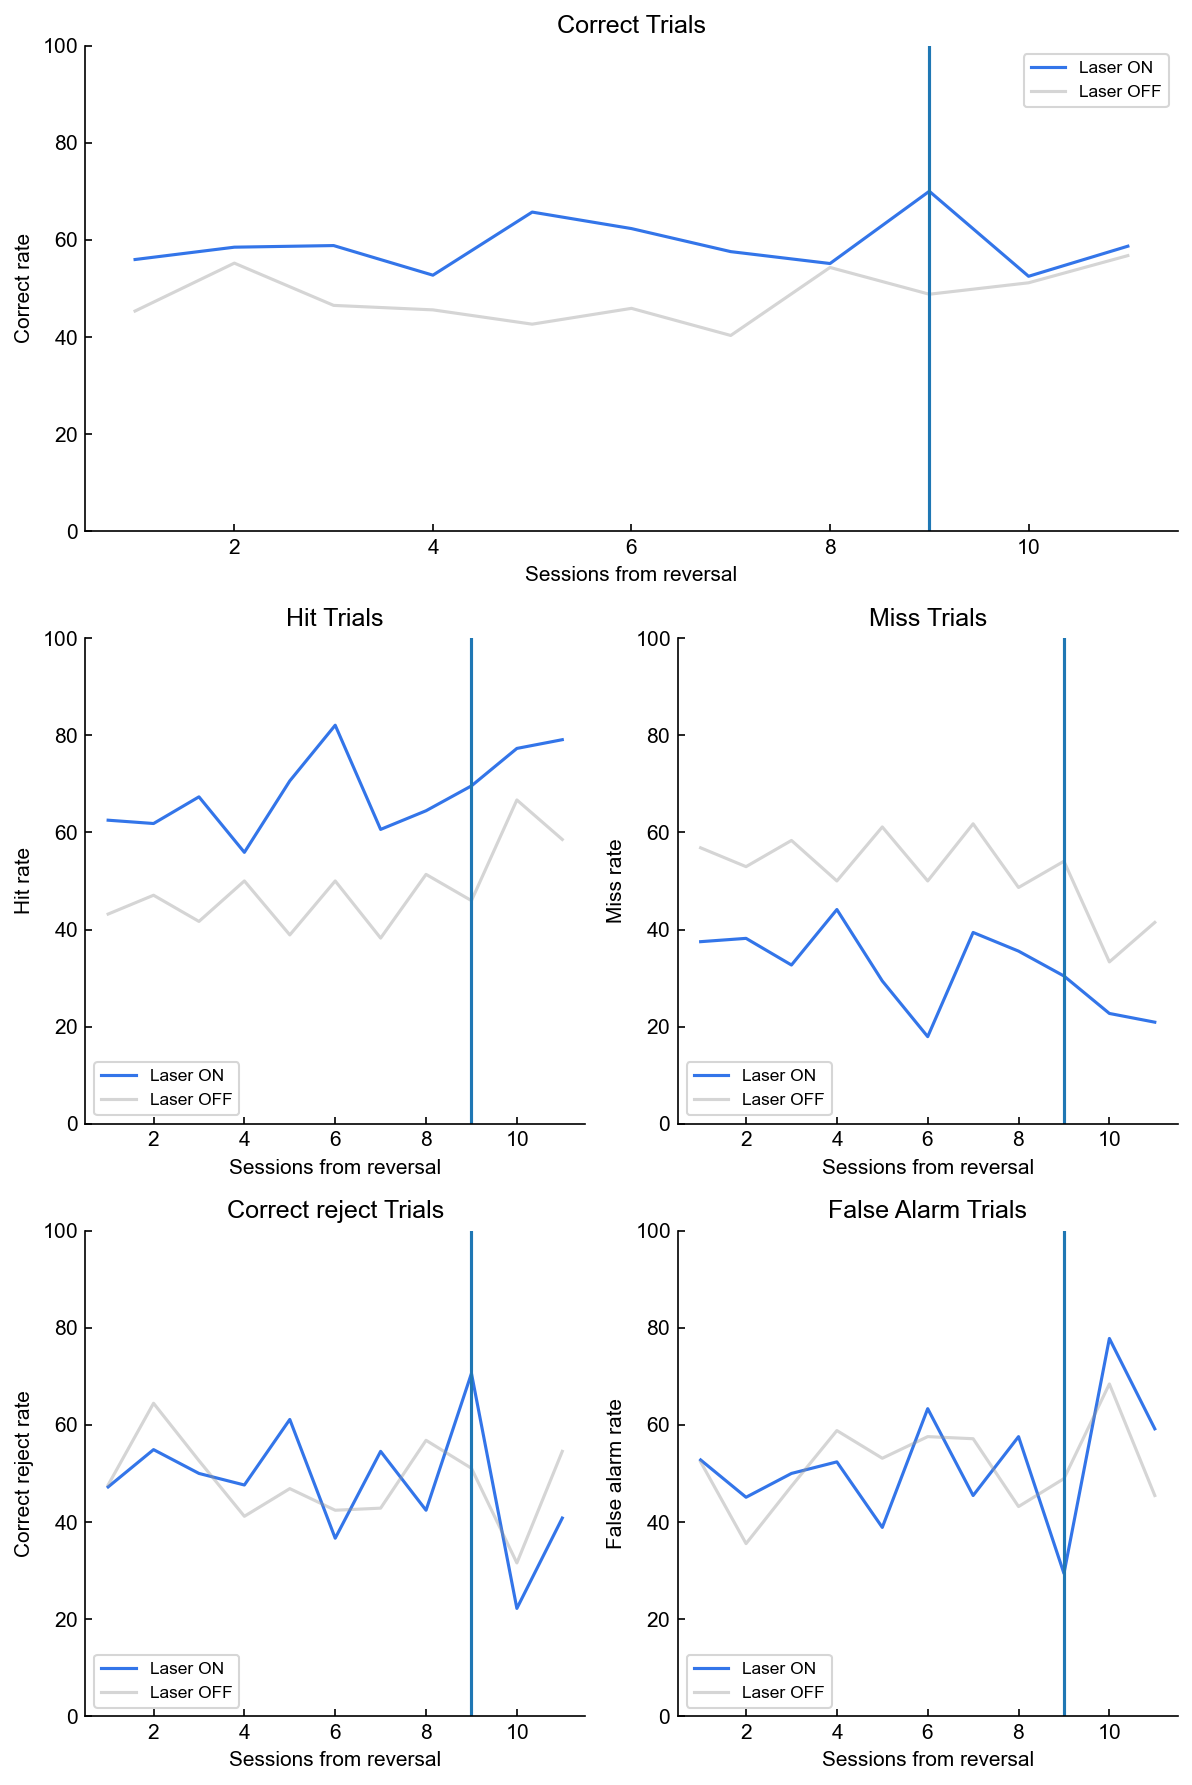

Opsin (did not learn) Animal: BS_100


<Figure size 900x600 with 0 Axes>

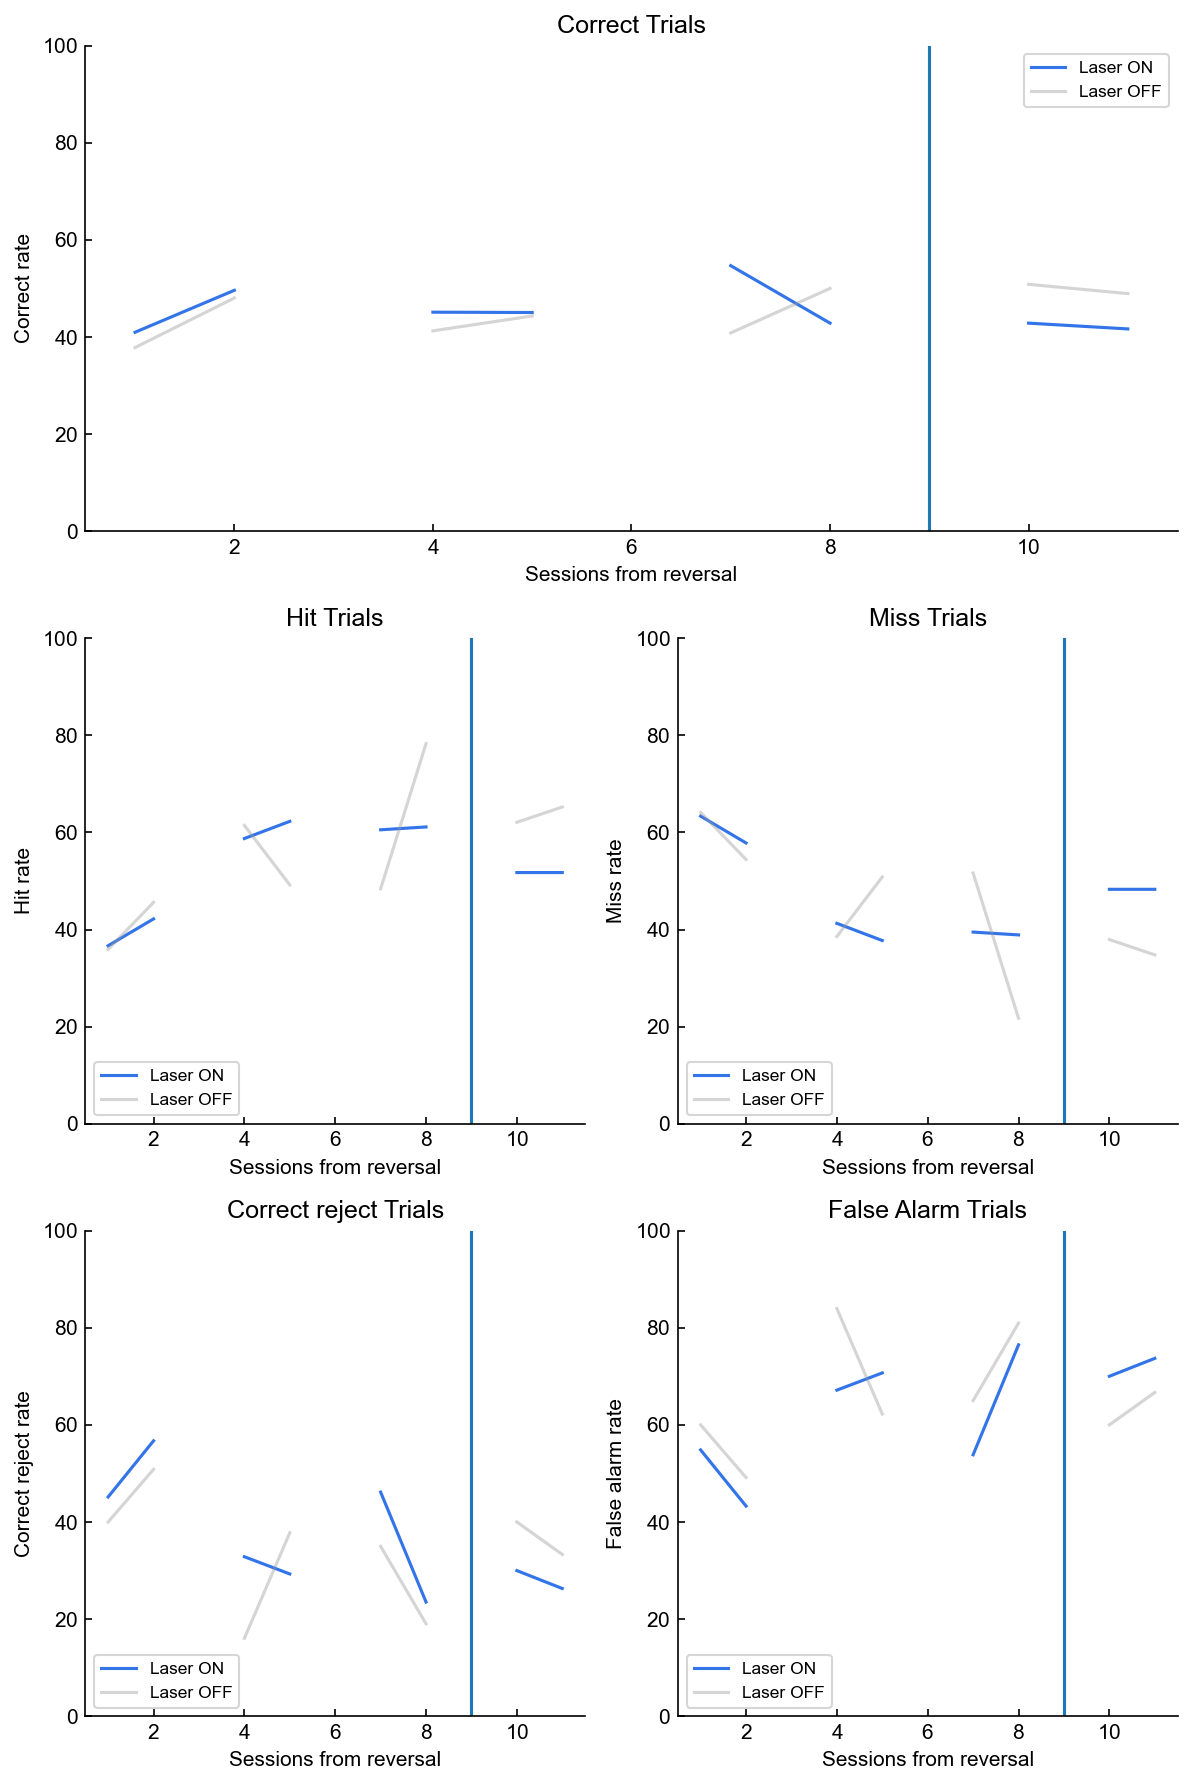

Opsin (did not learn) Animal: BS_119


<Figure size 900x600 with 0 Axes>

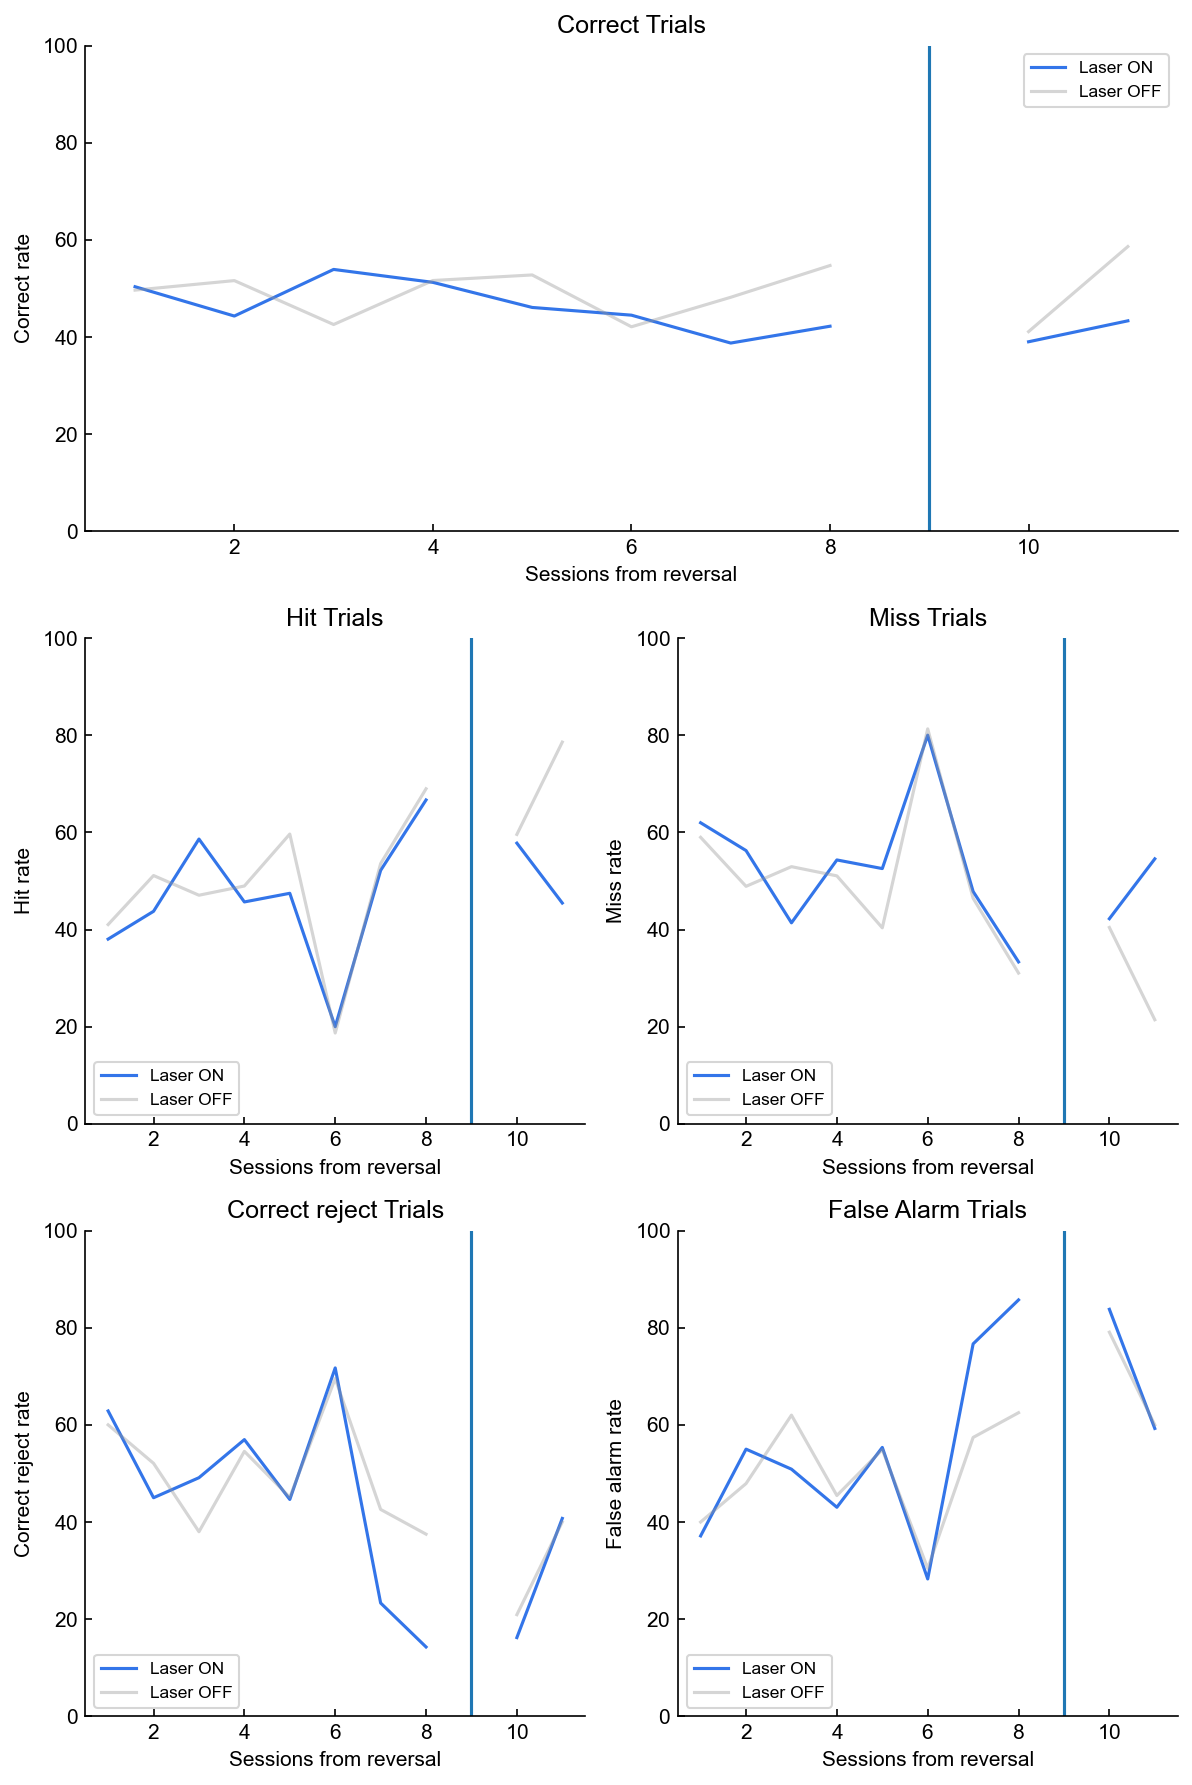

Opsin (did not learn) Animal: BS_123


<Figure size 900x600 with 0 Axes>

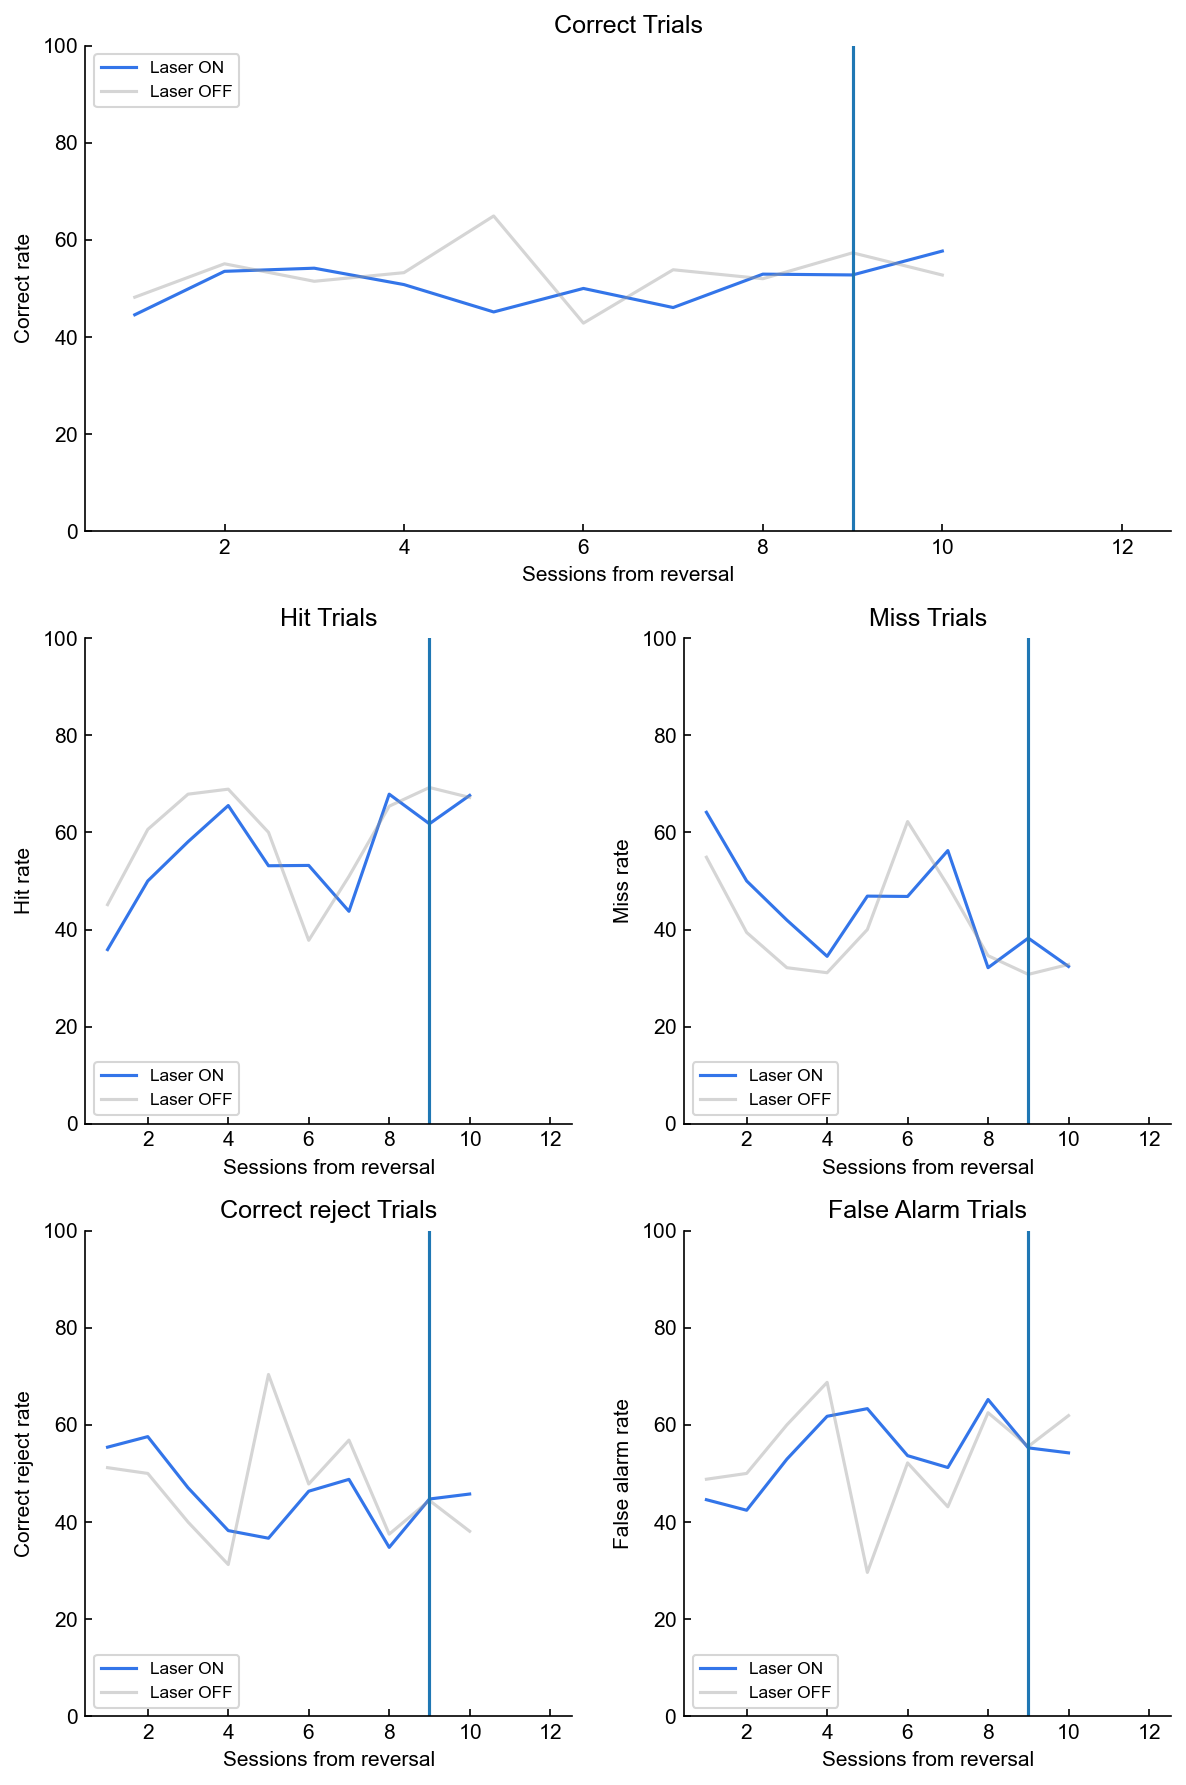

Opsin (did not learn) Animal: BS_128


<Figure size 900x600 with 0 Axes>

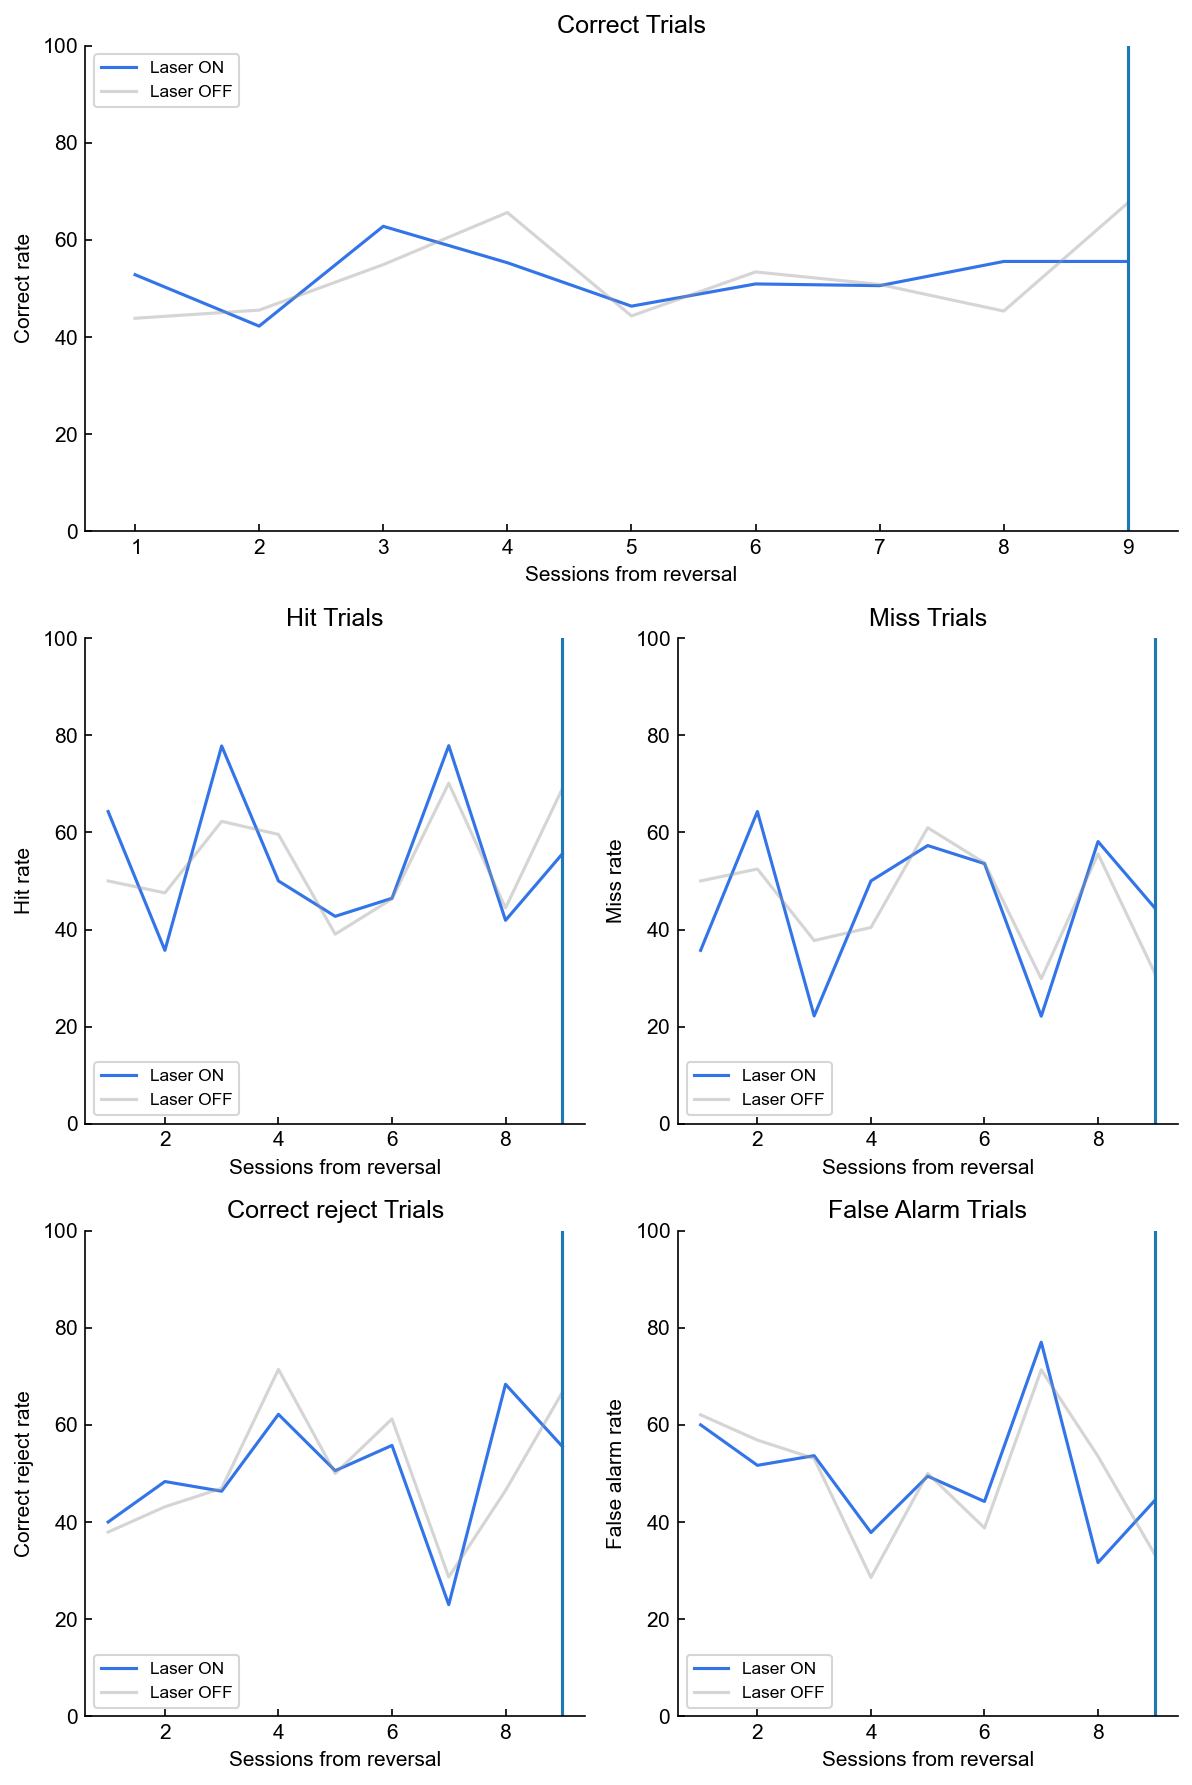

Opsin (did not learn) Animal: BS_131


<Figure size 900x600 with 0 Axes>

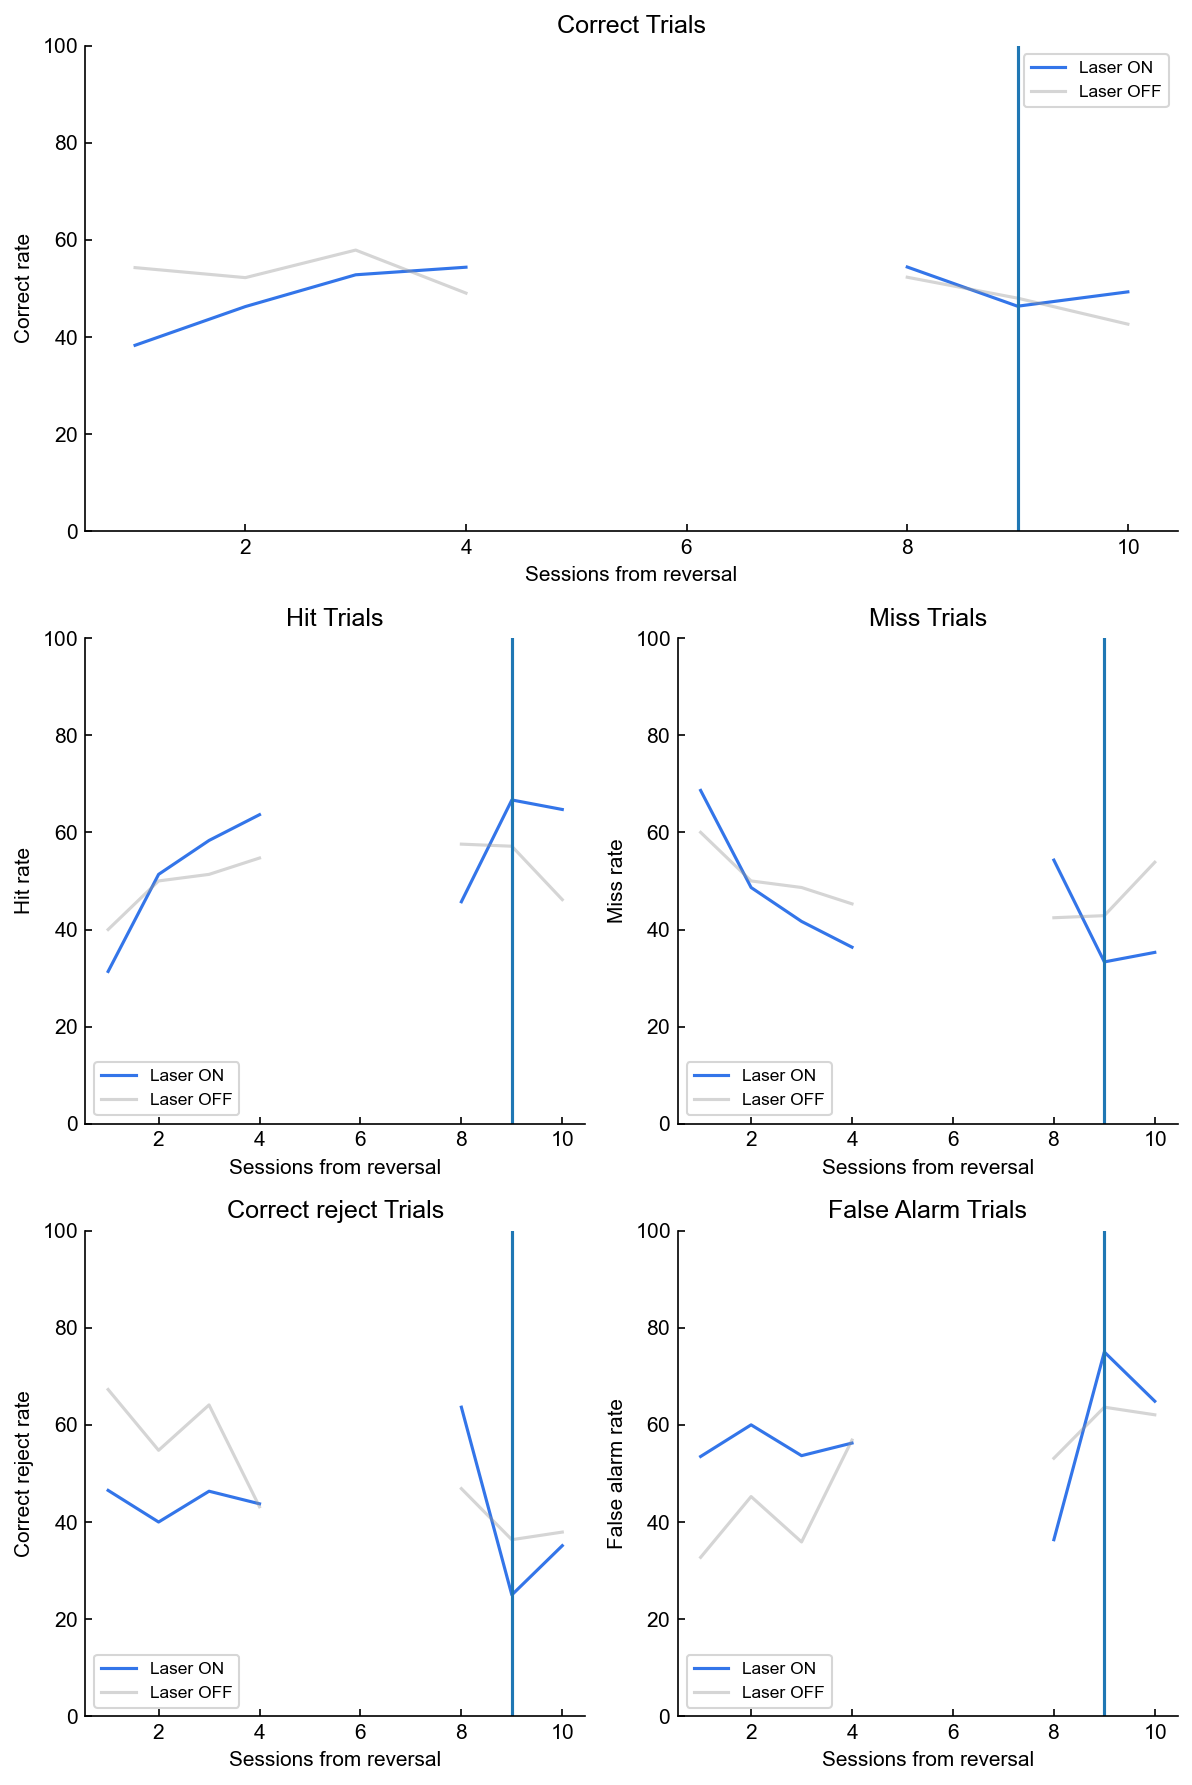

Opsin (did not learn) Animal: BS_163


<Figure size 900x600 with 0 Axes>

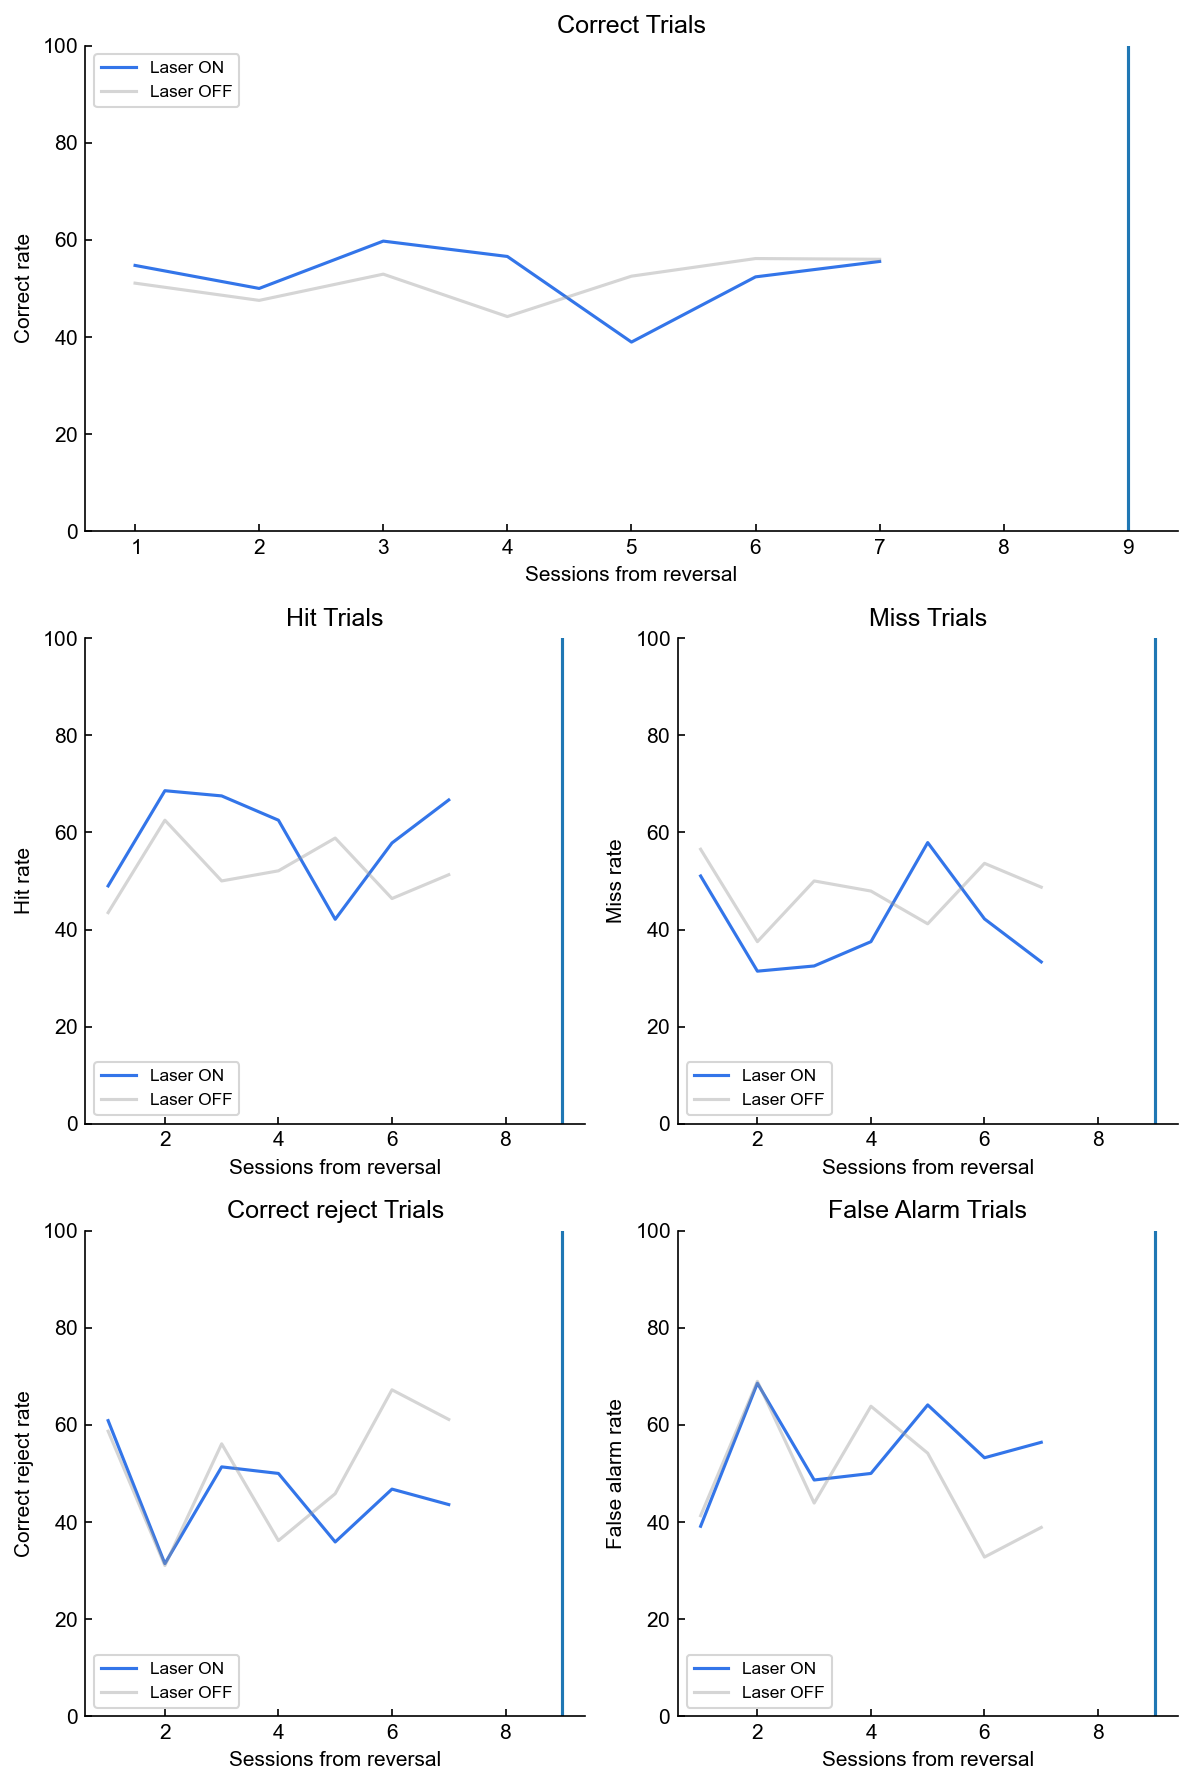

Opsin (did not learn) Animal: BS_174


<Figure size 900x600 with 0 Axes>

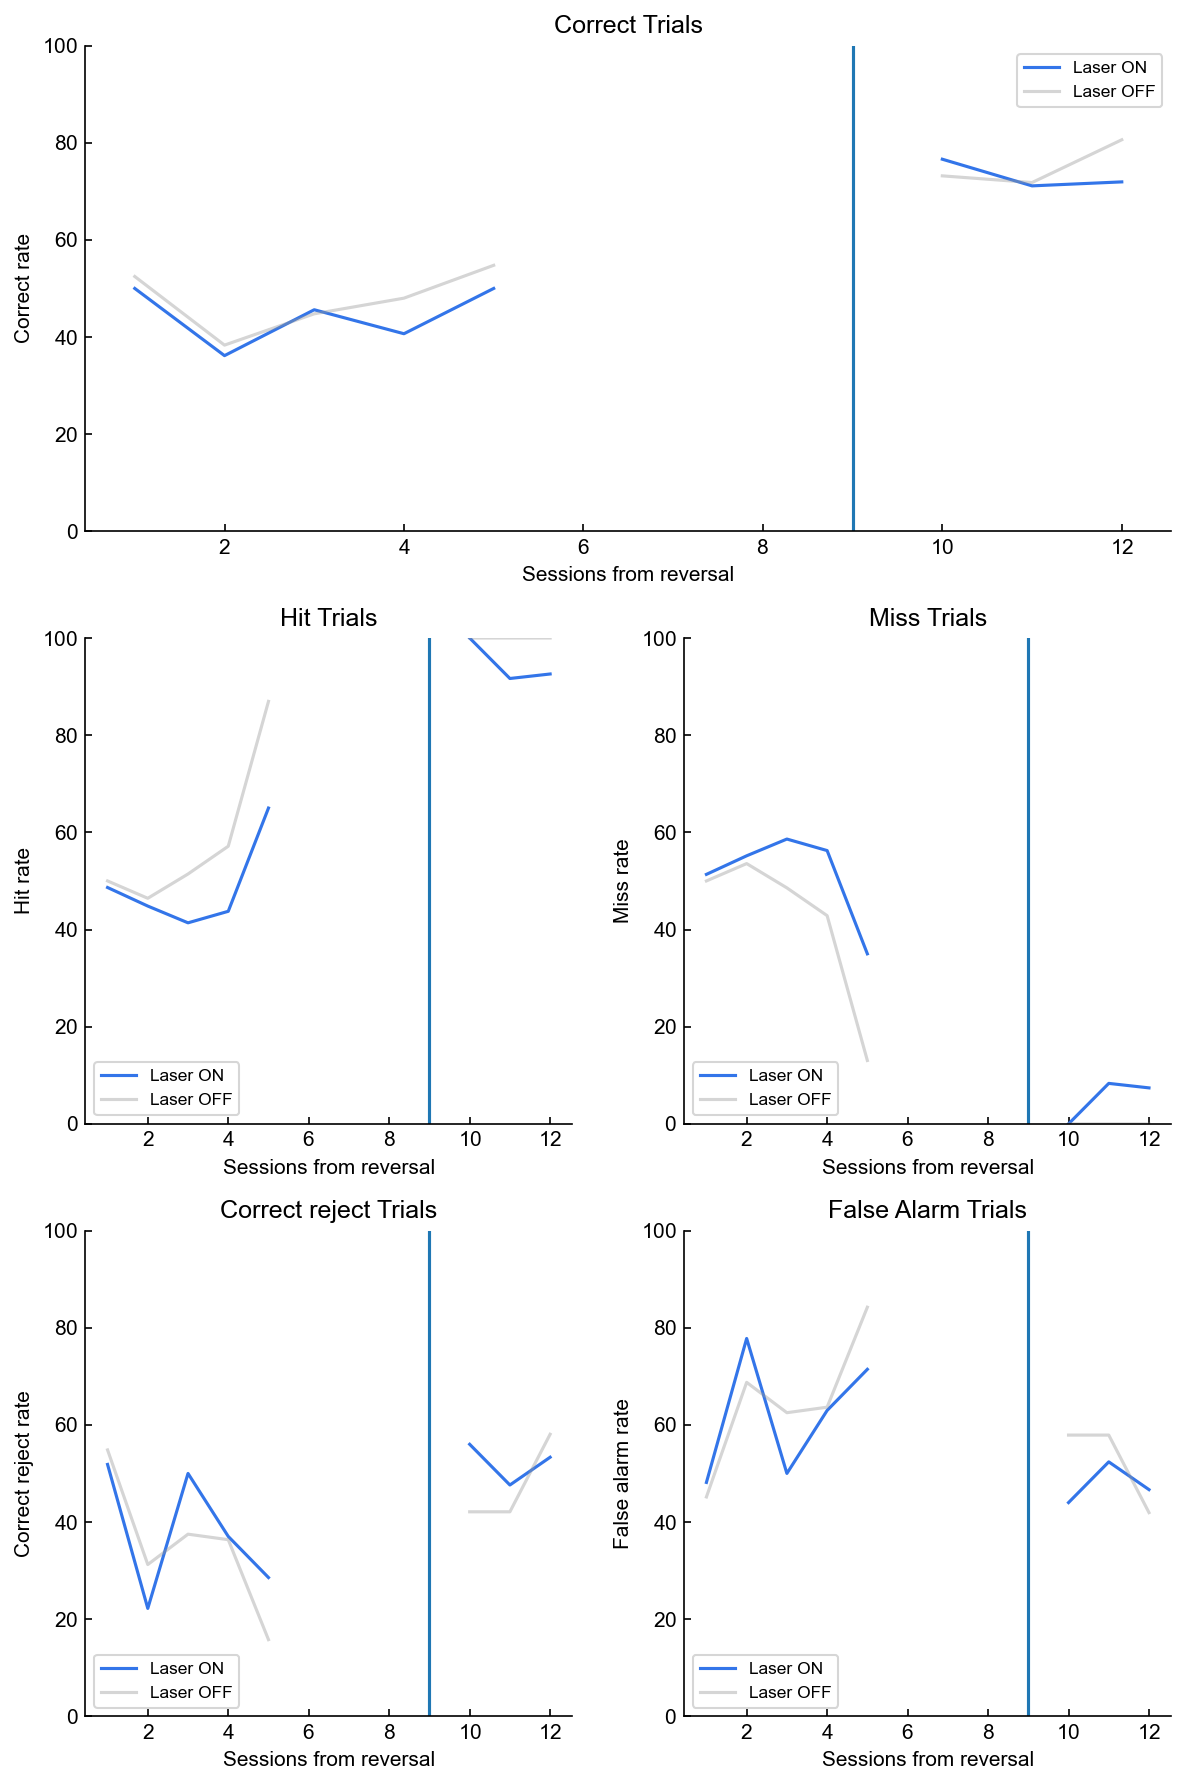

In [223]:
# plot each opsin animal individuals
for animalidx, animal in enumerate(didnotlearnopsinanimals):
     
    days = np.arange(1,13)
    title = str('Opsin (did not learn) Animal: ' + animal)
    print(title)
    
    #####################################################################
    fig = plt.figure()
    plt.suptitle(title)
    fig,ax = plt.subplots(6,1)
    fig.set_figheight(12)
    fig.set_figwidth(12)

    ax[0] = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=2)
    ax[1] = plt.subplot2grid(shape=(3, 3), loc=(1, 0), colspan=1)
    ax[2] = plt.subplot2grid(shape=(3, 3), loc=(1, 1), rowspan=1)
    ax[3] = plt.subplot2grid((3, 3), (2, 0))
    ax[4] = plt.subplot2grid((3, 3), (2, 1), colspan=1)

    #####################################################################
    # plot CORRECT and
    ax[0].set_ylim(0,100)
    ax[0].plot(days, (opsin_pct_corr_ON[:,animalidx]*100), color = LASER_COLOR, label = 'Laser ON')
    ax[0].plot(days, (opsin_pct_corr_OFF[:,animalidx]*100), color = GOOD_GREY, alpha = 0.4, label = 'Laser OFF')
    #ax[0].plot(days, corrData_plot[1], color = LASER_COLOR, label = 'Laser ON')
    #ax[0].plot(days, corrData_plot[2], color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF')
    ax[0].axvline(9)
    #ax[0].axvline(9)

    ax[0].set_xlabel('Sessions from reversal')
    ax[0].set_ylabel('Correct rate')
    ax[0].set_title('Correct Trials')
    ax[0].legend()
    #####################################################################

    #####################################################################
    # plot HIT and
    ax[1].set_ylim(0,100)
    ax[1].plot(days, (opsin_pct_hit_ON[:,animalidx]*100), color = LASER_COLOR, label = 'Laser ON')
    ax[1].plot(days, (opsin_pct_hit_OFF[:,animalidx]*100), color = GOOD_GREY, alpha = 0.4, label = 'Laser OFF')
    #ax[1].plot(days, hitData_plot[1], color = LASER_COLOR, label = 'Laser ON')
    #ax[1].plot(days, hitData_plot[2], color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF')
    ax[1].axvline(9)
    #ax[1].axvline(9)


    ax[1].set_xlabel('Sessions from reversal')
    ax[1].set_ylabel('Hit rate')
    ax[1].set_title('Hit Trials')
    ax[1].legend(loc = 'lower left')
    #####################################################################

    #####################################################################
    # plot MISS and
    ax[2].set_ylim(0,100)
    ax[2].plot(days, (opsin_pct_miss_ON[:,animalidx]*100), color = LASER_COLOR, label = 'Laser ON')
    ax[2].plot(days, (opsin_pct_miss_OFF[:,animalidx]*100), color = GOOD_GREY, alpha = 0.4, label = 'Laser OFF')
    #ax[2].plot(days, missData_plot[1], color = LASER_COLOR, label = 'Laser ON')
    #ax[2].plot(days, missData_plot[2], color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF')
    ax[2].axvline(9)
    #ax[2].axvline(9)

    ax[2].set_xlabel('Sessions from reversal')
    ax[2].set_ylabel('Miss rate')
    ax[2].set_title('Miss Trials')
    ax[2].legend(loc = 'lower left')
    #####################################################################

    #####################################################################
    # plot CREJECT and
    ax[3].set_ylim(0,100)
    ax[3].plot(days, (opsin_pct_creject_ON[:,animalidx]*100), color = LASER_COLOR, label = 'Laser ON')
    ax[3].plot(days, (opsin_pct_creject_OFF[:,animalidx]*100), color = GOOD_GREY, alpha = 0.4, label = 'Laser OFF')
    #ax[3].plot(days, crejectData_plot[1], color = LASER_COLOR, label = 'Laser ON')
    #ax[3].plot(days, crejectData_plot[2], color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF')
    ax[3].axvline(9)
    #ax[3].axvline(9)

    ax[3].set_xlabel('Sessions from reversal')
    ax[3].set_ylabel('Correct reject rate')
    ax[3].set_title('Correct reject Trials')
    ax[3].legend(loc = 'lower left')
    #####################################################################

    #####################################################################
    # plot FALARM and
    ax[4].set_ylim(0,100)
    ax[4].plot(days, (opsin_pct_falarm_ON[:,animalidx]*100), color = LASER_COLOR, label = 'Laser ON')
    ax[4].plot(days, (opsin_pct_falarm_OFF[:,animalidx]*100), color = GOOD_GREY, alpha = 0.4, label = 'Laser OFF')
    #ax[4].plot(days, falarmData_plot[1], color = LASER_COLOR, label = 'Laser ON')
    #ax[4].plot(days, falarmData_plot[2], color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF')
    ax[4].axvline(9)
    #ax[4].axvline(9)

    ax[4].set_xlabel('Sessions from reversal')
    ax[4].set_ylabel('False alarm rate')
    ax[4].set_title('False Alarm Trials')
    ax[4].legend(loc = 'lower left')
    #####################################################################

    plt.tight_layout()
    #plt.savefig('Opsin Effects Across Sessions.pdf')
    plt.show()


## Look at behavior day before laser is turned on (for each animal), then compare to first day of laser

In [ ]:
# GOAL IS TO SEE IF BEHAVIOR IS LOCKED IN BEFORE LASER IS TURNED ON

In [778]:
# 0 indexed
animalBehaviors['BS_86'].first_day_laser = 13
animalBehaviors['BS_100'].first_day_laser = 10
animalBehaviors['BS_119'].first_day_laser = 9 # maybe weird
animalBehaviors['BS_123'].first_day_laser = 8
animalBehaviors['BS_128'].first_day_laser = 3
animalBehaviors['BS_131'].first_day_laser = 13
animalBehaviors['BS_163'].first_day_laser = 2
animalBehaviors['BS_174'].first_day_laser = 13

# veryify correct days with following code (1-indexed):
# for animal in didnotlearnopsinanimals:
#     for i in results.sessionnum_list:
#         if np.sum(np.where(animalBehaviors[animal].sessions[i].laser)) > 0:
#             print(animal, i)
#             break
#######################################################################
for animalidx,animal in enumerate(didnotlearnopsinanimals):

    results = getAnimalBehaviorResults(animal,act_directory) 
    
    # having to do it like this because of zero indexing. Grabbing day before first laser and day of first laser
    day1 = animalBehaviors[animal].first_day_laser - 1
    day2 = animalBehaviors[animal].first_day_laser 

    opsin_pct_hit_ON_laserOnOff[0][animalidx] = results.hit_pct_ON[day1] / (results.hit_pct_ON[day1] + results.miss_pct_ON[day1])
    opsin_pct_miss_ON_laserOnOff[0][animalidx] = results.miss_pct_ON[day1] / (results.hit_pct_ON[day1] + results.miss_pct_ON[day1])
    opsin_pct_falarm_ON_laserOnOff[0][animalidx] = results.falarm_pct_ON[day1] / (results.falarm_pct_ON[day1] + results.creject_pct_ON[day1])
    opsin_pct_creject_ON_laserOnOff[0][animalidx] = results.creject_pct_ON[day1] / (results.falarm_pct_ON[day1] + results.creject_pct_ON[day1])
    opsin_pct_corr_ON_laserOnOff[0][animalidx] = results.corr_pct_ON[day1]
    opsin_pct_hit_OFF_laserOnOff[0][animalidx] = results.hit_pct_OFF[day1]  / (results.hit_pct_OFF[day1] + results.miss_pct_OFF[day1])
    opsin_pct_miss_OFF_laserOnOff[0][animalidx] = results.miss_pct_OFF[day1] / (results.hit_pct_OFF[day1] + results.miss_pct_OFF[day1])
    opsin_pct_falarm_OFF_laserOnOff[0][animalidx] = results.falarm_pct_OFF[day1] / (results.falarm_pct_OFF[day1] + results.creject_pct_OFF[day1])
    opsin_pct_creject_OFF_laserOnOff[0][animalidx] = results.creject_pct_OFF[day1]  / (results.falarm_pct_OFF[day1] + results.creject_pct_OFF[day1])
    opsin_pct_corr_OFF_laserOnOff[0][animalidx] = results.corr_pct_OFF[day1]  

    opsin_pct_hit_ON_laserOnOff[1][animalidx] = results.hit_pct_ON[day2] / (results.hit_pct_ON[day2] + results.miss_pct_ON[day2])
    opsin_pct_miss_ON_laserOnOff[1][animalidx] = results.miss_pct_ON[day2] / (results.hit_pct_ON[day2] + results.miss_pct_ON[day2])
    opsin_pct_falarm_ON_laserOnOff[1][animalidx] = results.falarm_pct_ON[day2] / (results.falarm_pct_ON[day2] + results.creject_pct_ON[day2])
    opsin_pct_creject_ON_laserOnOff[1][animalidx] = results.creject_pct_ON[day2] / (results.falarm_pct_ON[day2] + results.creject_pct_ON[day2])
    opsin_pct_corr_ON_laserOnOff[1][animalidx] = results.corr_pct_ON[day2]
    opsin_pct_hit_OFF_laserOnOff[1][animalidx] = results.hit_pct_OFF[day2]  / (results.hit_pct_OFF[day2] + results.miss_pct_OFF[day2])
    opsin_pct_miss_OFF_laserOnOff[1][animalidx] = results.miss_pct_OFF[day2] / (results.hit_pct_OFF[day2] + results.miss_pct_OFF[day2])
    opsin_pct_falarm_OFF_laserOnOff[1][animalidx] = results.falarm_pct_OFF[day2] / (results.falarm_pct_OFF[day2] + results.creject_pct_OFF[day2])
    opsin_pct_creject_OFF_laserOnOff[1][animalidx] = results.creject_pct_OFF[day2]  / (results.falarm_pct_OFF[day2] + results.creject_pct_OFF[day2])
    opsin_pct_corr_OFF_laserOnOff[1][animalidx] = results.corr_pct_OFF[day2]
                  
    print('opsin animal:', animal, 'done')        

opsin animal: BS_119 done


<Figure size 900x600 with 0 Axes>

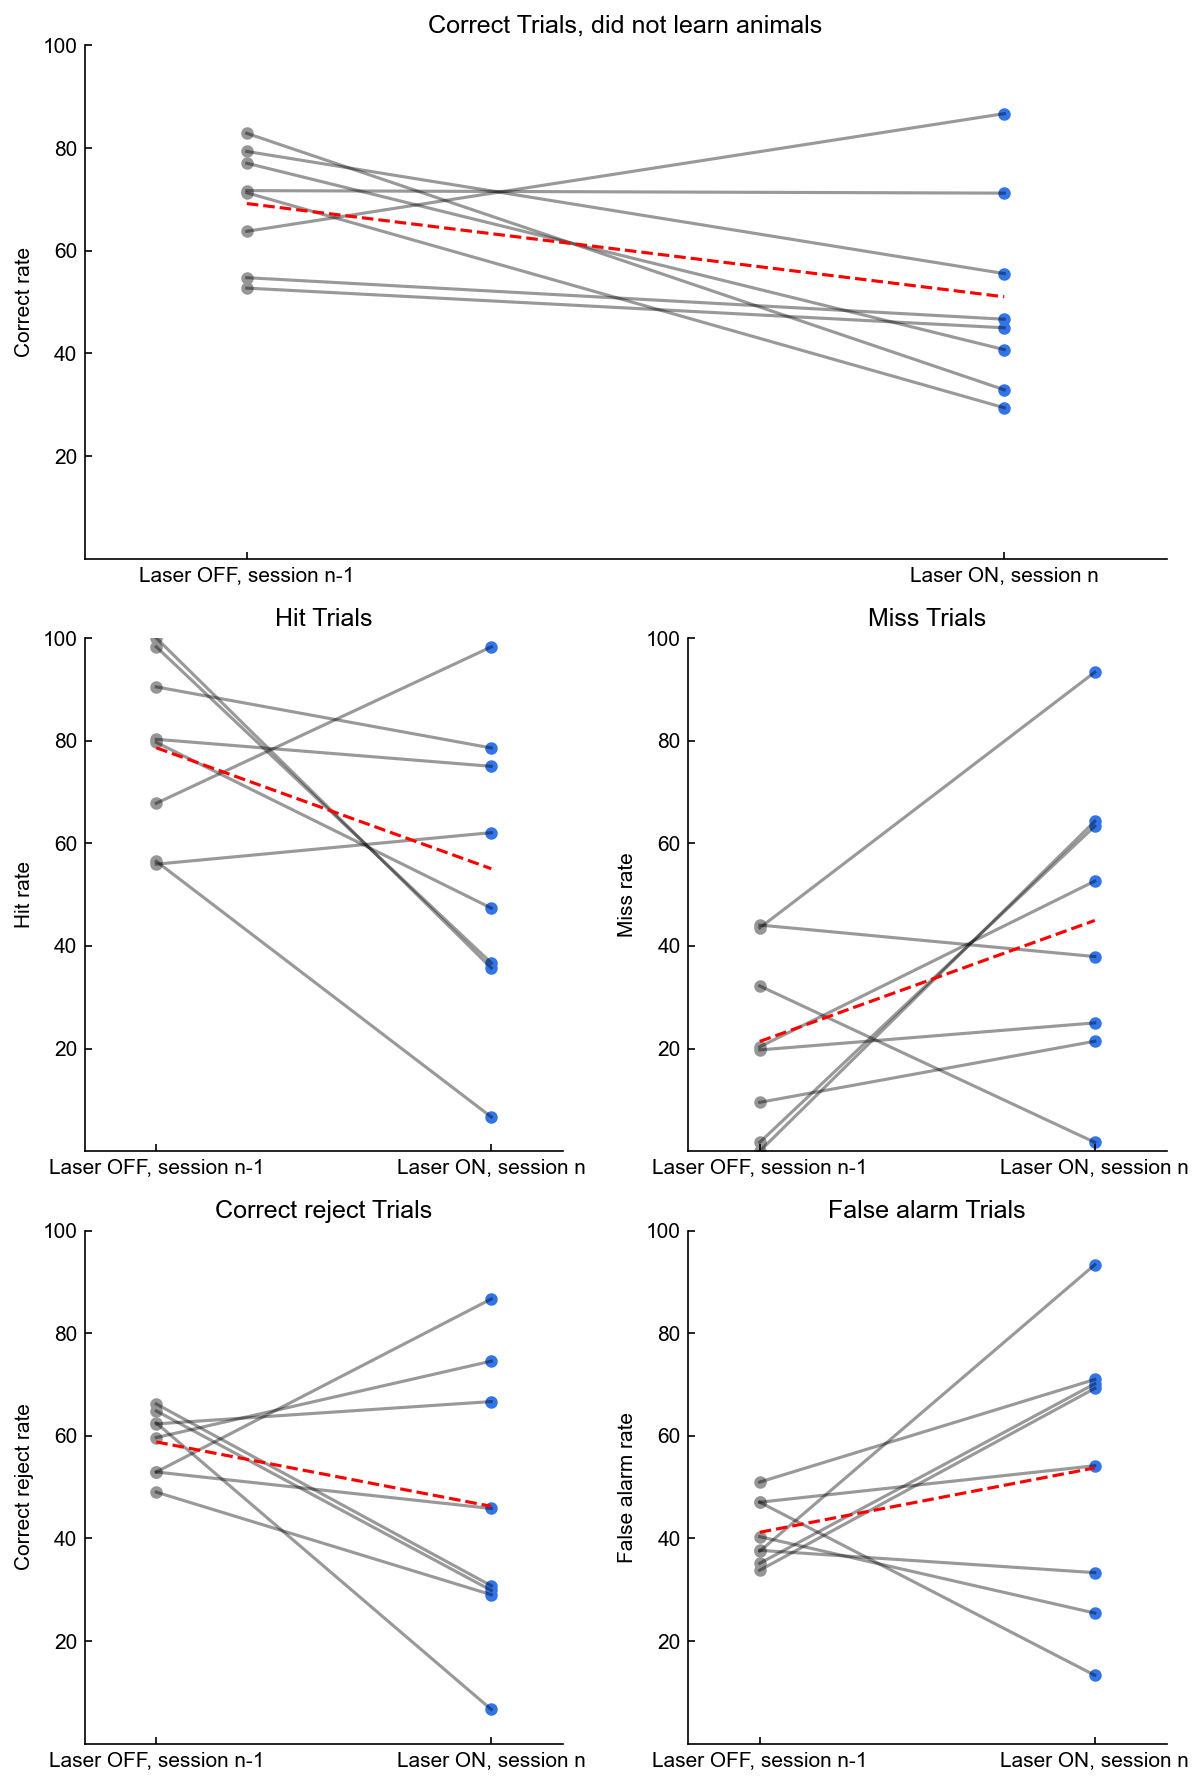

In [865]:
# PLOT
# produce means and plotting data
opsin_pct_corr_OFF_laserOnOff_means = np.mean(opsin_pct_corr_OFF_laserOnOff, axis=1)
opsin_pct_corr_ON_laserOnOff_means = np.mean(opsin_pct_corr_ON_laserOnOff, axis=1)

opsin_pct_hit_OFF_laserOnOff_means = np.mean(opsin_pct_hit_OFF_laserOnOff, axis=1)
opsin_pct_hit_ON_laserOnOff_means = np.mean(opsin_pct_hit_ON_laserOnOff, axis=1)

opsin_pct_miss_OFF_laserOnOff_means = np.mean(opsin_pct_miss_OFF_laserOnOff, axis=1)
opsin_pct_miss_ON_laserOnOff_means = np.mean(opsin_pct_miss_ON_laserOnOff, axis=1)

opsin_pct_creject_OFF_laserOnOff_means = np.mean(opsin_pct_creject_OFF_laserOnOff, axis=1)
opsin_pct_creject_ON_laserOnOff_means = np.mean(opsin_pct_creject_ON_laserOnOff, axis=1)

opsin_pct_falarm_OFF_laserOnOff_means = np.mean(opsin_pct_falarm_OFF_laserOnOff, axis=1)
opsin_pct_falarm_ON_laserOnOff_means = np.mean(opsin_pct_falarm_ON_laserOnOff, axis=1)

opsin_pct_corr_laserOnOff_plot = [opsin_pct_corr_OFF_laserOnOff_means[0], opsin_pct_corr_ON_laserOnOff_means[1]]
opsin_pct_hit_laserOnOff_plot = [opsin_pct_hit_OFF_laserOnOff_means[0], opsin_pct_hit_ON_laserOnOff_means[1]]
opsin_pct_miss_laserOnOff_plot = [opsin_pct_miss_OFF_laserOnOff_means[0], opsin_pct_miss_ON_laserOnOff_means[1]]
opsin_pct_creject_laserOnOff_plot = [opsin_pct_creject_OFF_laserOnOff_means[0], opsin_pct_creject_ON_laserOnOff_means[1]]
opsin_pct_falarm_laserOnOff_plot = [opsin_pct_falarm_OFF_laserOnOff_means[0], opsin_pct_falarm_ON_laserOnOff_means[1]]

#####################################################################
fig = plt.figure()
plt.suptitle(title)
fig,ax = plt.subplots(6,1)
fig.set_figheight(12)
fig.set_figwidth(12)

ax[0] = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=2)
ax[1] = plt.subplot2grid(shape=(3, 3), loc=(1, 0), colspan=1)
ax[2] = plt.subplot2grid(shape=(3, 3), loc=(1, 1), rowspan=1)
ax[3] = plt.subplot2grid((3, 3), (2, 0))
ax[4] = plt.subplot2grid((3, 3), (2, 1), colspan=1)

#####################################################################
# plot CORRECT and
ax[0].set_ylim(0,1)
ax[0].set_xlim(1,2)

days = [1.15, 1.85]

ax[0].scatter(np.repeat(days[0],8), opsin_pct_corr_OFF_laserOnOff[0], marker = '.', s = 100, color = GOOD_GREY)
ax[0].scatter(np.repeat(days[1],8), opsin_pct_corr_ON_laserOnOff[1], marker = '.', s = 100, color = LASER_COLOR)
ax[0].plot(days, (opsin_pct_corr_OFF_laserOnOff[0], opsin_pct_corr_ON_laserOnOff[1]), color = 'k', alpha = 0.4)

ax[0].set_ylabel('Correct rate')
ax[0].set_title('Correct Trials, did not learn animals')

ax[0].set_yticks([0.2, 0.4, 0.6, 0.8, 1])
ax[0].set_yticklabels([20, 40, 60, 80, 100])
ax[0].set_xticks([1.15,1.85])
ax[0].set_xticklabels(['Laser OFF, session n-1', 'Laser ON, session n'])

# plot trendline
z = np.polyfit(days, [np.mean(opsin_pct_corr_OFF_laserOnOff[0],axis=0), np.mean(opsin_pct_corr_ON_laserOnOff[1],axis=0)], 1)
p = np.poly1d(z)
ax[0].plot(days, p(days), 'r--')

#####################################################################

#####################################################################
# plot Hit and
ax[1].set_ylim(0,1)
ax[1].set_xlim(1,2)

days = [1.15, 1.85]

ax[1].scatter(np.repeat(days[0],8), opsin_pct_hit_OFF_laserOnOff[0], marker = '.', s = 100, color = GOOD_GREY)
ax[1].scatter(np.repeat(days[1],8), opsin_pct_hit_ON_laserOnOff[1], marker = '.', s = 100, color = LASER_COLOR)
ax[1].plot(days, (opsin_pct_hit_OFF_laserOnOff[0], opsin_pct_hit_ON_laserOnOff[1]), color = 'k', alpha = 0.4)

ax[1].set_yticks([0.2, 0.4, 0.6, 0.8, 1])
ax[1].set_yticklabels([20, 40, 60, 80, 100])
ax[1].set_ylabel('Hit rate')
ax[1].set_title('Hit Trials')

ax[1].set_xticks([1.15,1.85])
ax[1].set_xticklabels(['Laser OFF, session n-1', 'Laser ON, session n'])

# plot trendline
z = np.polyfit(days, [np.mean(opsin_pct_hit_OFF_laserOnOff[0],axis=0), np.mean(opsin_pct_hit_ON_laserOnOff[1],axis=0)], 1)
p = np.poly1d(z)
ax[1].plot(days, p(days), 'r--')

#####################################################################

#####################################################################
# plot MISS and
ax[2].set_ylim(0,1)
ax[2].set_xlim(1,2)

days = [1.15, 1.85]

ax[2].scatter(np.repeat(days[0],8), opsin_pct_miss_OFF_laserOnOff[0], marker = '.', s = 100, color = GOOD_GREY)
ax[2].scatter(np.repeat(days[1],8), opsin_pct_miss_ON_laserOnOff[1], marker = '.', s = 100, color = LASER_COLOR)
ax[2].plot(days, (opsin_pct_miss_OFF_laserOnOff[0], opsin_pct_miss_ON_laserOnOff[1]), color = 'k', alpha = 0.4)

ax[2].set_ylabel('Miss rate')
ax[2].set_title('Miss Trials')

ax[2].set_yticks([0.2, 0.4, 0.6, 0.8, 1])
ax[2].set_yticklabels([20, 40, 60, 80, 100])
ax[2].set_xticks([1.15,1.85])
ax[2].set_xticklabels(['Laser OFF, session n-1', 'Laser ON, session n'])

# plot trendline
z = np.polyfit(days, [np.mean(opsin_pct_miss_OFF_laserOnOff[0],axis=0), np.mean(opsin_pct_miss_ON_laserOnOff[1],axis=0)], 1)
p = np.poly1d(z)
ax[2].plot(days, p(days), 'r--')

#####################################################################

#####################################################################
# plot CREJECT and
ax[3].set_ylim(0,1)
ax[3].set_xlim(1,2)

days = [1.15, 1.85]

ax[3].scatter(np.repeat(days[0],8), opsin_pct_creject_OFF_laserOnOff[0], marker = '.', s = 100, color = GOOD_GREY)
ax[3].scatter(np.repeat(days[1],8), opsin_pct_creject_ON_laserOnOff[1], marker = '.', s = 100, color = LASER_COLOR)
ax[3].plot(days, (opsin_pct_creject_OFF_laserOnOff[0], opsin_pct_creject_ON_laserOnOff[1]), color = 'k', alpha = 0.4)

ax[3].set_yticks([0.2, 0.4, 0.6, 0.8, 1])
ax[3].set_yticklabels([20, 40, 60, 80, 100])
ax[3].set_ylabel('Correct reject rate')
ax[3].set_title('Correct reject Trials')

ax[3].set_xticks([1.15,1.85])
ax[3].set_xticklabels(['Laser OFF, session n-1', 'Laser ON, session n'])

# plot trendline
z = np.polyfit(days, [np.mean(opsin_pct_creject_OFF_laserOnOff[0],axis=0), np.mean(opsin_pct_creject_ON_laserOnOff[1],axis=0)], 1)
p = np.poly1d(z)
ax[3].plot(days, p(days), 'r--')

#####################################################################

#####################################################################
# plot FALSE ALARM and
ax[4].set_ylim(0,1)
ax[4].set_xlim(1,2)

days = [1.15, 1.85]

ax[4].scatter(np.repeat(days[0],8), opsin_pct_falarm_OFF_laserOnOff[0], marker = '.', s = 100, color = GOOD_GREY)
ax[4].scatter(np.repeat(days[1],8), opsin_pct_falarm_ON_laserOnOff[1], marker = '.', s = 100, color = LASER_COLOR)
ax[4].plot(days, (opsin_pct_falarm_OFF_laserOnOff[0], opsin_pct_falarm_ON_laserOnOff[1]), color = 'k', alpha = 0.4)

ax[4].set_ylabel('False alarm rate')
ax[4].set_title('False alarm Trials')

ax[4].set_yticks([0.2, 0.4, 0.6, 0.8, 1])
ax[4].set_yticklabels([20, 40, 60, 80, 100])
ax[4].set_xticks([1.15,1.85])
ax[4].set_xticklabels(['Laser OFF, session n-1', 'Laser ON, session n'])

# plot trendline
z = np.polyfit(days, [np.mean(opsin_pct_falarm_OFF_laserOnOff[0],axis=0), np.mean(opsin_pct_falarm_ON_laserOnOff[1],axis=0)], 1)
p = np.poly1d(z)
ax[4].plot(days, p(days), 'r--')

#####################################################################

plt.tight_layout()
plt.savefig('Opsin lastday LOFF vs firstday LON .pdf')
plt.show()

## Now going to plot behavior plots and FR mod plots together

In [ ]:
## this means I have to compute all the values and stuff that I have in the modulation analysis script over here, so next bunch of cells will be that, and I will hide them

In [17]:
didnotlearnopsinanimals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
dualrecanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108'] # ,'DS_15','DS_19'


animalnames =  ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174', 'BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108']
animals = dict()
for animal in animalnames:
    animals[animal] = SimpleNamespace()
    animals[animal].name = animal
    
#Dual Recording Animals
animals['BS_67'].reversal = 7
animals['BS_108'].reversal = 7
animals['BS_40'].reversal = 18
animals['BS_41'].reversal = 6
animals['BS_42'].reversal = 7
animals['BS_49'].reversal = 13
animals['BS_50'].reversal = 12
animals['BS_51'].reversal = 8
animals['BS_56'].reversal = 8
animals['BS_59'].reversal = 7
animals['BS_61'].reversal = 9    ###
animals['BS_70'].reversal = 8
animals['BS_72'].reversal = 6
animals['BS_87'].reversal = 6


#Opsin Animals
animals['BS_86'].reversal = 14
#animals['BS_92'].reversal = 9
animals['BS_100'].reversal = 11
#animals['BS_103'].reversal = 8
#animals['BS_111'].reversal = 8
animals['BS_119'].reversal = 10
animals['BS_123'].reversal = 9
animals['BS_128'].reversal = 6
animals['BS_131'].reversal = 14
#animals['BS_139'].reversal = 10
animals['BS_163'].reversal = 13
#animals['BS_165'].reversal = np.Inf
animals['BS_174'].reversal = 14
#animals['BS_179'].reversal = 16
#animals['BS_191'].reversal = 10
#animals['BS_192'].reversal = 7

animals_in_cache = []
for session in tqdm(os.listdir(ops_directory)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    if sessionfile.meta.animal == 'PB_86':
        animals_in_cache.append('BS_86')
    elif sessionfile.meta.animal == 'PB_92':
        animals_in_cache.append('BS_92')
    else:
        animals_in_cache.append(sessionfile.meta.animal)
        
animals_in_cache = np.unique(animals_in_cache)

training_days_recorded = dict()
for animal in animals_in_cache:
    training_days_recorded[animal] = []
    
for session in tqdm(os.listdir(ops_directory)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal == 'PB_86':
        training_days_recorded['BS_86'].append(sessionfile.meta.day_of_training)
    elif sessionfile.meta.animal == 'PB_92': 
        training_days_recorded['BS_92'].append(sessionfile.meta.day_of_training)
    else:
        training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
        
## computing # of sessions to work on for opsin animals
EnumSession = []
sessions = os.listdir(ops_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    if sessionfile.meta.animal not in didnotlearnopsinanimals:
        continue
  
    EnumSession.append(session)

100%|██████████| 97/97 [00:01<00:00, 82.86it/s] 


In [21]:
def cluster_across_day_counter():

    # computing how many sessions and clusters all togeht
    dual_day_count = [0,0,0,0,0,0,0,0,0,0,0,0]
    dual_numClusters_total = np.zeros((12,14))

    opsin_day_count = [0,0,0,0,0,0,0,0,0,0,0,0]
    opsin_numClusters_total = np.zeros((12,8))

    ## COMPUTE SESSIONS AND CLUSTERS FOR DUAL ACROSS DAYS
    #####################################################
    for session in os.listdir(act_directory):

        sessionfile = ilep.loadSessionCached(act_directory,session)    
        animal = sessionfile.meta.animal

        # only AC clusters
        if not sessionfile.meta.region == 'AC':
            continue

        # only control animals
        if animal not in dualrecanimalnames:
            continue

        day_of_training = sessionfile.meta.day_of_training
        reversal = animals[animal].reversal

        # only want days post-reversal
        if day_of_training < reversal + 1:
            continue

        # only want max 12 days post-reversal
        if day_of_training > reversal + 12:
            continue

        rowidx = day_of_training - reversal - 1

        # compute how many sessions (across animals) for days 1:12
        dual_day_count[rowidx] = dual_day_count[rowidx] + 1

        # specifying each animal
        if animal == 'BS_40':
            colidx = 0
        if animal == 'BS_41':
            colidx = 1
        if animal == 'BS_42':
            colidx = 2
        if animal == 'BS_49':
            colidx = 3
        if animal == 'BS_50':
            colidx = 4
        if animal == 'BS_51':
            colidx = 5
        if animal == 'BS_56':
            colidx = 6
        if animal == 'BS_59':
            colidx = 7
        if animal == 'BS_61':
            colidx = 8
        if animal == 'BS_67':
            colidx = 9
        if animal == 'BS_70':
            colidx = 10
        if animal == 'BS_72':
            colidx = 11
        if animal == 'BS_87':
            colidx = 12
        if animal == 'BS_108':
            colidx = 13       

        # compute total # of clusters for given animal for given session
        numClusters = np.shape(sessionfile.clusters.good)[0]

        # place that # of clusters in session,animal index in row
        dual_numClusters_total[rowidx][colidx] = dual_numClusters_total[rowidx][colidx] + numClusters   
        dual_numClusters_across_days = np.sum(dual_numClusters_total, axis = 1)


    ## COMPUTE SESSIONS AND CLUSTERS FOR OPSIN ACROSS DAYS
    #####################################################
    for session in os.listdir(ops_directory):

        sessionfile = ilep.loadSessionCached(ops_directory,session)    
        animal = sessionfile.meta.animal

        # only AC clusters
        if not sessionfile.meta.region == 'AC':
            continue

        # only control animals
        if animal not in didnotlearnopsinanimals:
            continue

        day_of_training = sessionfile.meta.day_of_training
        reversal = animals[animal].reversal

        # only want days post-reversal
        if day_of_training < reversal + 1:
            continue

        # only want max 12 days post-reversal
        if day_of_training > reversal + 12:
            continue

        rowidx = day_of_training - reversal - 1

        # compute how many sessions (across animals) for days 1:12
        opsin_day_count[rowidx] = opsin_day_count[rowidx] + 1


        # specifying each animal
        if animal == 'BS_86':
            colidx = 0
        if animal == 'BS_100':
            colidx = 1
        if animal == 'BS_119':
            colidx = 2
        if animal == 'BS_123':
            colidx = 3
        if animal == 'BS_128':
            colidx = 4
        if animal == 'BS_131':
            colidx = 5
        if animal == 'BS_163':
            colidx = 6
        if animal == 'BS_174':
            colidx = 7

        # compute total # of clusters for given animal for given session
        numClusters = np.shape(sessionfile.clusters.good)[0]

        # place that # of clusters in session,animal index in row
        opsin_numClusters_total[rowidx][colidx] = opsin_numClusters_total[rowidx][colidx] + numClusters   
        opsin_numClusters_across_days = np.sum(opsin_numClusters_total, axis = 1)
    
    print("Opsin clusters across 12 days post_reversal:", (opsin_numClusters_across_days))
    print("Dual clusters across 12 days post_reversal:", (dual_numClusters_across_days))
    
    return opsin_numClusters_across_days, dual_numClusters_across_days

In [22]:
# will tell you how many clusters there are for each group across days, use this to check cell below values are correct
opsin_numClusters_across_days, dual_numClusters_across_days = cluster_across_day_counter()

Opsin clusters across 12 days post_reversal: [115. 146.  52.  83.  52.  28.  25.  37.  75.   8.  16.   0.]
Dual clusters across 12 days post_reversal: [120.  90. 128.  48.  78.  76.  45.  59.  25.  22.  34.   4.]


In [23]:
###############################################################
# GRABBING CLUSTER FR MODS FOR EACH DAY, BEHAVIORAL OUTCOMES 
###############################################################

# DUALREC ANIMALS
##############################################################
dual_day_clust_off_hit = [0,0,0,0,0,0,0,0,0,0,0,0]
dual_day_clust_off_miss = [0,0,0,0,0,0,0,0,0,0,0,0]
dual_day_clust_off_creject = [0,0,0,0,0,0,0,0,0,0,0,0]
dual_day_clust_off_falarm = [0,0,0,0,0,0,0,0,0,0,0,0]
dual_day_clust_off_corr = [0,0,0,0,0,0,0,0,0,0,0,0]


for session in os.listdir(act_directory):
    
    sessionfile = ilep.loadSessionCached(act_directory,session)    
    animal = sessionfile.meta.animal
    
    # only control animals
    if animal not in dualrecanimalnames:
        continue
        
    # only AC clusters
    if not sessionfile.meta.region == 'AC':
        continue
                    
    # define session and reversal
    day_of_training = sessionfile.meta.day_of_training
    reversal = animals[animal].reversal
    
    # only want days post-reversal
    if day_of_training < reversal + 1:
        continue
        
    # only want max 12 days post-reversal
    if day_of_training > reversal + 12:
        continue
    
    # compute which day into array to put data
    rowidx = day_of_training - reversal - 1   
    
    # for given animal, for given session, for each cluster, grab FR modulation
    for idx,cluster in enumerate(sessionfile.clusters.good):
        
        dual_day_clust_off_corr[rowidx] = np.append(dual_day_clust_off_corr[rowidx], sessionfile.responsiveness[cluster]['correct_trials'].FRmodulation)
        dual_day_clust_off_hit[rowidx] = np.append(dual_day_clust_off_hit[rowidx], sessionfile.responsiveness[cluster]['hit_trials'].FRmodulation)
        dual_day_clust_off_miss[rowidx] = np.append(dual_day_clust_off_miss[rowidx], sessionfile.responsiveness[cluster]['miss_trials'].FRmodulation)
        dual_day_clust_off_creject[rowidx] = np.append(dual_day_clust_off_creject[rowidx], sessionfile.responsiveness[cluster]['creject_trials'].FRmodulation)
        dual_day_clust_off_falarm[rowidx] = np.append(dual_day_clust_off_falarm[rowidx], sessionfile.responsiveness[cluster]['falarm_trials'].FRmodulation)
         
    
# removing the zeros I initialized at the top of the script   
dual_off_shape = np.zeros((5,12))
for i in range(12):
    dual_day_clust_off_corr[i] = [ele for ele in dual_day_clust_off_corr[i] if ele != 0]; dual_day_clust_off_corr[i] = [x for x in dual_day_clust_off_corr[i] if str(x) != 'nan']
    dual_day_clust_off_hit[i] = [ele for ele in dual_day_clust_off_hit[i] if ele != 0]; dual_day_clust_off_hit[i] = [x for x in dual_day_clust_off_hit[i] if str(x) != 'nan']
    dual_day_clust_off_miss[i] = [ele for ele in dual_day_clust_off_miss[i] if ele != 0]; dual_day_clust_off_miss[i] = [x for x in dual_day_clust_off_miss[i] if str(x) != 'nan']
    dual_day_clust_off_creject[i] = [ele for ele in dual_day_clust_off_creject[i] if ele != 0]; dual_day_clust_off_creject[i] = [x for x in dual_day_clust_off_creject[i] if str(x) != 'nan']
    dual_day_clust_off_falarm[i] = [ele for ele in dual_day_clust_off_falarm[i] if ele != 0]; dual_day_clust_off_falarm[i] = [x for x in dual_day_clust_off_falarm[i] if str(x) != 'nan']

    dual_off_shape[0,i] = np.shape(dual_day_clust_off_corr[i])[0]
    dual_off_shape[1,i] = np.shape(dual_day_clust_off_hit[i])[0]
    dual_off_shape[2,i] = np.shape(dual_day_clust_off_miss[i])[0]
    dual_off_shape[3,i] = np.shape(dual_day_clust_off_creject[i])[0]
    dual_off_shape[4,i] = np.shape(dual_day_clust_off_falarm[i])[0]
       
        
# OPSIN ANIMALS
##############################################################
opsin_day_clust_on_hit = [0,0,0,0,0,0,0,0,0,0,0]
opsin_day_clust_on_miss = [0,0,0,0,0,0,0,0,0,0,0]
opsin_day_clust_on_creject = [0,0,0,0,0,0,0,0,0,0,0]
opsin_day_clust_on_falarm = [0,0,0,0,0,0,0,0,0,0,0]
opsin_day_clust_off_hit = [0,0,0,0,0,0,0,0,0,0,0]
opsin_day_clust_off_miss = [0,0,0,0,0,0,0,0,0,0,0]
opsin_day_clust_off_creject = [0,0,0,0,0,0,0,0,0,0,0]
opsin_day_clust_off_falarm = [0,0,0,0,0,0,0,0,0,0,0]
opsin_day_clust_on_corr = [0,0,0,0,0,0,0,0,0,0,0]
opsin_day_clust_off_corr = [0,0,0,0,0,0,0,0,0,0,0]

for session in os.listdir(ops_directory):
    
    
    sessionfile = ilep.loadSessionCached(ops_directory,session)    
    animal = sessionfile.meta.animal
    
    # only AC clusters
    if not sessionfile.meta.region == 'AC':
        continue
        
    # only opsin animals
    if animal not in didnotlearnopsinanimals:
        continue
            
    # define session and reversal
    day_of_training = sessionfile.meta.day_of_training
    reversal = animals[animal].reversal
    
    # only want days post-reversal
    if day_of_training < reversal + 1:
        continue
        
    # only want max 12 days post-reversal
    if day_of_training > reversal + 12:
        continue
    
    # compute which day into array to put data
    rowidx = day_of_training - reversal - 1      
    
    # for given animal, for given session, for each cluster, grab FR modulation
    for idx,cluster in enumerate(sessionfile.clusters.good):
        
        
        opsin_day_clust_on_hit[rowidx] = np.append(opsin_day_clust_on_hit[rowidx], sessionfile.responsiveness[cluster]['laser_on_hit'].FRmodulation)
        opsin_day_clust_on_miss[rowidx] = np.append(opsin_day_clust_on_miss[rowidx], sessionfile.responsiveness[cluster]['laser_on_miss'].FRmodulation)
        opsin_day_clust_on_creject[rowidx] = np.append(opsin_day_clust_on_creject[rowidx], sessionfile.responsiveness[cluster]['laser_on_creject'].FRmodulation)
        opsin_day_clust_on_falarm[rowidx] = np.append(opsin_day_clust_on_falarm[rowidx], sessionfile.responsiveness[cluster]['laser_on_falarm'].FRmodulation)
        opsin_day_clust_off_hit[rowidx] = np.append(opsin_day_clust_off_hit[rowidx], sessionfile.responsiveness[cluster]['laser_off_hit'].FRmodulation)
        opsin_day_clust_off_miss[rowidx] = np.append(opsin_day_clust_off_miss[rowidx], sessionfile.responsiveness[cluster]['laser_off_miss'].FRmodulation)
        opsin_day_clust_off_creject[rowidx] = np.append(opsin_day_clust_off_creject[rowidx], sessionfile.responsiveness[cluster]['laser_off_creject'].FRmodulation)
        opsin_day_clust_off_falarm[rowidx] = np.append(opsin_day_clust_off_falarm[rowidx], sessionfile.responsiveness[cluster]['laser_off_falarm'].FRmodulation)
        opsin_day_clust_on_corr[rowidx] = np.append(opsin_day_clust_on_creject[rowidx], sessionfile.responsiveness[cluster]['laser_on_correct'].FRmodulation)
        opsin_day_clust_off_corr[rowidx] = np.append(opsin_day_clust_off_falarm[rowidx], sessionfile.responsiveness[cluster]['laser_off_correct'].FRmodulation)
        
# removing the zeros I initialized at the top of the script, any nans   
# create arrays of # of clusters
opsin_on_shape = np.zeros((5,12))
opsin_off_shape = np.zeros((5,12))

for i in range(11):
    opsin_day_clust_on_hit[i] = [ele for ele in opsin_day_clust_on_hit[i] if ele != 0]; opsin_day_clust_on_hit[i] = [x for x in opsin_day_clust_on_hit[i] if str(x) != 'nan']
    opsin_day_clust_on_miss[i] = [ele for ele in opsin_day_clust_on_miss[i] if ele != 0]; opsin_day_clust_on_miss[i] = [x for x in opsin_day_clust_on_miss[i] if str(x) != 'nan']
    opsin_day_clust_on_creject[i] = [ele for ele in opsin_day_clust_on_creject[i] if ele != 0]; opsin_day_clust_on_creject[i] = [x for x in opsin_day_clust_on_creject[i] if str(x) != 'nan']
    opsin_day_clust_on_falarm[i] = [ele for ele in opsin_day_clust_on_falarm[i] if ele != 0]; opsin_day_clust_on_falarm[i] = [x for x in opsin_day_clust_on_falarm[i] if str(x) != 'nan']
    opsin_day_clust_off_hit[i] = [ele for ele in opsin_day_clust_off_hit[i] if ele != 0]; opsin_day_clust_off_hit[i] = [x for x in opsin_day_clust_off_hit[i] if str(x) != 'nan']
    opsin_day_clust_off_miss[i] = [ele for ele in opsin_day_clust_off_miss[i] if ele != 0]; opsin_day_clust_off_miss[i] = [x for x in opsin_day_clust_off_miss[i] if str(x) != 'nan']
    opsin_day_clust_off_creject[i] = [ele for ele in opsin_day_clust_off_creject[i] if ele != 0]; opsin_day_clust_off_creject[i] = [x for x in opsin_day_clust_off_creject[i] if str(x) != 'nan']
    opsin_day_clust_off_falarm[i] = [ele for ele in opsin_day_clust_off_falarm[i] if ele != 0]; opsin_day_clust_off_falarm[i] = [x for x in opsin_day_clust_off_falarm[i] if str(x) != 'nan']   
    
    opsin_day_clust_on_corr[i] = [ele for ele in opsin_day_clust_on_corr[i] if ele != 0]; opsin_day_clust_on_corr[i] = [x for x in opsin_day_clust_on_corr[i] if str(x) != 'nan']
    opsin_day_clust_off_corr[i] = [ele for ele in opsin_day_clust_off_corr[i] if ele != 0]; opsin_day_clust_off_corr[i] = [x for x in opsin_day_clust_off_corr[i] if str(x) != 'nan']   

    opsin_on_shape[0,i] = np.shape(opsin_day_clust_on_corr[i])[0]
    opsin_on_shape[1,i] = np.shape(opsin_day_clust_on_hit[i])[0]
    opsin_on_shape[2,i] = np.shape(opsin_day_clust_on_miss[i])[0]
    opsin_on_shape[3,i] = np.shape(opsin_day_clust_on_creject[i])[0]
    opsin_on_shape[4,i] = np.shape(opsin_day_clust_on_falarm[i])[0]
    
    opsin_off_shape[0,i] = np.shape(opsin_day_clust_off_corr[i])[0]
    opsin_off_shape[1,i] = np.shape(opsin_day_clust_off_hit[i])[0]
    opsin_off_shape[2,i] = np.shape(opsin_day_clust_off_miss[i])[0]
    opsin_off_shape[3,i] = np.shape(opsin_day_clust_off_creject[i])[0]
    opsin_off_shape[4,i] = np.shape(opsin_day_clust_off_falarm[i])[0]

[0.009936606221435943, 0.5466312840925844, 0.7501007420512065, 0.9155339328713942, 0.21026094648385674, 0.910105580693816, 0.015860919266492024, 0.022108438517107247, 0.06925590749120161, 0.007592407592407592, 0.06526806526806528, 0.006060606060606061]


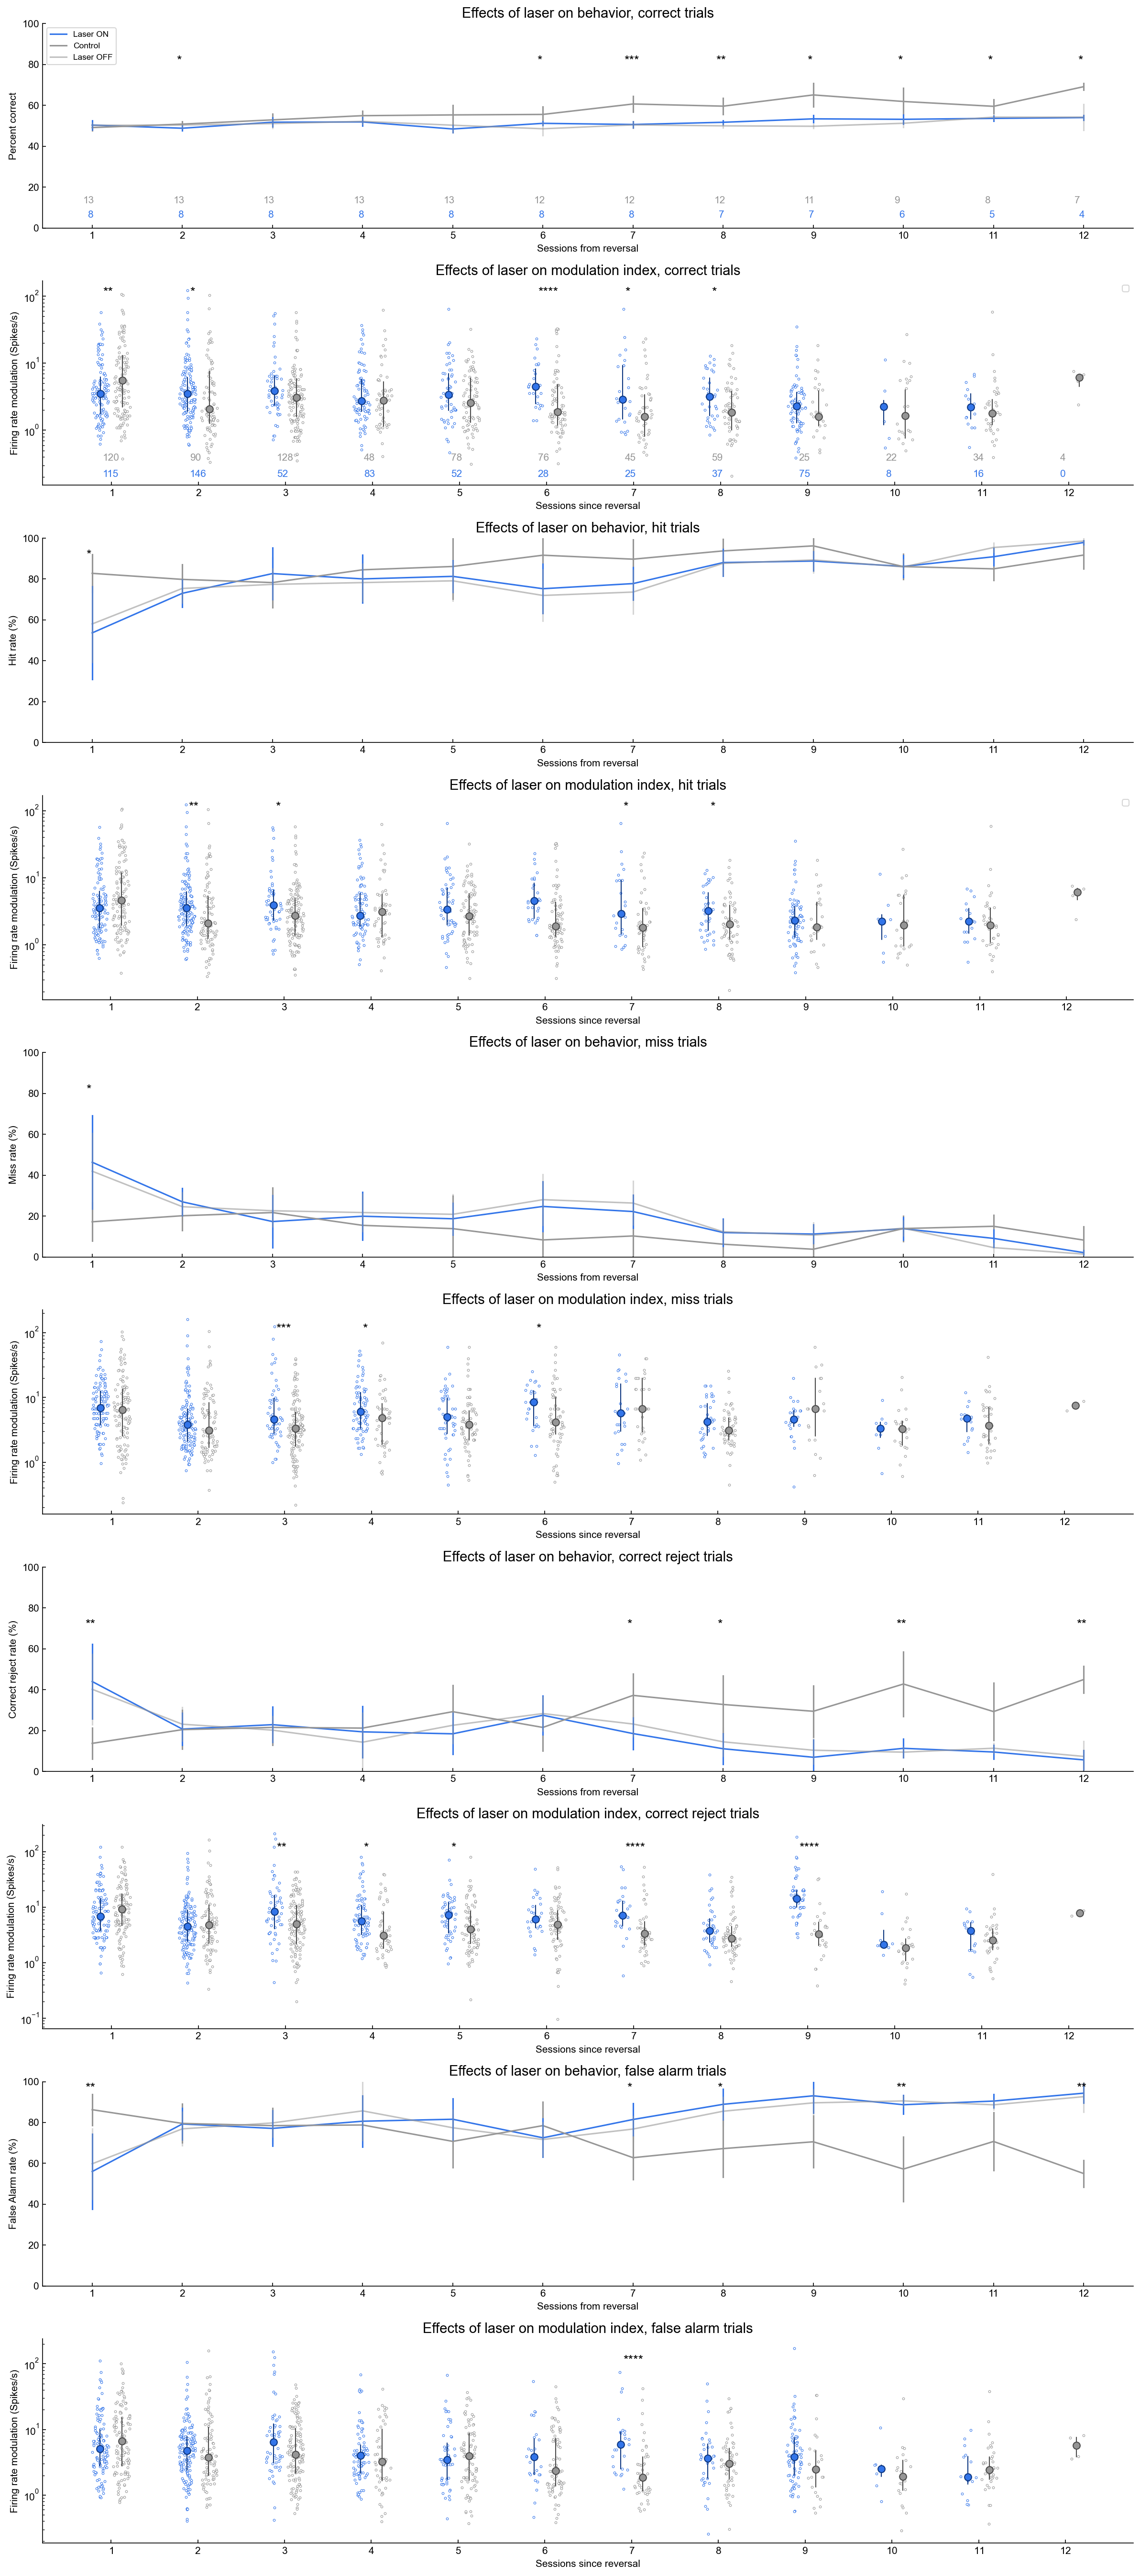

In [24]:
import numpy as np
import matplotlib.pyplot as plt

fs = 14  # fontsize
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(16, 36))
fig.tight_layout(pad=5)

######################################################################################################################################################################################################
## CORRECT
######################################################################################################################################################################################################

###################################
# BEHAV CORRECT
###################################
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_corr_noNan[i][:],opsin_pct_corr_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05

# computing and plotting significance for day0_postR
# sig_day0_postR = 0
# pval_day0_postR = 0
# test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][0],opsin_day0_postR_ON[:][0])

# pval_day0_postR = test_day0_postR.pvalue
# sig_day0_postR = np.abs(pval_day0_postR) < 0.05
# sig_where_day0_postR = np.where(sig_day0_postR) 
# sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
# sigYs_day0_postR = 80
# if 0.01 < pval_day0_postR < 0.05:
#     ax[0].text(0,sigYs_day0_postR, str('*'), size = 13)
# if 0.005 < pval_day0_postR < 0.01:
#     ax[0].text(0,sigYs_day0_postR, str('**'), size = 13)
# if 0.001 < pval_day0_postR < 0.005:
#     ax[0].text(0,sigYs_day0_postR, str('***'), size = 13)
# if pval_day0_postR < 0.001:
#     ax[0].text(-0.1,sigYs_day0_postR, str('****'), size = 13) 

# changing labels, accounting for 'days' before reversal
axs[0].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
axs[0].set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)
#ax[0].axvline(-0.5, color = 'k', linestyle = 'dashed', label = 'Reversal')


# plotting opsin on/off and dual for days following reversal, MEAN AND SEM
axs[0].plot(days, corrData_plot[1], color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
axs[0].plot(days, corrData_plot[0], color = GOOD_GREY, label = 'Control') # dualRec
axs[0].plot(days, corrData_plot[2], color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
axs[0].plot([days,days], [corrSEM_plot[0], corrSEM_plot[1]], color = GOOD_GREY) # opsin ON
axs[0].plot([days,days], [corrSEM_plot[2], corrSEM_plot[3]], color = LASER_COLOR) # control
axs[0].plot([days,days], [corrSEM_plot[4], corrSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF

# # plotting day dual control, opsin off for day before, MEAN AND SEM
# predays = [-2,-1,0]
# ax[0].plot([-2,-1], [opsin_dayBefore_OFF_mean[0], opsin_day0_preR_OFF_mean[0]], color = GOOD_GREY, alpha = 0.6) #opsin off, day before and pre-reversal
# ax[0].plot([-2, -1], [dual_dayBefore_OFF_mean[0], dual_day0_preR_OFF_mean[0]], color = GOOD_GREY) #dualRec off, day before and pre-reversal
# ax[0].plot([predays, predays], opsin_beforeDay1_OFF_corr, color = GOOD_GREY, alpha = 0.4 ) # opsin OFF
# ax[0].plot([0,0], opsin_beforeDay1_ON_corr, color = LASER_COLOR ) # opsin ON
# ax[0].plot([predays, predays], dual_beforeDay1_corr, color = GOOD_GREY) # control


# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 80
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        axs[0].text(i+0.935,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        axs[0].text(i+0.92,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        axs[0].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        axs[0].text(i+0.86,sigYs, str('****'), size = 13)

axs[0].set_xlabel('Sessions from reversal')
axs[0].set_ylabel('Percent correct')
axs[0].set_title('Effects of laser on behavior, correct trials', fontsize=fs)
axs[0].legend(loc = 'upper left')
axs[0].set_ylim(0,100)

# plotting # of days
for i in range(12):
    axs[0].text(days[i]-.05,5, num_nan_opsin[i], color = LASER_COLOR)
    axs[0].text(days[i]-.1,12, num_nan_dual[i], color = GOOD_GREY)
    
    
###################################
# FR MOD CORRECT
###################################
sig = [0 for element in range(11)]
pval =[0 for element in range(11)]
for i in range(10):

    test = mannwhitneyu(opsin_day_clust_on_hit[i][:],dual_day_clust_off_corr[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05

#################### JACKS PLOTTING CODE ########################
data_ON = np.copy(opsin_day_clust_on_hit)
X_ON = np.array([np.ones(len(l))*idx for idx,l in enumerate(data_ON)])+1
_,Y_ON = ilep.violin(np.concatenate(X_ON),np.concatenate(data_ON))
X_ON,_ = ilep.violin(np.concatenate(X_ON),np.log10(np.concatenate(data_ON)),width=0.25)
X_ON -= 0.125

data_OFF = np.copy(dual_day_clust_off_hit)
X_OFF = np.array([np.ones(len(l))*idx for idx,l in enumerate(data_OFF)])+1
_,Y_OFF = ilep.violin(np.concatenate(X_OFF),np.concatenate(data_OFF))
X_OFF,_ = ilep.violin(np.concatenate(X_OFF),np.log10(np.concatenate(data_OFF)),width=0.25)
X_OFF += 0.125

size = 5
axs[1].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
axs[1].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, laser ON
median_ON = np.copy(opsin_day_clust_on_hit)
for i in range(10):  
    median_ON[i] = np.median(opsin_day_clust_on_hit[i])       
for idx,column in enumerate(opsin_day_clust_on_hit):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[1].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    axs[1].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, laser OFF
median_ON = np.copy(dual_day_clust_off_corr)
for i in range(10):  
    median_ON[i] = np.median(dual_day_clust_off_corr[i])       
for idx,column in enumerate(dual_day_clust_off_corr):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(GOOD_GREY)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[1].scatter([idx+1+0.125], [median], ec=border_color,fc=GOOD_GREY, s=summary_size,lw=summary_width, zorder=10)
    axs[1].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

##############################################################
# cleaning up axes
axs[1].set_yscale('log')
axs[1].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
axs[1].set_ylabel('Firing rate modulation (Spikes/s)')
axs[1].set_xlabel('Sessions since reversal')
axs[1].set_title('Effects of laser on modulation index, correct trials', fontsize=fs)
axs[1].legend('Laser on', 'Control')
    
# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(10):

    if 0.01 < pval[i] < 0.05:
        axs[1].text(i+0.9,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        axs[1].text(i+0.9,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        axs[1].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        axs[1].text(i+0.9,sigYs, str('****'), size = 13)

# plotting # of clusters
for i in range(12):
    axs[1].text(days[i]-.1,0.2, int(opsin_numClusters_across_days[i]), color = LASER_COLOR)
    axs[1].text(days[i]-.1,0.35, int(dual_numClusters_across_days[i]), color = GOOD_GREY)


######################################################################################################################################################################################################
## HIT
######################################################################################################################################################################################################

###################################
# BEHAV HIT
###################################
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_hit_noNan[i][:],opsin_pct_hit_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05

# computing and plotting significance for day0_postR
# sig_day0_postR = 0
# pval_day0_postR = 0
# test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][1],opsin_day0_postR_ON[:][1])

# pval_day0_postR = test_day0_postR.pvalue
# sig_day0_postR = np.abs(pval_day0_postR) < 0.05
# sig_where_day0_postR = np.where(sig_day0_postR) 
# sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
# sigYs_day0_postR = 90
# if 0.01 < pval_day0_postR < 0.05:
#     ax[1].text(0,sigYs_day0_postR, str('*'), size = 13)
# if 0.005 < pval_day0_postR < 0.01:
#     ax[1].text(0,sigYs_day0_postR, str('**'), size = 13)
# if 0.001 < pval_day0_postR < 0.005:
#     ax[1].text(0,sigYs_day0_postR, str('***'), size = 13)
# if pval_day0_postR < 0.001:
#     ax[1].text(0,sigYs_day0_postR, str('****'), size = 13)    
    
# changing labels, accounting for 'days' before reversal
axs[2].set_xticks([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
axs[2].set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)
#ax[1].axvline(-0.5, color = 'k', linestyle = 'dashed', label = 'Reversal')

# plotting opsin on/off and dual for days following reversal, MEAN AND SEM
axs[2].plot(days, hitData_plot[1], color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
axs[2].plot(days, hitData_plot[0], color = GOOD_GREY, label = 'Control') # dualRec
axs[2].plot(days, hitData_plot[2],  color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
axs[2].plot([days,days], [hitSEM_plot[0], hitSEM_plot[1]], color = GOOD_GREY) # opsin ON
axs[2].plot([days,days], [hitSEM_plot[2], hitSEM_plot[3]], color = LASER_COLOR) # control
axs[2].plot([days,days], [hitSEM_plot[4], hitSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF

# # plotting day dual control, opsin off for day before, MEAN AND SEM
# predays = [-2,-1,0]
# ax[1].plot([-2,-1], [opsin_dayBefore_OFF_mean[1], opsin_day0_preR_OFF_mean[1]], color = GOOD_GREY, alpha = 0.6) #opsin off, day before and pre-reversal
# ax[1].plot([-2, -1], [dual_dayBefore_OFF_mean[1], dual_day0_preR_OFF_mean[1]], color = GOOD_GREY) #dualRec off, day before and pre-reversal
# ax[1].plot([predays, predays], opsin_beforeDay1_OFF_hit, color = GOOD_GREY, alpha = 0.4 ) # opsin OFF
# ax[1].plot([0,0], opsin_beforeDay1_ON_hit, color = LASER_COLOR ) # opsin ON
# ax[1].plot([predays, predays], dual_beforeDay1_hit, color = GOOD_GREY) # control

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 90
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        axs[2].text(i+0.935,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        axs[2].text(i+0.92,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        axs[2].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        axs[2].text(i+0.86,sigYs, str('****'), size = 13)

axs[2].set_xlabel('Sessions from reversal')
axs[2].set_ylabel('Hit rate (%)')
axs[2].set_title('Effects of laser on behavior, hit trials', fontsize=fs)
axs[2].set_ylim(0,100)


###################################
# FR MOD HIT
###################################
sig = [0 for element in range(11)]
pval =[0 for element in range(11)]
for i in range(10):

    test = mannwhitneyu(opsin_day_clust_on_hit[i][:],dual_day_clust_off_hit[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05

#################### JACKS PLOTTING CODE ########################
data_ON = np.copy(opsin_day_clust_on_hit)
X_ON = np.array([np.ones(len(l))*idx for idx,l in enumerate(data_ON)])+1
_,Y_ON = ilep.violin(np.concatenate(X_ON),np.concatenate(data_ON))
X_ON,_ = ilep.violin(np.concatenate(X_ON),np.log10(np.concatenate(data_ON)),width=0.25)
X_ON -= 0.125

data_OFF = np.copy(dual_day_clust_off_hit)
X_OFF = np.array([np.ones(len(l))*idx for idx,l in enumerate(data_OFF)])+1
_,Y_OFF = ilep.violin(np.concatenate(X_OFF),np.concatenate(data_OFF))
X_OFF,_ = ilep.violin(np.concatenate(X_OFF),np.log10(np.concatenate(data_OFF)),width=0.25)
X_OFF += 0.125

size = 5
axs[3].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
axs[3].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, laser ON
median_ON = np.copy(opsin_day_clust_on_hit)
for i in range(10):  
    median_ON[i] = np.median(opsin_day_clust_on_hit[i])       
for idx,column in enumerate(opsin_day_clust_on_hit):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[3].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    axs[3].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, laser OFF
median_ON = np.copy(dual_day_clust_off_hit)
for i in range(10):  
    median_ON[i] = np.median(dual_day_clust_off_hit[i])       
for idx,column in enumerate(dual_day_clust_off_hit):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(GOOD_GREY)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[3].scatter([idx+1+0.125], [median], ec=border_color,fc=GOOD_GREY, s=summary_size,lw=summary_width, zorder=10)
    axs[3].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
##############################################################
# cleaning up axes
axs[3].set_yscale('log')
axs[3].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
axs[3].set_ylabel('Firing rate modulation (Spikes/s)')
axs[3].set_xlabel('Sessions since reversal')
axs[3].set_title('Effects of laser on modulation index, hit trials', fontsize=fs)
axs[3].legend('Laser on', 'Control')
    
# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(10):

    if 0.01 < pval[i] < 0.05:
        axs[3].text(i+0.9,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        axs[3].text(i+0.9,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        axs[3].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[3] < 0.001:
        axs[3].text(i+0.9,sigYs, str('****'), size = 13)
        
######################################################################################################################################################################################################
## MISS
######################################################################################################################################################################################################

###################################
# BEHAV MISS5
###################################
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_miss_noNan[i][:],opsin_pct_miss_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
   
# # computing and plotting significance for day0_postR
# sig_day0_postR = 0
# pval_day0_postR = 0
# test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][2],opsin_day0_postR_ON[:][2])

# pval_day0_postR = test_day0_postR.pvalue
# sig_day0_postR = np.abs(pval_day0_postR) < 0.05
# sig_where_day0_postR = np.where(sig_day0_postR) 
# sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
# sigYs_day0_postR = 80
# if 0.01 < pval_day0_postR < 0.05:
#     ax[4].text(0,sigYs_day0_postR, str('*'), size = 13)
# if 0.005 < pval_day0_postR < 0.01:
#     ax[4].text(0,sigYs_day0_postR, str('**'), size = 13)
# if 0.001 < pval_day0_postR < 0.005:
#     ax[4].text(0,sigYs_day0_postR, str('***'), size = 13)
# if pval_day0_postR < 0.001:
#     ax[4].text(0,sigYs_day0_postR, str('****'), size = 13)      

# changing labels, accounting for 'days' before reversal
axs[4].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
axs[4].set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)
#ax[4].axvline(-0.5, color = 'k', linestyle = 'dashed', label = 'Reversal')

# plotting opsin on/off and dual for days following reversal, MEAN AND SEM
axs[4].plot(days, missData_plot[1], color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
axs[4].plot(days, missData_plot[0], color = GOOD_GREY, label = 'Control') # dualRec
axs[4].plot(days, missData_plot[2], color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
axs[4].plot([days,days], [missSEM_plot[0], missSEM_plot[1]], color = GOOD_GREY) # opsin ON
axs[4].plot([days,days], [missSEM_plot[2], missSEM_plot[3]], color = LASER_COLOR) # control
axs[4].plot([days,days], [missSEM_plot[4], missSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF

# # plotting day dual control, opsin off for day before, MEAN AND SEM
# predays = [-2,-1,0]
# ax[4].plot([-2,-1], [opsin_dayBefore_OFF_mean[2], opsin_day0_preR_OFF_mean[2]], color = GOOD_GREY, alpha = 0.6) #opsin off, day before and pre-reversal
# ax[4].plot([-2, -1], [dual_dayBefore_OFF_mean[2], dual_day0_preR_OFF_mean[2]], color = GOOD_GREY) #dualRec off, day before and pre-reversal
# ax[4].plot([predays, predays], opsin_beforeDay1_OFF_miss, color = GOOD_GREY, alpha = 0.4 ) # opsin OFF
# ax[4].plot([0,0], opsin_beforeDay1_ON_miss, color = LASER_COLOR ) # opsin ON
# ax[4].plot([predays, predays], dual_beforeDay1_miss, color = GOOD_GREY) # control

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 80
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        axs[4].text(i+0.935,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        axs[4].text(i+0.92,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        axs[4].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        axs[4].text(i+0.86,sigYs, str('****'), size = 13)

axs[4].set_xlabel('Sessions from reversal')
axs[4].set_ylabel('Miss rate (%)')
axs[4].set_title('Effects of laser on behavior, miss trials', fontsize=fs)
axs[4].set_ylim(0,100)

###################################
# FR MOD MISS
###################################
# compute significance
sig = [0 for element in range(11)]
pval =[0 for element in range(11)]
for i in range(10):
        
    test = mannwhitneyu(opsin_day_clust_on_miss[i][:],dual_day_clust_off_miss[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
    
#################### JACKS PLOTTING CODE ########################
data_ON = np.copy(opsin_day_clust_on_miss)
X_ON = np.array([np.ones(len(l))*idx for idx,l in enumerate(data_ON)])+1
_,Y_ON = ilep.violin(np.concatenate(X_ON),np.concatenate(data_ON))
X_ON,_ = ilep.violin(np.concatenate(X_ON),np.log10(np.concatenate(data_ON)),width=0.25)
X_ON -= 0.125

data_OFF = np.copy(dual_day_clust_off_miss)
X_OFF = np.array([np.ones(len(l))*idx for idx,l in enumerate(data_OFF)])+1
_,Y_OFF = ilep.violin(np.concatenate(X_OFF),np.concatenate(data_OFF))
X_OFF,_ = ilep.violin(np.concatenate(X_OFF),np.log10(np.concatenate(data_OFF)),width=0.25)
X_OFF += 0.125

size = 5
axs[5].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
axs[5].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, LASER ON
median_ON = np.copy(opsin_day_clust_on_miss)
for i in range(10):  
    median_ON[i] = np.median(opsin_day_clust_on_miss[i]) # define median
for idx,column in enumerate(opsin_day_clust_on_miss):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[5].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10) #plot 
    axs[5].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, LASER OFF
median_ON = np.copy(dual_day_clust_off_miss)
for i in range(10):  
    median_ON[i] = np.median(dual_day_clust_off_miss[i])       
for idx,column in enumerate(dual_day_clust_off_miss):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=GOOD_GREY 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[5].scatter([idx+1+0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    axs[5].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
################################################################
# cleaning up axes
axs[5].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
axs[5].set_ylabel('Firing rate modulation (Spikes/s)')
axs[5].set_xlabel('Sessions since reversal')
axs[5].set_title('Effects of laser on modulation index, miss trials', fontsize=fs)
axs[5].set_yscale('log')

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(10):

    if 0.01 < pval[i] < 0.05:
        axs[5].text(i+0.9,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        axs[5].text(i+0.9,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        axs[5].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        axs[5].text(i+0.9,sigYs, str('****'), size = 13)


######################################################################################################################################################################################################
## CORRECT REJECT
######################################################################################################################################################################################################

###################################
# BEHAVOR CORRECT REJECT
###################################
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_creject_noNan[i][:],opsin_pct_creject_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
        
# computing and plotting significance for day0_postR
# sig_day0_postR = 0
# pval_day0_postR = 0
# test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][3],opsin_day0_postR_ON[:][3])

# pval_day0_postR = test_day0_postR.pvalue
# sig_day0_postR = np.abs(pval_day0_postR) < 0.05
# sig_where_day0_postR = np.where(sig_day0_postR) 
# sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
# sigYs_day0_postR = 60
# if 0.01 < pval_day0_postR < 0.05:
#     axs[6].text(0,sigYs_day0_postR, str('*'))
# if 0.005 < pval_day0_postR < 0.01:
#     axs[6].text(0,sigYs_day0_postR, str('**'))
# if 0.001 < pval_day0_postR < 0.005:
#     axs[6].text(0,sigYs_day0_postR, str('***'))
# if pval_day0_postR < 0.001:
#   axs[6].text(0,sigYs_day0_postR, str('****'))
  
# changing labels, accounting for 'days' before reversal
axs[6].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
axs[6].set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)
#axs[6].axvline(-0.5, color = 'k', linestyle = 'dashed', label = 'Reversal')
print(pval)


# PLOTTING opsin on/off and dual for days following reversal, MEAN AND SEM
axs[6].plot(days, crejectData_plot[1], color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
axs[6].plot(days, crejectData_plot[0], color = GOOD_GREY, label = 'Control') # dualRec
axs[6].plot(days, crejectData_plot[2], color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
axs[6].plot([days,days], [crejectSEM_plot[0], crejectSEM_plot[1]], color = GOOD_GREY) # opsin ON
axs[6].plot([days,days], [crejectSEM_plot[2], crejectSEM_plot[3]], color = LASER_COLOR) # control
axs[6].plot([days,days], [crejectSEM_plot[4], crejectSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF

# plotting day dual control, opsin off for day before, MEAN AND SEM
# predays = [-2,-1,0]
# axs[6].plot([-2,-1], [opsin_dayBefore_OFF_mean[3], opsin_day0_preR_OFF_mean[3]], color = GOOD_GREY, alpha = 0.6) #opsin off, day before and pre-reversal
# axs[6].plot([-2, -1], [dual_dayBefore_OFF_mean[3], dual_day0_preR_OFF_mean[3]], color = GOOD_GREY) #dualRec off, day before and pre-reversal
# axs[6].plot([predays, predays], opsin_beforeDay1_OFF_creject, color = GOOD_GREY, alpha = 0.4 ) # opsin OFF
# axs[6].plot([0,0], opsin_beforeDay1_ON_creject, color = LASER_COLOR ) # opsin ON
# axs[6].plot([predays, predays], dual_beforeDay1_creject, color = GOOD_GREY) # control

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 70
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        axs[6].text(i+0.935,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        axs[6].text(i+0.92,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        axs[6].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        axs[6].text(i+0.86,sigYs, str('****'), size = 13)

axs[6].set_xlabel('Sessions from reversal')
axs[6].set_ylabel('Correct reject rate (%)')
axs[6].set_title('Effects of laser on behavior, correct reject trials', fontsize=fs)
axs[6].set_ylim(0,100)

###################################
# FR MOD CORRECT REJECT
###################################
# # compute significance
sig = [0 for element in range(11)]
pval =[0 for element in range(11)]
for i in range(10):
        
    test = mannwhitneyu(opsin_day_clust_on_creject[i][:],dual_day_clust_off_creject[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
    
#################### JACKS PLOTTING CODE ########################
data_ON = np.copy(opsin_day_clust_on_creject)
X_ON = np.array([np.ones(len(l))*idx for idx,l in enumerate(data_ON)])+1
_,Y_ON = ilep.violin(np.concatenate(X_ON),np.concatenate(data_ON))
X_ON,_ = ilep.violin(np.concatenate(X_ON),np.log10(np.concatenate(data_ON)),width=0.25)
X_ON -= 0.125

data_OFF = np.copy(dual_day_clust_off_creject)
X_OFF = np.array([np.ones(len(l))*idx for idx,l in enumerate(data_OFF)])+1
_,Y_OFF = ilep.violin(np.concatenate(X_OFF),np.concatenate(data_OFF))
X_OFF,_ = ilep.violin(np.concatenate(X_OFF),np.log10(np.concatenate(data_OFF)),width=0.25)
X_OFF += 0.125

size = 5
axs[7].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
axs[7].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, LASER ON
median_ON = np.copy(opsin_day_clust_on_creject)
for i in range(10):  
    median_ON[i] = np.median(opsin_day_clust_on_creject[i]) # define median
for idx,column in enumerate(opsin_day_clust_on_creject):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[7].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10) #plot 
    axs[7].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, LASER OFF
median_ON = np.copy(dual_day_clust_off_creject)
for i in range(10):  
    median_ON[i] = np.median(dual_day_clust_off_creject[i])       
for idx,column in enumerate(dual_day_clust_off_creject):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=GOOD_GREY 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[7].scatter([idx+1+0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    axs[7].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
################################################################
# cleaning up axes
axs[7].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
axs[7].set_ylabel('Firing rate modulation (Spikes/s)')
axs[7].set_xlabel('Sessions since reversal')
axs[7].set_title('Effects of laser on modulation index, correct reject trials', fontsize=fs)
axs[7].set_yscale('log')

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(10):
    if 0.01 < pval[i] < 0.05:
        axs[7].text(i+0.9,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        axs[7].text(i+0.9,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        axs[7].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        axs[7].text(i+0.9,sigYs, str('****'), size = 13)

######################################################################################################################################################################################################
## FALSE ALARM
######################################################################################################################################################################################################

###################################
# BEHAV FALSE ALARM
###################################
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    test = mannwhitneyu(dual_pct_falarm_noNan[i][:],opsin_pct_falarm_ON_noNan[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
    
# # computing and plotting significance for day0_postR
# sig_day0_postR = 0
# pval_day0_postR = 0
# test_day0_postR = mannwhitneyu(dual_day0_postR_OFF[:][4],opsin_day0_postR_ON[:][4])

# pval_day0_postR = test_day0_postR.pvalue
# sig_day0_postR = np.abs(pval_day0_postR) < 0.05
# sig_where_day0_postR = np.where(sig_day0_postR) 
# sigDays_day0_postR = np.array([items for items in sig_where_day0_postR[0]])
# sigYs_day0_postR = 60
# if 0.01 < pval_day0_postR < 0.05:
#     axs[8].text(0,sigYs_day0_postR, str('*'))
# if 0.005 < pval_day0_postR < 0.01:
#     axs[8].text(0,sigYs_day0_postR, str('**'))
# if 0.001 < pval_day0_postR < 0.005:
#     axs[8].text(0,sigYs_day0_postR, str('***'))
# if pval_day0_postR < 0.001:
#     axs[8].text(0,sigYs_day0_postR, str('****'))
  
# changing labels, accounting for 'days' before reversal
axs[8].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
axs[8].set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)
#axs[8].axvline(-0.5, color = 'k', linestyle = 'dashed', label = 'Reversal')

# plotting opsin on/off and dual for days following reversal, MEAN AND SEM
axs[8].plot(days, falarmData_plot[1],  color = LASER_COLOR, label = 'Laser ON') # changing opsin on to include day 0 post-reversal
axs[8].plot(days, falarmData_plot[0],  color = GOOD_GREY, label = 'Control') # dualRec
axs[8].plot(days, falarmData_plot[2],  color = GOOD_GREY,  alpha = 0.6, label = 'Laser OFF') #opsin OFF
axs[8].plot([days,days], [falarmSEM_plot[0], falarmSEM_plot[1]], color = GOOD_GREY) # opsin ON
axs[8].plot([days,days], [falarmSEM_plot[2], falarmSEM_plot[3]], color = LASER_COLOR) # control
axs[8].plot([days,days], [falarmSEM_plot[4], falarmSEM_plot[5]], color = GOOD_GREY, alpha = 0.4) # opsin OFF

# plotting day dual control, opsin off for day before, MEAN AND SEM
# predays = [-2,-1,0]
# axs[8].plot([-2,-1], [opsin_dayBefore_OFF_mean[3], opsin_day0_preR_OFF_mean[3]], color = GOOD_GREY, alpha = 0.6) #opsin off, day before and pre-reversal
# axs[8].plot([-2, -1], [dual_dayBefore_OFF_mean[3], dual_day0_preR_OFF_mean[3]], color = GOOD_GREY) #dualRec off, day before and pre-reversal
# axs[8].plot([predays, predays], opsin_beforeDay1_OFF_creject, color = GOOD_GREY, alpha = 0.4 ) # opsin OFF
# axs[8].plot([0,0], opsin_beforeDay1_ON_creject, color = LASER_COLOR ) # opsin ON
# axs[8].plot([predays, predays], dual_beforeDay1_creject, color = GOOD_GREY) # control

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 95
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        axs[8].text(i+0.935,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        axs[8].text(i+0.92,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        axs[8].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        axs[8].text(i+0.86,sigYs, str('****'), size = 13)

axs[8].set_xlabel('Sessions from reversal')
axs[8].set_ylabel('False Alarm rate (%)')
axs[8].set_title('Effects of laser on behavior, false alarm trials', fontsize=fs)
axs[8].set_ylim(0,100)


###################################
# FR MOD FALSE ALARM
###################################
# compute significance
sig = [0 for element in range(11)]
pval =[0 for element in range(11)]
for i in range(10):
        
    test = mannwhitneyu(opsin_day_clust_on_falarm[i][:],dual_day_clust_off_falarm[i][:])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
    
#################### JACKS PLOTTING CODE ########################
data_ON = np.copy(opsin_day_clust_on_falarm)
X_ON = np.array([np.ones(len(l))*idx for idx,l in enumerate(data_ON)])+1
_,Y_ON = ilep.violin(np.concatenate(X_ON),np.concatenate(data_ON))
X_ON,_ = ilep.violin(np.concatenate(X_ON),np.log10(np.concatenate(data_ON)),width=0.25)
X_ON -= 0.125

data_OFF = np.copy(dual_day_clust_off_falarm)
X_OFF = np.array([np.ones(len(l))*idx for idx,l in enumerate(data_OFF)])+1
_,Y_OFF = ilep.violin(np.concatenate(X_OFF),np.concatenate(data_OFF))
X_OFF,_ = ilep.violin(np.concatenate(X_OFF),np.log10(np.concatenate(data_OFF)),width=0.25)
X_OFF += 0.125

size = 5
axs[9].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
axs[9].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, LASER ON
median_ON = np.copy(opsin_day_clust_on_falarm)
for i in range(10):  
    median_ON[i] = np.median(opsin_day_clust_on_falarm[i]) # define median
for idx,column in enumerate(opsin_day_clust_on_falarm):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[9].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10) #plot 
    axs[9].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, LASER OFF
median_ON = np.copy(dual_day_clust_off_falarm)
for i in range(10):  
    median_ON[i] = np.median(dual_day_clust_off_falarm[i])       
for idx,column in enumerate(dual_day_clust_off_falarm):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=GOOD_GREY 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[9].scatter([idx+1+0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    axs[9].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
################################################################
# cleaning up axes
axs[9].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
axs[9].set_ylabel('Firing rate modulation (Spikes/s)')
axs[9].set_xlabel('Sessions since reversal')
axs[9].set_title('Effects of laser on modulation index, false alarm trials', fontsize=fs)
axs[9].set_yscale('log')
    
# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(10):

    if 0.01 < pval[i] < 0.05:
        axs[9].text(i+0.9,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        axs[9].text(i+0.9,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        axs[9].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        axs[9].text(i+0.9,sigYs, str('****'), size = 13)

###############################################################################################################################################################################################################
plt.tight_layout()
plt.savefig('Opsin Effects Across Sessions, combined behavior and FR Mod.pdf')
plt.show()